<h1 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 800;
    font-size: 3rem;
    text-align: center;
    color: #4a90e2; /* azul medianoche */
    margin: 2rem 0 1rem 0;
    letter-spacing: 0.06em;
    user-select: none;
    text-transform: uppercase;
    text-shadow: 0 1px 2px rgba(0,0,0,0.5);
">
    BiLSTM
</h1>


<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
    1. Importar librerías
</h2>

In [1]:
# Librerías fundamentales
import pandas as pd
import numpy as np
import requests
import gzip
import csv
from io import BytesIO

# Deep Learning con PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Procesamiento de Lenguaje Natural - MULTILINGÜE
import spacy
import nltk
from collections import Counter, defaultdict
import re

# Machine Learning y Métricas
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score,
    # Métricas multiclase
    multilabel_confusion_matrix, hamming_loss, jaccard_score,
    f1_score, precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Utilidades
import warnings
from tqdm.auto import tqdm
import random
import itertools

# Configuración básica mejorada
warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("🌍 IMPORTACIONES COMPLETADAS - DETECTOR MULTICLASE MULTILINGÜE")
print("=" * 65)
print("✅ PyTorch: Deep Learning híbrido")
print("✅ spaCy: Procesamiento multilingüe (xx_ent_wiki_sm)")
print("✅ scikit-learn: Métricas multiclase avanzadas")
print("✅ Visualización: Matrices de confusión multiclase")
print("✅ Validación cruzada: StratifiedKFold multiclase")
print("=" * 65)

# Verificar disponibilidad del modelo multilingüe
try:
    nlp_test = spacy.load("en_core_web_sm")
    print("🎯 spaCy multilingüe (en_core_web_sm): ✅ DISPONIBLE")
    print(f"   Idiomas soportados: 50+ (Universal)")
    print(f"   Tamaño del modelo: ~50MB")
    nlp_test = None
except OSError:
    print("❌ spaCy multilingüe NO DISPONIBLE")
    print("📦 Instalar con: python -m spacy download en_core_web_sm")

🌍 IMPORTACIONES COMPLETADAS - DETECTOR MULTICLASE MULTILINGÜE
✅ PyTorch: Deep Learning híbrido
✅ spaCy: Procesamiento multilingüe (xx_ent_wiki_sm)
✅ scikit-learn: Métricas multiclase avanzadas
✅ Visualización: Matrices de confusión multiclase
✅ Validación cruzada: StratifiedKFold multiclase
🎯 spaCy multilingüe (en_core_web_sm): ✅ DISPONIBLE
   Idiomas soportados: 50+ (Universal)
   Tamaño del modelo: ~50MB


<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
    2. Carga de Datos y Exploración inicial
</h2>


In [2]:
# URLs y paths
GITHUB_CLEAN_URL = "https://raw.githubusercontent.com/Yael-Parra/sentiment-analyzer-inc/feature/eda/eda/data/youtube_dataset_cleaned.csv.gz"
SYNTHETIC_DATA_PATH = "../../eda/data/youtube_comments_ultra_realistic_6096.csv"
CLEANED_DATA_PATH = "youtube_dataset_cleaned.csv"

def load_youtube_data_from_github(url):
    """Carga el dataset con soporte para análisis multiclase"""
    print("📥 Descargando dataset desde GitHub...")
    try:
        response = requests.get(url)
        response.raise_for_status()
        with gzip.open(BytesIO(response.content), 'rt', encoding='utf-8') as f:
            df = pd.read_csv(f, sep=',', encoding='utf-8', quoting=csv.QUOTE_MINIMAL)
        print(f"✅ Dataset GitHub cargado: {len(df)} registros")
        return df
    except Exception as e:
        print(f"❌ Error cargando desde GitHub: {e}")
        return None

def load_synthetic_data(path):
    """Carga el dataset sintético"""
    print("📥 Cargando dataset sintético...")
    try:
        df = pd.read_csv(path, encoding='utf-8')
        print(f"✅ Dataset sintético cargado: {len(df)} registros")
        return df
    except Exception as e:
        print(f"❌ Error cargando dataset sintético: {e}")
        return None

def standardize_columns(df, dataset_type="github"):
    """Estandariza las columnas según el tipo de dataset"""
    if dataset_type == "github":
        # Asegurar que todas las columnas de toxicidad estén presentes
        required_cols = ['is_toxic', 'is_abusive', 'is_provocative', 'is_hatespeech', 
                        'is_offensive', 'is_insulting', 'is_threatening', 'is_identity_attack']
        for col in required_cols:
            if col not in df.columns:
                df[col] = 0
    elif dataset_type == "synthetic":
        # Mapear columnas del dataset sintético si es necesario
        # Ajustar según la estructura real del dataset sintético
        pass
    
    return df

def merge_datasets(df_github, df_synthetic):
    """Combina ambos datasets de forma inteligente"""
    print("🔄 Combinando datasets...")
    
    # Estandarizar columnas
    df_github = standardize_columns(df_github, "github")
    df_synthetic = standardize_columns(df_synthetic, "synthetic")
    
    # Encontrar columnas comunes
    common_cols = list(set(df_github.columns) & set(df_synthetic.columns))
    print(f"   Columnas comunes: {len(common_cols)}")
    
    # Asegurar que al menos tenemos 'text' y columnas de toxicidad
    essential_cols = ['text'] + [col for col in common_cols if col.startswith('is_')]
    
    # Seleccionar columnas esenciales de cada dataset
    df_github_selected = df_github[essential_cols].copy()
    df_synthetic_selected = df_synthetic[essential_cols].copy()
    
    # Agregar origen
    df_github_selected['source'] = 'github'
    df_synthetic_selected['source'] = 'synthetic'
    
    # Combinar
    df_combined = pd.concat([df_github_selected, df_synthetic_selected], 
                           ignore_index=True, sort=False)
    
    print(f"✅ Datasets combinados: {len(df_combined)} registros totales")
    print(f"   - GitHub: {len(df_github_selected)} registros")
    print(f"   - Sintético: {len(df_synthetic_selected)} registros")
    
    return df_combined

# Cargar datasets
df_github = load_youtube_data_from_github(GITHUB_CLEAN_URL)
df_synthetic = load_synthetic_data(SYNTHETIC_DATA_PATH)

# Verificar que ambos datasets se cargaron
datasets_loaded = []
if df_github is not None:
    datasets_loaded.append(("GitHub", df_github))
if df_synthetic is not None:
    datasets_loaded.append(("Sintético", df_synthetic))

if not datasets_loaded:
    print("❌ No se pudo cargar ningún dataset")
    df = None
else:
    # Si tenemos ambos datasets, combinarlos
    if len(datasets_loaded) == 2:
        df = merge_datasets(df_github, df_synthetic)
    else:
        # Si solo tenemos uno, usar ese
        print(f"⚠️  Solo disponible dataset: {datasets_loaded[0][0]}")
        df = datasets_loaded[0][1]
        df['source'] = datasets_loaded[0][0].lower()

# Continuar solo si tenemos datos
if df is not None:
    # Exploración básica mejorada para multiclase
    print(f"\n📊 INFORMACIÓN DEL DATASET COMBINADO:")
    print(f"Shape: {df.shape}")
    print(f"Columnas: {list(df.columns)}")
    
    # Verificar calidad de datos
    print(f"\n🔍 CALIDAD DE DATOS:")
    print(f"Valores nulos: {df.isnull().sum().sum()}")
    print(f"Duplicados: {df.duplicated().sum()}")
    if 'source' in df.columns:
        print(f"Distribución por fuente:")
        print(df['source'].value_counts().to_string())
    
    # ANÁLISIS MULTICLASE ESPECÍFICO - SIN LÍMITE DE CATEGORÍAS
    print(f"\n🎯 ANÁLISIS MULTICLASE DETALLADO:")
    print("=" * 60)
    
    # Identificar todas las columnas de toxicidad
    toxicity_columns = [col for col in df.columns if col.startswith('is_')]
    print(f"📋 TIPOS DE TOXICIDAD DISPONIBLES: {len(toxicity_columns)}")
    
    # Análisis de viabilidad por clase (criterios más flexibles)
    class_analysis = []
    for col in toxicity_columns:
        positive_cases = df[col].sum()
        percentage = (positive_cases / len(df)) * 100
        
        # Determinar viabilidad (criterios ajustados para multitoxic)
        if positive_cases >= 100:
            status = "🟢 EXCELENTE"
            viable = True
        elif positive_cases >= 50:
            status = "🟡 VIABLE"
            viable = True
        elif positive_cases >= 20:
            status = "🟠 MARGINAL"
            viable = True  # Incluir para análisis inicial
        else:
            status = "🔴 INSUFICIENTE"
            viable = False
        
        class_analysis.append({
            'class': col.replace('is_', ''),
            'column': col,
            'cases': positive_cases,
            'percentage': percentage,
            'viable': viable,
            'status': status
        })
    
    # Ordenar por número de casos
    class_analysis.sort(key=lambda x: x['cases'], reverse=True)
    
    print(f"\n📊 DISTRIBUCIÓN POR TIPO DE TOXICIDAD:")
    viable_classes = []
    for i, analysis in enumerate(class_analysis, 1):
        print(f"   {i:2d}. {analysis['class']:15s}: {analysis['cases']:4d} casos ({analysis['percentage']:5.1f}%) - {analysis['status']}")
        if analysis['viable']:
            viable_classes.append(analysis['column'])
    
    # Configuración multiclase dinámica (todas las clases viables)
    print(f"\n🎯 CONFIGURACIÓN MULTICLASE DINÁMICA:")
    selected_classes = viable_classes
    print(f"   Clases seleccionadas: {len(selected_classes)}")
    for col in selected_classes:
        cases = df[col].sum()
        class_name = col.replace('is_', '')
        percentage = (cases / len(df)) * 100
        print(f"      • {class_name}: {cases} casos ({percentage:.1f}%)")
    
    # Análisis de solapamiento entre todas las clases viables
    print(f"\n🔄 ANÁLISIS DE SOLAPAMIENTO MULTICLASE:")
    if len(selected_classes) > 1:
        # Crear DataFrame solo con clases seleccionadas
        selected_df = df[selected_classes].copy()
        
        # Matriz de co-ocurrencia
        cooccurrence = selected_df.T.dot(selected_df)
        
        # Encontrar solapamientos más significativos
        overlaps = []
        for i, col1 in enumerate(selected_classes):
            for j, col2 in enumerate(selected_classes):
                if i < j:  # Evitar duplicados
                    overlap_count = int(cooccurrence.loc[col1, col2])
                    if overlap_count > 0:
                        # Calcular porcentaje respecto a la clase menor
                        min_class_size = min(df[col1].sum(), df[col2].sum())
                        overlap_pct = (overlap_count / min_class_size) * 100
                        overlaps.append({
                            'class1': col1.replace('is_', ''),
                            'class2': col2.replace('is_', ''),
                            'count': overlap_count,
                            'percentage': overlap_pct
                        })
        
        # Mostrar top solapamientos
        overlaps.sort(key=lambda x: x['count'], reverse=True)
        print(f"   Top combinaciones más frecuentes:")
        for i, overlap in enumerate(overlaps[:10], 1):  # Mostrar top 10
            print(f"      {i:2d}. {overlap['class1']} + {overlap['class2']}: {overlap['count']} casos ({overlap['percentage']:.1f}%)")
    
    # Análisis de distribución multi-label para todas las clases viables
    print(f"\n📈 DISTRIBUCIÓN MULTI-LABEL:")
    if len(selected_classes) > 0:
        # Contar cuántos tipos de toxicidad tiene cada comentario
        toxicity_counts = df[selected_classes].sum(axis=1)
        distribution = toxicity_counts.value_counts().sort_index()
        
        print(f"   Comentarios por número de tipos de toxicidad:")
        for num_types, count in distribution.items():
            percentage = (count / len(df)) * 100
            if num_types == 0:
                print(f"      {num_types} tipos (LIMPIO): {count:5d} comentarios ({percentage:5.1f}%)")
            else:
                print(f"      {num_types} tipo(s): {count:5d} comentarios ({percentage:5.1f}%)")
        
        # Estadísticas de multi-label
        multi_label_cases = (toxicity_counts > 1).sum()
        single_label_cases = (toxicity_counts == 1).sum()
        clean_cases = (toxicity_counts == 0).sum()
        
        print(f"\n   📊 Resumen multi-label:")
        print(f"      • Comentarios limpios: {clean_cases} ({clean_cases/len(df)*100:.1f}%)")
        print(f"      • Un solo tipo: {single_label_cases} ({single_label_cases/len(df)*100:.1f}%)")
        print(f"      • Múltiples tipos: {multi_label_cases} ({multi_label_cases/len(df)*100:.1f}%)")
    
    # Estadísticas de texto
    print(f"\n📝 ESTADÍSTICAS DE TEXTO:")
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    print(f"Longitud promedio: {df['text_length'].mean():.1f} caracteres")
    print(f"Palabras promedio: {df['word_count'].mean():.1f} palabras")
    print(f"Comentario más largo: {df['text_length'].max()} caracteres")
    print(f"Comentario más corto: {df['text_length'].min()} caracteres")
    
    # Ejemplos representativos por clase principal
    print(f"\n📝 EJEMPLOS POR TIPO DE TOXICIDAD:")
    if len(selected_classes) > 0:
        clean_examples = df[df[selected_classes].sum(axis=1) == 0]
        if len(clean_examples) > 0:
            print("Comentario LIMPIO:", clean_examples['text'].iloc[0][:100] + "...")
        
        for col in selected_classes[:8]:  # Mostrar hasta 8 ejemplos
            toxic_examples = df[df[col] == True]
            if len(toxic_examples) > 0:
                class_name = col.replace('is_', '')
                example = toxic_examples['text'].iloc[0][:100] + "..."
                print(f"Tipo {class_name.upper()}: {example}")
    
    # Preparar variables para próximas celdas
    print(f"\n💾 CONFIGURACIÓN GUARDADA:")
    print(f"   viable_classes = {[col.replace('is_', '') for col in selected_classes]}")
    print(f"   target_columns = {selected_classes}")
    print(f"   total_classes = {len(selected_classes)}")
    print(f"   dataset_ready = True")
    
    # Guardar configuración para siguientes celdas
    globals()['viable_classes'] = selected_classes
    globals()['target_columns'] = selected_classes
    globals()['total_classes'] = len(selected_classes)
    
    print(f"\n✅ ANÁLISIS MULTICLASE COMPLETADO")
    print(f"🎯 {len(selected_classes)} clases seleccionadas para entrenamiento")
    print(f"📊 Dataset final: {len(df)} registros con {len(selected_classes)} tipos de toxicidad")
else:
    print("❌ No se pudo continuar con el análisis")

📥 Descargando dataset desde GitHub...
✅ Dataset GitHub cargado: 1000 registros
📥 Cargando dataset sintético...
✅ Dataset sintético cargado: 6096 registros
🔄 Combinando datasets...
   Columnas comunes: 22
✅ Datasets combinados: 7096 registros totales
   - GitHub: 1000 registros
   - Sintético: 6096 registros

📊 INFORMACIÓN DEL DATASET COMBINADO:
Shape: (7096, 15)
Columnas: ['text', 'is_radicalism', 'is_toxic', 'is_hatespeech', 'is_self_promotional', 'is_racist', 'is_nationalist', 'is_religious_hate', 'is_abusive', 'is_threat', 'is_provocative', 'is_obscene', 'is_homophobic', 'is_sexist', 'source']

🔍 CALIDAD DE DATOS:
Valores nulos: 0
Duplicados: 209
Distribución por fuente:
source
synthetic    6096
github       1000

🎯 ANÁLISIS MULTICLASE DETALLADO:
📋 TIPOS DE TOXICIDAD DISPONIBLES: 13

📊 DISTRIBUCIÓN POR TIPO DE TOXICIDAD:
    1. toxic          : 3066 casos ( 43.2%) - 🟢 EXCELENTE
    2. hatespeech     : 2007 casos ( 28.3%) - 🟢 EXCELENTE
    3. abusive        : 1391 casos ( 19.6%) - 🟢 

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     3. Análisis Profundo Multiclase
</h2>


In [3]:
print("🔍 ANÁLISIS PROFUNDO  MULTICLASE")
print("=" * 55)

# Configurar spaCy multilingüe con fallback
nlp = None
models_to_try = ["en_core_web_sm", "xx_ent_wiki_sm"]

for model_name in models_to_try:
    try:
        nlp = spacy.load(model_name)
        print(f"✅ Modelo spaCy cargado: {model_name}")
        if model_name == "xx_ent_wiki_sm":
            print(f"   Modelo: xx_ent_wiki_sm (entidades + multilingüe)")
            print(f"   Idiomas: 50+ soportados automáticamente")
        else:
            print(f"   Modelo: {model_name} (fallback)")
        break
    except OSError:
        continue

if nlp is None:
    print("❌ No se encontró ningún modelo spaCy")
    print("📦 Instalar con: python -m spacy download en_core_web_sm")
    print("📦 O multilingüe: python -m spacy download xx_ent_wiki_sm")

# Optimizar spaCy para eficiencia máxima
if nlp:
    nlp.max_length = 10000000
    print("🚀 spaCy optimizado para procesamiento multilingüe")

# ANÁLISIS POR CLASE ESPECÍFICA MEJORADO PARA MULTITOXIC
print(f"\n📊 ANÁLISIS DISCRIMINANTE POR CLASE DE TOXICIDAD:")

def analyze_class_patterns(df, target_columns, class_name):
    """Analiza patrones específicos para cada clase de toxicidad"""
    class_col = f"is_{class_name}"
    if class_col not in target_columns:
        return None
    
    # Separar textos por clase
    positive_texts = df[df[class_col] == True]['text']
    negative_texts = df[df[class_col] == False]['text']
    
    print(f"\n🎯 CLASE: {class_name.upper()}")
    print(f"   Casos positivos: {len(positive_texts)} | Casos negativos: {len(negative_texts)}")
    
    # Análisis de longitud específico por clase
    pos_lengths = positive_texts.str.len()
    neg_lengths = negative_texts.str.len()
    
    print(f"   📏 Longitud promedio:")
    print(f"      {class_name}: {pos_lengths.mean():.1f} chars")
    print(f"      No-{class_name}: {neg_lengths.mean():.1f} chars")
    
    length_diff = pos_lengths.mean() - neg_lengths.mean()
    trend_icon = "📈" if length_diff > 0 else "📉"
    print(f"      Diferencia: {length_diff:+.1f} chars {trend_icon}")
    
    # Análisis de palabras discriminantes por clase con mejor filtrado
    pos_text_combined = ' '.join(positive_texts.astype(str).head(500))  # Limitar para eficiencia
    neg_text_combined = ' '.join(negative_texts.astype(str).head(500))
    
    # Extraer palabras con regex mejorado (incluir números y caracteres especiales)
    pos_words = [word.lower() for word in re.findall(r'\b[a-zA-Z0-9]{2,}\b', pos_text_combined)]
    neg_words = [word.lower() for word in re.findall(r'\b[a-zA-Z0-9]{2,}\b', neg_text_combined)]
    
    pos_counter = Counter(pos_words)
    neg_counter = Counter(neg_words)
    
    # Encontrar palabras más discriminantes para esta clase
    discriminant_words = []
    min_appearances = max(3, len(positive_texts) // 100)  # Mínimo dinámico basado en tamaño
    
    for word, pos_count in pos_counter.most_common(100):
        if pos_count >= min_appearances:
            pos_freq = pos_count / len(pos_words)
            neg_count = neg_counter.get(word, 0)
            neg_freq = neg_count / len(neg_words) if len(neg_words) > 0 else 0
            
            # Ratio de discriminación ajustado
            if neg_freq > 0:
                discrimination_ratio = pos_freq / neg_freq
            else:
                discrimination_ratio = float('inf')
            
            # Criterio más estricto para palabras realmente discriminantes
            if discrimination_ratio > 3.0 and pos_count > 2:
                discriminant_words.append({
                    'word': word,
                    'pos_count': pos_count,
                    'pos_freq': pos_freq,
                    'ratio': discrimination_ratio
                })
    
    # Mostrar top palabras discriminantes
    discriminant_words.sort(key=lambda x: x['ratio'], reverse=True)
    print(f"   🔤 Top 5 palabras discriminantes:")
    for i, word_data in enumerate(discriminant_words[:5], 1):
        ratio_str = f"{word_data['ratio']:.1f}x" if word_data['ratio'] != float('inf') else "∞x"
        freq_pct = word_data['pos_freq'] * 100
        print(f"      {i}. '{word_data['word']}': {word_data['pos_count']} veces ({freq_pct:.1f}%, {ratio_str})")
    
    return discriminant_words

# Analizar cada clase viable con manejo de errores
class_patterns = {}
successful_analyses = 0

for col in viable_classes:
    class_name = col.replace('is_', '')
    try:
        patterns = analyze_class_patterns(df, viable_classes, class_name)
        if patterns:
            class_patterns[class_name] = patterns
            successful_analyses += 1
    except Exception as e:
        print(f"⚠️  Error analizando clase {class_name}: {str(e)[:100]}")

print(f"\n✅ Análisis completado para {successful_analyses}/{len(viable_classes)} clases")

# ANÁLISIS DE PATRONES VISUALES MULTICLASE MEJORADO
print(f"\n🔣 ANÁLISIS DE PATRONES VISUALES POR CLASE:")

def analyze_visual_patterns_multiclass(df, target_columns):
    """Analiza patrones visuales específicos para cada clase con mejor detección"""
    
    visual_patterns = {
        'mayusculas_consecutivas': r'[A-Z]{3,}',
        'signos_exclamacion_multiples': r'!{2,}',
        'signos_interrogacion_multiples': r'\?{2,}',
        'palabras_censuradas': r'\b\w*\*+\w*\b',
        'numeros': r'\d+',
        'puntos_suspensivos': r'\.{3,}',
        'caracteres_repetidos': r'(.)\1{3,}',
        'mayusculas_extremas': r'\b[A-Z]{5,}\b',
        'caracteres_especiales_excesivos': r'[!@#$%^&*()]{2,}',
        'espacios_multiples': r'\s{3,}',
        'texto_todo_mayusculas': r'\b[A-Z]{2,}\s+[A-Z]{2,}',
        'simbolos_emoji_like': r'[😀-🙏🌀-🗿🚀-🛿]+'
    }
    
    pattern_results = {}
    
    for pattern_name, pattern in visual_patterns.items():
        print(f"\n   📊 Patrón: {pattern_name.replace('_', ' ').title()}")
        
        try:
            # Calcular presencia del patrón
            df[f'has_{pattern_name}'] = df['text'].str.contains(pattern, regex=True, na=False)
            
            class_rates = {}
            significant_classes = []
            
            for col in target_columns:
                class_name = col.replace('is_', '')
                class_mask = df[col] == True
                if class_mask.sum() > 10:  # Mínimo 10 casos para estadística confiable
                    pattern_rate = df[class_mask][f'has_{pattern_name}'].mean() * 100
                    class_rates[class_name] = pattern_rate
                    
                    # Determinar si es significativo
                    if pattern_rate > 5:  # Más del 5%
                        significant_classes.append((class_name, pattern_rate))
            
            # Tasa en comentarios limpios
            clean_mask = df[target_columns].sum(axis=1) == 0
            clean_rate = df[clean_mask][f'has_{pattern_name}'].mean() * 100 if clean_mask.sum() > 0 else 0
            
            # Mostrar solo clases con diferencias significativas
            print(f"      Comentarios limpios: {clean_rate:.1f}%")
            
            significant_classes.sort(key=lambda x: x[1], reverse=True)
            shown = 0
            for class_name, rate in significant_classes:
                if shown < 5:  # Mostrar máximo 5 clases más relevantes
                    difference = rate - clean_rate
                    if abs(difference) > 2:  # Solo diferencias > 2%
                        indicator = "📈" if difference > 5 else "📊" if difference > 1 else "📉"
                        print(f"      {class_name}: {rate:.1f}% ({difference:+.1f}%) {indicator}")
                        shown += 1
            
            if shown == 0:
                print(f"      Sin diferencias significativas")
            
            pattern_results[pattern_name] = {
                'clean_rate': clean_rate,
                'class_rates': class_rates,
                'significant': shown > 0
            }
            
        except Exception as e:
            print(f"      ⚠️ Error procesando patrón: {str(e)[:50]}")
    
    return pattern_results

pattern_analysis = analyze_visual_patterns_multiclass(df, viable_classes)

# ANÁLISIS DE LONGITUD ÓPTIMA PARA MULTICLASE MEJORADO
print(f"\n📐 LONGITUD ÓPTIMA PARA MODELO MULTICLASE:")

# Análisis de distribución de palabras por clase con estadísticas robustas
word_counts_by_class = {}
for col in viable_classes:
    class_name = col.replace('is_', '')
    class_word_counts = df[df[col] == True]['word_count']
    if len(class_word_counts) > 0:
        word_counts_by_class[class_name] = class_word_counts

# Comentarios limpios para comparación
clean_word_counts = df[df[viable_classes].sum(axis=1) == 0]['word_count']
if len(clean_word_counts) > 0:
    word_counts_by_class['clean'] = clean_word_counts

print(f"\nPercentiles de palabras por tipo de comentario:")
percentiles = [50, 75, 85, 90, 95, 99]

# Mostrar solo las clases con más datos para claridad
sorted_classes = sorted(word_counts_by_class.items(), key=lambda x: len(x[1]), reverse=True)

for class_name, word_counts in sorted_classes[:8]:  # Top 8 clases por volumen
    if len(word_counts) > 20:  # Mínimo para estadísticas confiables
        print(f"\n   📊 {class_name.upper()} ({len(word_counts)} casos):")
        percentile_values = []
        for p in [75, 90, 95]:  # Percentiles clave
            value = word_counts.quantile(p/100)
            coverage = (word_counts <= value).sum()
            percentile_values.append(f"{p}%:{value:3.0f}w")
        print(f"      {' | '.join(percentile_values)}")

# Recomendación de longitud de secuencia ajustada
all_toxic_word_counts = df[df[viable_classes].sum(axis=1) > 0]['word_count']
recommended_length_90 = int(all_toxic_word_counts.quantile(0.90))
recommended_length_95 = int(all_toxic_word_counts.quantile(0.95))

print(f"\n🎯 LONGITUDES DE SECUENCIA RECOMENDADAS:")
print(f"   Conservadora (90%): {recommended_length_90} palabras")
print(f"   Agresiva (95%): {recommended_length_95} palabras")
print(f"   Recomendada: {recommended_length_90} palabras (balance óptimo)")

# CASOS EXTREMOS MULTICLASE MEJORADO
print(f"\n🎯 CASOS EXTREMOS PARA ANÁLISIS MULTICLASE:")

# Comentarios con múltiples tipos (casos complejos)
for min_types in [3, 4, 5]:
    multi_type_mask = df[viable_classes].sum(axis=1) >= min_types
    multi_type_count = multi_type_mask.sum()
    if multi_type_count > 0:
        percentage = (multi_type_count / len(df)) * 100
        print(f"Comentarios con {min_types}+ tipos: {multi_type_count} ({percentage:.1f}%)")

# Analizar el caso más complejo
max_types_count = df[viable_classes].sum(axis=1).max()
if max_types_count > 0:
    max_types_idx = df[viable_classes].sum(axis=1).idxmax()
    max_types_row = df.loc[max_types_idx]
    active_types = [col.replace('is_', '') for col in viable_classes if max_types_row[col]]
    
    print(f"\n🏆 Caso más complejo: {max_types_count} tipos simultáneos")
    print(f"   Tipos activos: {', '.join(active_types)}")
    print(f"   Texto: '{max_types_row['text'][:120]}...'")
    print(f"   Longitud: {max_types_row['word_count']} palabras")

# Comentarios muy cortos pero tóxicos (desafíos para el modelo)
print(f"\n⚡ DESAFÍOS PARA EL MODELO (comentarios muy cortos):")
for col in viable_classes[:5]:  # Top 5 clases
    class_name = col.replace('is_', '')
    short_toxic = df[(df['word_count'] <= 5) & (df[col] == True)]
    if len(short_toxic) > 0:
        percentage = (len(short_toxic) / df[col].sum()) * 100
        print(f"   {class_name}: {len(short_toxic)} casos cortos ({percentage:.1f}% de la clase)")
        if len(short_toxic) > 0:
            example = short_toxic['text'].iloc[0]
            word_count = len(example.split())
            print(f"      Ejemplo: '{example}' ({word_count} palabras)")

# CONFIGURACIÓN OPTIMIZADA PARA MULTICLASE
print(f"\n⚙️ CONFIGURACIÓN OPTIMIZADA MULTICLASE:")

# Calcular embedding_dim basado en el número de clases y complejidad
base_embedding = 128
complexity_factor = len(viable_classes) / 8  # Factor basado en número de clases
embedding_dim = int(base_embedding * (1 + complexity_factor * 0.5))

# Hidden dim proporcional
hidden_dim = int(embedding_dim * 0.75)

config_multiclass = {
    'num_classes': len(viable_classes),
    'class_names': [col.replace('is_', '') for col in viable_classes],
    'target_columns': viable_classes,
    'max_sequence_length': recommended_length_90,
    'max_sequence_length_aggressive': recommended_length_95,
    'vocab_size_estimate': min(10000, len(df) * 2),  # Dinámico basado en dataset
    'embedding_dim': embedding_dim,
    'hidden_dim': hidden_dim,
    'num_layers': 2,
    'dropout': 0.3,
    'is_multilabel': True,
    'problem_type': 'multi_label_classification',
    'loss_function': 'BCEWithLogitsLoss',
    'activation': 'sigmoid',  # Para multi-label
    'metrics': ['f1_macro', 'f1_micro', 'f1_weighted', 'hamming_loss', 'jaccard_score'],
    'class_balance': {col.replace('is_', ''): df[col].sum() for col in viable_classes},
    'dataset_size': len(df),
    'multi_label_ratio': (df[viable_classes].sum(axis=1) > 1).sum() / len(df)
}

print(f"📊 Configuración multiclase optimizada:")
for param, value in config_multiclass.items():
    if param not in ['class_names', 'target_columns', 'class_balance']:
        print(f"   {param}: {value}")

print(f"\n📈 Balance de clases:")
for class_name, count in sorted(config_multiclass['class_balance'].items(), 
                               key=lambda x: x[1], reverse=True)[:8]:
    percentage = (count / len(df)) * 100
    print(f"   {class_name}: {count} casos ({percentage:.1f}%)")

# Guardar configuración para siguientes celdas
globals()['config_multiclass'] = config_multiclass
globals()['class_patterns'] = class_patterns
globals()['pattern_analysis'] = pattern_analysis

print(f"\n✅ ANÁLISIS PROFUNDO MULTILINGÜE COMPLETADO")
print(f"🎯 Configuración optimizada para {len(viable_classes)} clases")
print(f"🌍 Modelo spaCy {'multilingüe' if nlp else 'no disponible'}")
print(f"🔧 Patrones discriminantes identificados para {successful_analyses} clases")
print(f"📐 Longitud óptima: {recommended_length_90} palabras")
print(f"⚖️  Multi-label ratio: {config_multiclass['multi_label_ratio']:.1%}")

🔍 ANÁLISIS PROFUNDO MULTILINGÜE Y MULTICLASE
✅ Modelo spaCy cargado: en_core_web_sm
   Modelo: en_core_web_sm (fallback)
🚀 spaCy optimizado para procesamiento multilingüe

📊 ANÁLISIS DISCRIMINANTE POR CLASE DE TOXICIDAD:

🎯 CLASE: TOXIC
   Casos positivos: 3066 | Casos negativos: 4030
   📏 Longitud promedio:
      toxic: 110.9 chars
      No-toxic: 141.6 chars
      Diferencia: -30.7 chars 📉
   🔤 Top 5 palabras discriminantes:
      1. 'fuck': 51 veces (0.3%, 12.7x)
      2. 'fucking': 38 veces (0.2%, 12.6x)
      3. 'shit': 50 veces (0.3%, 9.9x)
      4. 'thug': 30 veces (0.2%, 9.9x)
      5. 'stupid': 37 veces (0.2%, 5.3x)

🎯 CLASE: HATESPEECH
   Casos positivos: 2007 | Casos negativos: 5089
   📏 Longitud promedio:
      hatespeech: 83.8 chars
      No-hatespeech: 145.9 chars
      Diferencia: -62.1 chars 📉
   🔤 Top 5 palabras discriminantes:
      1. 'content': 20 veces (0.2%, ∞x)
      2. 'worthless': 34 veces (0.3%, 26.9x)
      3. 'hope': 20 veces (0.2%, 6.3x)
      4. 're': 79 v

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     4. Procesamiento Inglés Avanzado
</h2>


In [4]:
print("🇺🇸 CONFIGURANDO PREPROCESAMIENTO EN INGLÉS AVANZADO")
print("=" * 60)

# Configurar spaCy en inglés solamente
nlp = None
try:
    nlp = spacy.load("en_core_web_sm")
    nlp.max_length = 10000000
    # Para multitoxic, mantenemos componentes clave
    nlp.disable_pipes([])  # Mantener todos los componentes para análisis profundo
    print("✅ spaCy en inglés optimizado")
    print("🇺🇸 Procesamiento específico para inglés")
except OSError:
    print("❌ Modelo spaCy en_core_web_sm no disponible")
    print("📦 Instalar con: python -m spacy download en_core_web_sm")
    nlp = None

if nlp is None:
    print("⚠️  Usando preprocesamiento básico sin spaCy")

def advanced_english_preprocessor(text, preserve_multiclass_patterns=True):
    """
    Preprocesamiento en inglés que preserva patrones críticos
    identificados en el análisis discriminante de las 13 clases
    """
    if not isinstance(text, str) or text.strip() == "":
        return [], {}
    
    # 1. PRESERVAR PATRONES MULTICLASE CRÍTICOS (basados en análisis de celda 3)
    features = {}
    
    # Patrones de agresividad visual (críticos para obscene, threat, sexist)
    features['has_caps_extreme'] = bool(re.search(r'\b[A-Z]{5,}\b', text))
    features['caps_extreme_count'] = len(re.findall(r'\b[A-Z]{5,}\b', text))
    features['has_caps_consecutive'] = bool(re.search(r'[A-Z]{3,}', text))
    features['caps_ratio'] = len(re.findall(r'[A-Z]', text)) / max(len(text), 1)
    
    # Patrones de puntuación emocional
    features['has_multiple_exclamation'] = bool(re.search(r'!{2,}', text))
    features['exclamation_count'] = text.count('!')
    features['has_multiple_question'] = bool(re.search(r'\?{2,}', text))
    features['question_count'] = text.count('?')
    features['has_ellipsis'] = bool(re.search(r'\.{3,}', text))
    features['ellipsis_count'] = len(re.findall(r'\.{3,}', text))
    
    # Patrones de repetición e intensidad emocional
    features['has_repeated_chars'] = bool(re.search(r'(.)\1{3,}', text))
    features['repeated_patterns'] = len(re.findall(r'(.)\1{3,}', text))
    features['has_all_caps_words'] = bool(re.search(r'\b[A-Z]{2,}\b', text))
    features['all_caps_words_count'] = len(re.findall(r'\b[A-Z]{2,}\b', text))
    
    # Palabras censuradas y caracteres especiales
    features['has_censored_words'] = bool(re.search(r'\b\w*\*+\w*\b', text))
    features['censored_count'] = len(re.findall(r'\b\w*\*+\w*\b', text))
    features['has_numbers'] = bool(re.search(r'\d+', text))
    features['numbers_count'] = len(re.findall(r'\b\d+\b', text))
    features['special_chars_count'] = len(re.findall(r'[!@#$%^&*()_+={}|\\:";\'<>?,./]', text))
    
    # Detección de menciones y hashtags
    features['has_mentions'] = bool(re.search(r'@\w+', text))
    features['mentions_count'] = len(re.findall(r'@\w+', text))
    features['has_hashtags'] = bool(re.search(r'#\w+', text))
    features['hashtags_count'] = len(re.findall(r'#\w+', text))
    
    # URLs y links
    features['has_urls'] = bool(re.search(r'https?://\S+|www\.\S+', text))
    features['urls_count'] = len(re.findall(r'https?://\S+|www\.\S+', text))
    
    # 2. DETECCIÓN DE IDIOMA (fijo en inglés)
    detected_language = 'en'
    features['detected_language'] = detected_language
    features['text_length_chars'] = len(text)
    
    # 3. LIMPIEZA INTELIGENTE PARA INGLÉS
    processed_text = text
    
    # Normalizar espacios preservando estructura
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()
    
    # NO convertir todo a minúsculas - preservar MAYÚSCULAS para análisis
    # Solo limpiar caracteres problemáticos específicos
    processed_text = re.sub(r'[^\w\s.,!?;:\'\"-@#]', ' ', processed_text)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()
    
    # 4. TOKENIZACIÓN CON spaCy EN INGLÉS
    if nlp and len(processed_text) > 0:
        try:
            # Usar spaCy para tokenización inteligente en inglés
            doc = nlp(processed_text.lower())  # Solo minúsculas para tokens
            tokens = []
            
            for token in doc:
                # Filtros optimizados para las 13 clases de multitoxic
                if (not token.is_space and 
                    not token.is_punct and 
                    len(token.text) >= 2 and
                    token.text.isalpha()):
                    
                    # Preservar palabras discriminantes clave (del análisis anterior)
                    # No aplicar stopwords muy agresivo para mantener contexto
                    if not token.is_stop or token.text in ['not', 'no', 'never', 'over', 'them', 'should', 'still', 'much', 'very']:
                        tokens.append(token.text)
        except Exception as e:
            # Fallback si spaCy falla
            tokens = re.findall(r'\b[a-zA-Z]{2,}\b', processed_text.lower())
    else:
        # Fallback sin spaCy
        tokens = re.findall(r'\b[a-zA-Z]{2,}\b', processed_text.lower()) if processed_text else []
    
    # 5. FEATURES ESPECÍFICAS DE PALABRAS DISCRIMINANTES
    # Basado en análisis de Celda 3 - actualizado para las 13 clases completas
    discriminant_words = {
        # De análisis: palabras con ∞x o >10x ratio (sin self_promotional)
        'toxic_words': ['fuck', 'fucking', 'shit', 'thug', 'stupid'],
        'abusive_words': ['fucking', 'worthless', 'piece', 'topic'],
        'provocative_words': ['pathetic', 'worthless', 'brain', 'present'],
        'hate_words': ['worthless', 'hope', 'keep'],  # hatespeech
        'racist_words': ['animals', 'inferior', 'primitive', 'races', 'pure'],
        'obscene_words': ['seriously', 'brain', 'topic'],
        'threat_words': ['won', 'approaches', 'purge'],
        'religious_hate_words': ['perverted', 'perverts', 'spreading', 'mental'],
        'nationalist_words': ['values', 'inferior', 'bloodlines', 'lately'],
        'sexist_words': ['whore', 'husband', 'opinions', 'tits'],
        'homophobic_words': ['perverted', 'perverts', 'filth', 'mental'],
        'radicalism_words': ['revolution', 'elites', 'won', 'approaches']
        # Eliminado: self_promotional_words (no es toxicidad real)
    }
    
    text_lower = text.lower()
    for category, words in discriminant_words.items():
        count = sum(text_lower.count(word) for word in words)
        features[f'{category}_count'] = count
        features[f'has_{category}'] = count > 0
    
    # Features adicionales de intensidad
    features['total_discriminant_words'] = sum(features[f'{cat}_count'] for cat in discriminant_words.keys())
    features['discriminant_categories'] = sum(features[f'has_{cat}'] for cat in discriminant_words.keys())
    
    return tokens, features

def analyze_english_corpus(df, target_columns):
    """
    Analiza todo el corpus con preprocesamiento en inglés
    optimizado para clasificación de 13 clases multitoxic
    """
    print("\n🔍 Analizando corpus con preprocesamiento en inglés...")
    
    all_features = []
    all_tokens = []
    failed_processing = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Procesando multitoxic"):
        try:
            tokens, features = advanced_english_preprocessor(row['text'])
            
            # Features de longitud y complejidad (críticas para las 13 clases)
            features['original_length'] = len(str(row['text']))
            features['word_count'] = len(tokens)
            features['avg_word_length'] = np.mean([len(word) for word in tokens]) if tokens else 0
            
            # Diversidad léxica (importante para distinguir 13 tipos)
            unique_words = set(tokens)
            features['lexical_diversity'] = len(unique_words) / max(len(tokens), 1)
            features['unique_word_ratio'] = len(unique_words) / max(len(tokens), 1)
            features['vocabulary_richness'] = len(unique_words)
            
            # Features de complejidad sintáctica
            sentences = re.split(r'[.!?]+', str(row['text']))
            valid_sentences = [s for s in sentences if s.strip()]
            features['sentence_count'] = len(valid_sentences)
            features['avg_sentence_length'] = features['word_count'] / max(features['sentence_count'], 1)
            
            # Features específicas de multitoxic
            if tokens:
                word_lengths = [len(word) for word in tokens]
                features['word_length_std'] = np.std(word_lengths)
                features['word_length_max'] = max(word_lengths)
                features['word_length_min'] = min(word_lengths)
                features['long_words_ratio'] = sum(1 for w in tokens if len(w) > 6) / len(tokens)
                features['short_words_ratio'] = sum(1 for w in tokens if len(w) <= 3) / len(tokens)
                features['medium_words_ratio'] = sum(1 for w in tokens if 4 <= len(w) <= 6) / len(tokens)
            else:
                # Valores por defecto para textos vacíos
                features['word_length_std'] = 0
                features['word_length_max'] = 0
                features['word_length_min'] = 0
                features['long_words_ratio'] = 0
                features['short_words_ratio'] = 0
                features['medium_words_ratio'] = 0
            
            # Features de densidad
            text_len = max(len(str(row['text'])), 1)
            features['punct_density'] = features['special_chars_count'] / text_len
            features['caps_density'] = features['caps_ratio']
            features['number_density'] = features['numbers_count'] / text_len
            
            all_features.append(features)
            all_tokens.append(tokens)
            
        except Exception as e:
            # Manejar errores graciosamente
            failed_processing += 1
            all_features.append({})
            all_tokens.append([])
    
    if failed_processing > 0:
        print(f"⚠️  {failed_processing} textos fallaron en procesamiento")
    
    # Crear DataFrame con features extraídas
    features_df = pd.DataFrame(all_features)
    
    # Rellenar NaN con 0 para features numéricas
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    features_df[numeric_cols] = features_df[numeric_cols].fillna(0)
    
    print("✅ Features en inglés extraídas exitosamente")
    print(f"📊 Features creadas: {len(features_df.columns)}")
    
    return all_tokens, features_df

# FILTRAR CLASES: Excluir self_promotional (solo 1.7%, no es toxicidad real)
viable_classes_filtered = [col for col in viable_classes if 'self_promotional' not in col]
print(f"\n🔧 FILTRADO DE CLASES:")
print(f"   Clases originales: {len(viable_classes)} → Clases filtradas: {len(viable_classes_filtered)}")
print(f"   Excluida: self_promotional (solo 1.7%, desbalanceada)")

# Ejecutar análisis del corpus en inglés con clases filtradas
print("\n🚀 Ejecutando preprocesamiento en inglés en todo el dataset...")
processed_tokens, extracted_features = analyze_english_corpus(df, viable_classes_filtered)

# Análisis de correlaciones con cada una de las 12 clases (sin self_promotional)
print("\n📊 CORRELACIONES MULTITOXIC (12 CLASES):")

# Seleccionar solo features numéricas para correlación
numeric_features = extracted_features.select_dtypes(include=[np.number])

# Analizar correlaciones para cada clase filtrada
correlation_summary = {}
for target_col in viable_classes_filtered:
    class_name = target_col.replace('is_', '')
    
    try:
        # Calcular correlaciones para esta clase específica
        correlations = numeric_features.corrwith(df[target_col]).dropna().sort_values(key=abs, ascending=False)
        correlation_summary[class_name] = correlations.head(3)  # Top 3 por clase
        
        print(f"\n🎯 Clase: {class_name.upper()}")
        print(f"   Top 3 features correlacionadas:")
        for i, (feature, corr) in enumerate(correlations.head(3).items(), 1):
            direction = "↗️" if corr > 0 else "↘️"
            strength = "🔥" if abs(corr) > 0.2 else "🔶" if abs(corr) > 0.1 else "🔹"
            print(f"      {i}. {feature}: {corr:.3f} {direction} {strength}")
    except Exception as e:
        print(f"⚠️  Error correlación {class_name}: {str(e)[:50]}")

# Estadísticas del procesamiento en inglés
print(f"\n📈 ESTADÍSTICAS DEL PROCESAMIENTO EN INGLÉS:")
valid_token_lists = [tokens for tokens in processed_tokens if tokens]
if valid_token_lists:
    vocab_sizes = [len(set(tokens)) for tokens in valid_token_lists]
    token_counts = [len(tokens) for tokens in valid_token_lists]
    
    print(f"Comentarios procesados exitosamente: {len(valid_token_lists)}/{len(processed_tokens)}")
    print(f"Vocabulario único promedio por comentario: {np.mean(vocab_sizes):.1f}")
    print(f"Tokens promedio por comentario: {np.mean(token_counts):.1f}")
    
    if 'word_count' in df.columns:
        original_avg = df['word_count'].mean()
        print(f"Reducción de longitud: {original_avg - np.mean(token_counts):.1f} palabras")
else:
    print("⚠️  No se procesaron tokens válidos")

# Construir vocabulario global optimizado para las 13 clases
vocab_total = set()
for tokens in processed_tokens:
    if tokens:  # Solo tokens válidos
        vocab_total.update(tokens)

print(f"Vocabulario total único: {len(vocab_total)} palabras")

# Configuración actualizada para modelo MULTITOXIC (12 clases - sin self_promotional)
updated_config = config_multiclass.copy()
updated_config.update({
    'num_classes': len(viable_classes_filtered),  # 12 clases
    'class_names': [col.replace('is_', '') for col in viable_classes_filtered],
    'target_columns': viable_classes_filtered,
    'vocab_size': min(len(vocab_total), 8000),  # Aumentado para 12 clases
    'embedding_dim': 256,  # Aumentado para mayor capacidad
    'hidden_dim': 192,     # Proporcionalmente aumentado
    'max_sequence_length': 50,  # Balance entre cobertura y eficiencia
    'num_features': len(extracted_features.columns),
    'device': 'cpu',
    'dropout_rate': 0.4,   # Aumentado para prevenir overfitting
    'num_layers': 2,
    'learning_rate': 0.001,
    'batch_size': 32,
    'weight_decay': 0.01,
    'class_balance': {col.replace('is_', ''): df[col].sum() for col in viable_classes_filtered}
})

print(f"\n🎯 CONFIGURACIÓN ACTUALIZADA MULTITOXIC (12 CLASES - SIN SELF_PROMOTIONAL):")
for param, value in updated_config.items():
    if param not in ['class_names', 'target_columns', 'class_balance']:
        print(f"   {param}: {value}")

# Mostrar balance de las 12 clases seleccionadas
print(f"\n📈 BALANCE DE LAS 12 CLASES PRINCIPALES:")
for class_name, count in sorted(updated_config['class_balance'].items(), 
                               key=lambda x: x[1], reverse=True):
    percentage = (count / len(df)) * 100
    print(f"   {class_name}: {count} casos ({percentage:.1f}%)")

# Análisis de distribución de features discriminantes por clase
print(f"\n🔬 ANÁLISIS DE FEATURES DISCRIMINANTES POR CLASE:")

# Verificar que las features discriminantes están funcionando
discriminant_features = [col for col in extracted_features.columns 
                        if any(x in col for x in ['toxic_words', 'abusive_words', 'racist_words', 
                                                 'hate_words', 'threat_words', 'sexist_words'])]

for feature in discriminant_features[:10]:  # Top 10 features más relevantes
    if feature in extracted_features.columns:
        positive_cases = extracted_features[feature].sum()
        percentage = (positive_cases / len(df)) * 100
        print(f"   {feature}: {positive_cases} casos ({percentage:.1f}%)")

# Análisis de calidad del procesamiento
print(f"\n🔍 CALIDAD DEL PROCESAMIENTO:")
empty_tokens = sum(1 for tokens in processed_tokens if not tokens)
valid_features = len(extracted_features.dropna())

print(f"   Textos sin tokens válidos: {empty_tokens} ({empty_tokens/len(df)*100:.1f}%)")
print(f"   Features válidas: {valid_features}/{len(df)} ({valid_features/len(df)*100:.1f}%)")

# Guardar datos procesados para próximas celdas
print(f"\n💾 Guardando resultados del preprocesamiento en inglés...")
df['processed_tokens'] = processed_tokens

# Añadir features al DataFrame principal con prefijo para evitar conflictos
for col in extracted_features.columns:
    df[f'feature_{col}'] = extracted_features[col]

# Guardar configuración actualizada para 12 clases
globals()['updated_config'] = updated_config
globals()['processed_tokens'] = processed_tokens
globals()['extracted_features'] = extracted_features
globals()['vocab_total'] = vocab_total
globals()['correlation_summary'] = correlation_summary
globals()['viable_classes_filtered'] = viable_classes_filtered  # Las 12 clases finales

print(f"\n✅ PREPROCESAMIENTO EN INGLÉS COMPLETADO")
print(f"🇺🇸 spaCy: Modelo en inglés optimizado")
print(f"🎯 Features optimizadas para 12 clases multitoxic (sin self_promotional)")
print(f"🔧 {len(extracted_features.columns)} características engineered")
print(f"📐 Vocabulario: {updated_config['vocab_size']} palabras")
print(f"📏 Sequence length: {updated_config['max_sequence_length']} palabras (balance óptimo)")
print(f"🧠 Modelo: {updated_config['embedding_dim']}D embeddings + {updated_config['hidden_dim']}D hidden")
print(f"⚖️  Clases balanceadas: Rango 8.7% - 43.2% (sin outliers extremos)")

🇺🇸 CONFIGURANDO PREPROCESAMIENTO EN INGLÉS AVANZADO
✅ spaCy en inglés optimizado
🇺🇸 Procesamiento específico para inglés

🔧 FILTRADO DE CLASES:
   Clases originales: 13 → Clases filtradas: 12
   Excluida: self_promotional (solo 1.7%, desbalanceada)

🚀 Ejecutando preprocesamiento en inglés en todo el dataset...

🔍 Analizando corpus con preprocesamiento en inglés...


Procesando multitoxic:   0%|          | 0/7096 [00:00<?, ?it/s]

✅ Features en inglés extraídas exitosamente
📊 Features creadas: 70

📊 CORRELACIONES MULTITOXIC (12 CLASES):

🎯 Clase: TOXIC
   Top 3 features correlacionadas:
      1. toxic_words_count: 0.112 ↗️ 🔶
      2. sentence_count: -0.083 ↘️ 🔹
      3. original_length: -0.078 ↘️ 🔹

🎯 Clase: HATESPEECH
   Top 3 features correlacionadas:
      1. sentence_count: -0.165 ↘️ 🔶
      2. vocabulary_richness: -0.146 ↘️ 🔶
      3. original_length: -0.144 ↘️ 🔶

🎯 Clase: ABUSIVE
   Top 3 features correlacionadas:
      1. toxic_words_count: 0.202 ↗️ 🔥
      2. sexist_words_count: 0.154 ↗️ 🔶
      3. discriminant_categories: 0.107 ↗️ 🔶

🎯 Clase: PROVOCATIVE
   Top 3 features correlacionadas:
      1. toxic_words_count: 0.177 ↗️ 🔶
      2. total_discriminant_words: 0.149 ↗️ 🔶
      3. discriminant_categories: 0.138 ↗️ 🔶

🎯 Clase: RACIST
   Top 3 features correlacionadas:
      1. racist_words_count: 0.422 ↗️ 🔥
      2. abusive_words_count: -0.118 ↘️ 🔶
      3. obscene_words_count: -0.107 ↘️ 🔶

🎯 Clase: OBSC

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     5. Construcción del Vocabulario Multiclase Optimizatizado
</h2>


In [5]:
class MultitoxicTextProcessor:
    """
    Procesador de texto optimizado para clasificación MULTITOXIC (12 clases)
    con vocabulario específico para cada tipo de toxicidad en inglés
    """
    
    def __init__(self, max_vocab_size=8000, max_sequence_length=50, min_word_freq=2):
        self.max_vocab_size = max_vocab_size
        self.max_sequence_length = max_sequence_length
        self.min_word_freq = min_word_freq
        
        # Tokens especiales optimizados para 12 clases de toxicidad
        self.special_tokens = {
            '<PAD>': 0,        # Padding
            '<UNK>': 1,        # Unknown words
            '<CAPS>': 2,       # MAYÚSCULAS extremas (crítico para obscene, threat, sexist)
            '<EXCL>': 3,       # Multiple exclamation marks
            '<HATE>': 4,       # Hate speech indicators
            '<ABUSIVE>': 5,    # Abusive language markers
            '<NUM>': 6,        # Numbers
            '<THREAT>': 7,     # Threat indicators
            '<RACIST>': 8,     # Racist language markers
            '<RADICAL>': 9     # Radicalism indicators
        }
        
        self.word_to_idx = self.special_tokens.copy()
        self.idx_to_word = {v: k for k, v in self.special_tokens.items()}
        self.word_freq = Counter()
        self.class_word_freq = {}  # Frecuencias por clase
        self.vocab_built = False
        
        print(f"🔧 Procesador MULTITOXIC inicializado:")
        print(f"   Max vocab: {max_vocab_size}")
        print(f"   Max secuencia: {max_sequence_length}")
        print(f"   Min frecuencia: {min_word_freq}")
        print(f"   Tokens especiales: {len(self.special_tokens)}")
        print(f"   Optimizado para: 12 clases de toxicidad simultáneas")
    
    def tokenize_with_multitoxic_features(self, text):
        """
        Tokenización que preserva información crítica para las 12 clases
        Basada en análisis discriminante de patrones visuales
        """
        if not isinstance(text, str) or text.strip() == "":
            return [], {}
        
        # Features visuales específicas por clase (basadas en análisis anterior)
        visual_features = {
            # Crítico para OBSCENE, THREAT, SEXIST (correlación +20% en mayúsculas)
            'caps_extreme_words': len(re.findall(r'\b[A-Z]{5,}\b', text)),
            'caps_consecutive': len(re.findall(r'[A-Z]{3,}', text)),
            
            # Crítico para ABUSIVE, PROVOCATIVE
            'exclamation_groups': len(re.findall(r'!{2,}', text)),
            'repeated_chars': len(re.findall(r'(.)\1{3,}', text)),
            
            # Para todas las clases (complejidad general)
            'sentence_complexity': len(re.findall(r'[.!?]+', text)),
            'ellipsis_groups': len(re.findall(r'\.{3,}', text)),
            
            # Universal
            'numbers_present': len(re.findall(r'\b\d+\b', text)),
            'total_caps_ratio': len(re.findall(r'[A-Z]', text)) / max(len(text), 1),
            'emoji_like': len(re.findall(r'[😀-🙏🌀-🗿🚀-🛿]+', text))
        }
        
        # Tokenización inteligente con marcadores especiales
        tokens = []
        words = re.findall(r'\b\w+\b', text)
        
        for word in words:
            if len(word) >= 2:
                # Detectar patrones especiales y añadir marcadores
                if word.isupper() and len(word) >= 5:
                    # MAYÚSCULAS extremas → obscene, threat, sexist
                    tokens.append('<CAPS>')
                    tokens.append(word.lower())
                elif word.isupper() and len(word) >= 3:
                    # MAYÚSCULAS moderadas → múltiples clases
                    tokens.append('<CAPS>')
                    tokens.append(word.lower())
                elif re.search(r'\d', word):
                    # Números
                    tokens.append('<NUM>')
                    tokens.append(word.lower()) if word.isalnum() else None
                else:
                    tokens.append(word.lower())
        
        # Añadir tokens especiales según patrones detectados
        if visual_features['exclamation_groups'] > 0:
            tokens.append('<EXCL>')
        
        # Detectar indicadores específicos por tipo de toxicidad
        text_lower = text.lower()
        
        # HATE SPEECH indicators
        hate_indicators = ['worthless', 'hope', 'keep']
        if any(indicator in text_lower for indicator in hate_indicators):
            tokens.append('<HATE>')
        
        # RACIST indicators (palabras con ∞x discriminación)
        racist_indicators = ['animals', 'inferior', 'primitive', 'races', 'pure']
        if any(indicator in text_lower for indicator in racist_indicators):
            tokens.append('<RACIST>')
        
        # ABUSIVE indicators (correlación 🔥)
        abusive_indicators = ['fucking', 'worthless', 'piece', 'topic']
        if any(indicator in text_lower for indicator in abusive_indicators):
            tokens.append('<ABUSIVE>')
        
        # THREAT indicators 
        threat_indicators = ['won', 'approaches', 'purge']
        if any(indicator in text_lower for indicator in threat_indicators):
            tokens.append('<THREAT>')
        
        # RADICALISM indicators
        radical_indicators = ['revolution', 'elites']
        if any(indicator in text_lower for indicator in radical_indicators):
            tokens.append('<RADICAL>')
        
        # Filtrar tokens válidos
        filtered_tokens = []
        for token in tokens:
            if token is not None and (token in self.special_tokens or 
                (len(token) >= 2 and token.isalpha())):
                filtered_tokens.append(token)
        
        return filtered_tokens, visual_features
    
    def build_multitoxic_vocabulary(self, texts, labels_df, target_columns):
        """
        Construye vocabulario optimizado para las 12 clases de toxicidad
        con priorización por discriminación específica de cada clase
        """
        print(f"🔨 Construyendo vocabulario MULTITOXIC inteligente...")
        
        all_tokens = []
        class_tokens = {col: [] for col in target_columns}
        
        # Procesar textos y separar por clase
        for i, text in enumerate(tqdm(texts, desc="Analizando corpus multitoxic")):
            try:
                tokens, _ = self.tokenize_with_multitoxic_features(text)
                all_tokens.extend(tokens)
                
                # Asignar tokens a clases específicas
                if i < len(labels_df):
                    for col in target_columns:
                        if labels_df.iloc[i][col]:
                            class_tokens[col].extend(tokens)
            except Exception as e:
                # Skip problematic texts
                continue
        
        # Calcular frecuencias globales y por clase
        self.word_freq = Counter(all_tokens)
        for col in target_columns:
            self.class_word_freq[col] = Counter(class_tokens[col])
        
        print(f"📊 Estadísticas del corpus MULTITOXIC:")
        print(f"   Total tokens: {len(all_tokens):,}")
        print(f"   Vocabulario único: {len(self.word_freq):,}")
        
        for col in target_columns:
            class_name = col.replace('is_', '')
            token_count = len(class_tokens[col])
            print(f"   Tokens {class_name}: {token_count:,}")
        
        # Calcular discriminación para las 12 clases
        word_discrimination = {}
        total_tokens = len(all_tokens)
        
        for word, freq in self.word_freq.items():
            if freq >= self.min_word_freq and word not in self.special_tokens:
                
                # Calcular tasa global
                global_rate = freq / total_tokens
                
                # Calcular discriminación por clase
                class_rates = {}
                max_discrimination = 0
                significant_classes = 0
                
                for col in target_columns:
                    class_freq = self.class_word_freq[col].get(word, 0)
                    class_total = len(class_tokens[col])
                    
                    if class_total > 0:
                        class_rate = class_freq / class_total
                        class_rates[col] = class_rate
                        
                        # Discriminación = diferencia con tasa global
                        discrimination = abs(class_rate - global_rate)
                        max_discrimination = max(max_discrimination, discrimination)
                        
                        # Contar clases donde esta palabra es significativa
                        if class_rate > global_rate * 1.5:  # 1.5x más frecuente
                            significant_classes += 1
                
                # Guardar información de discriminación
                word_discrimination[word] = {
                    'freq': freq,
                    'global_rate': global_rate,
                    'class_rates': class_rates,
                    'max_discrimination': max_discrimination,
                    'total_discrimination': sum(abs(rate - global_rate) 
                                              for rate in class_rates.values()),
                    'significant_classes': significant_classes
                }
        
        # Función de scoring para vocabulario multitoxic
        def multitoxic_vocabulary_score(word_data):
            # Combinar frecuencia + discriminación + especificidad
            freq_score = np.log(word_data['freq'] + 1)
            discrimination_score = word_data['total_discrimination'] * 10000
            
            # Bonus para palabras altamente discriminantes en alguna clase
            max_discrimination_bonus = word_data['max_discrimination'] * 8000
            
            # Bonus para palabras específicas (presentes en pocas clases)
            specificity_bonus = (12 - word_data['significant_classes']) * 100
            
            return freq_score + discrimination_score + max_discrimination_bonus + specificity_bonus
        
        # Seleccionar palabras optimizadas para multitoxic
        sorted_words = sorted(
            word_discrimination.items(),
            key=lambda x: multitoxic_vocabulary_score(x[1]),
            reverse=True
        )
        
        # Construir vocabulario final
        current_idx = len(self.special_tokens)
        vocab_added = 0
        
        for word, data in sorted_words:
            if vocab_added >= (self.max_vocab_size - len(self.special_tokens)):
                break
                
            self.word_to_idx[word] = current_idx
            self.idx_to_word[current_idx] = word
            current_idx += 1
            vocab_added += 1
        
        self.vocab_built = True
        
        print(f"✅ Vocabulario MULTITOXIC construido:")
        print(f"   Palabras seleccionadas: {vocab_added}")
        print(f"   Vocabulario total: {len(self.word_to_idx)}")
        
        # Mostrar palabras más discriminantes por clase
        print(f"\n🔥 Top palabras discriminantes por clase:")
        
        for col in target_columns:
            class_name = col.replace('is_', '')
            
            # Encontrar palabras específicas de esta clase
            class_specific_words = []
            for word, data in word_discrimination.items():
                if col in data['class_rates'] and word in self.word_to_idx:
                    class_rate = data['class_rates'][col]
                    global_rate = data['global_rate']
                    if class_rate > global_rate * 2:  # 2x más frecuente en esta clase
                        discrimination = class_rate - global_rate
                        class_specific_words.append((word, discrimination, data['freq']))
            
            # Ordenar y mostrar top 3
            class_specific_words.sort(key=lambda x: x[1], reverse=True)
            print(f"\n   📊 {class_name.upper()}:")
            for i, (word, discrimination, freq) in enumerate(class_specific_words[:3], 1):
                print(f"      {i}. '{word}': discriminación={discrimination:.4f}, freq={freq}")
        
        return len(self.word_to_idx)
    
    def text_to_sequence_multitoxic(self, text):
        """
        Convierte texto a secuencia optimizada para multitoxic
        """
        if not self.vocab_built:
            raise ValueError("Vocabulario no construido. Ejecuta build_multitoxic_vocabulary() primero")
        
        tokens, visual_features = self.tokenize_with_multitoxic_features(text)
        sequence = []
        
        for token in tokens:
            if token in self.word_to_idx:
                sequence.append(self.word_to_idx[token])
            else:
                sequence.append(self.word_to_idx['<UNK>'])
        
        # Truncar o hacer padding según necesidad
        if len(sequence) > self.max_sequence_length:
            sequence = sequence[:self.max_sequence_length]
        
        return sequence, visual_features

# Crear procesador multitoxic con configuración optimizada
print("🚀 CREANDO PROCESADOR MULTITOXIC AVANZADO (12 CLASES)")
print("=" * 60)

processor_multitoxic = MultitoxicTextProcessor(
    max_vocab_size=updated_config['vocab_size'],  # 4718 del análisis real
    max_sequence_length=updated_config['max_sequence_length'],  # 50
    min_word_freq=2  # Mantener diversidad para 12 clases
)

# Construir vocabulario con análisis multitoxic
print("\n🇺🇸 CONSTRUYENDO VOCABULARIO MULTITOXIC...")
vocab_size = processor_multitoxic.build_multitoxic_vocabulary(
    df['text'].tolist(), 
    df, 
    viable_classes_filtered  # Las 12 clases sin self_promotional
)

# Probar el procesador con ejemplos de cada clase
print(f"\n🧪 PRUEBAS DEL PROCESADOR MULTITOXIC:")

# Función para mostrar ejemplo por clase
def test_class_example(class_col, class_name):
    try:
        example_text = df[df[class_col] == True]['text'].iloc[0]
        print(f"\n💠 Ejemplo {class_name.upper()}:")
        print(f"Original: {example_text[:100]}...")
        
        sequence, features = processor_multitoxic.text_to_sequence_multitoxic(example_text)
        print(f"Secuencia: {sequence[:12]}... (longitud: {len(sequence)})")
        
        # Mostrar tokens especiales detectados
        special_tokens_found = [token for token in sequence if token < 10]  # Los 10 primeros son especiales
        if special_tokens_found:
            special_names = [processor_multitoxic.idx_to_word[idx] for idx in special_tokens_found]
            print(f"Tokens especiales: {special_names}")
        
        print(f"Features visuales clave: caps={features['caps_extreme_words']}, excl={features['exclamation_groups']}")
    except Exception as e:
        print(f"⚠️  Error procesando ejemplo {class_name}: {str(e)[:50]}")

# Probar las primeras 5 clases para verificar
for col in viable_classes_filtered[:5]:  # Top 5 clases para no saturar
    class_name = col.replace('is_', '')
    test_class_example(col, class_name)

# Estadísticas finales
print(f"\n📊 ESTADÍSTICAS FINALES MULTITOXIC:")
print(f"Vocabulario final: {vocab_size} palabras")
print(f"Tokens especiales: {len(processor_multitoxic.special_tokens)}")
print(f"Palabras del corpus: {vocab_size - len(processor_multitoxic.special_tokens)}")
if 'vocab_total' in globals():
    print(f"Cobertura estimada: {(vocab_size - len(processor_multitoxic.special_tokens))/len(vocab_total)*100:.1f}%")

# Análisis de tokens especiales utilizados
print(f"\n🎯 ANÁLISIS DE TOKENS ESPECIALES MULTITOXIC:")
special_usage = {}

special_patterns = {
    '<CAPS>': r'\b[A-Z]{3,}\b',
    '<EXCL>': r'!{2,}',
    '<HATE>': ['worthless', 'hope', 'keep'],
    '<ABUSIVE>': ['fucking', 'worthless', 'piece'],
    '<NUM>': r'\d+',
    '<THREAT>': ['won', 'approaches', 'purge'],
    '<RACIST>': ['animals', 'inferior', 'primitive'],
    '<RADICAL>': ['revolution', 'elites']
}

for token_name, pattern in special_patterns.items():
    if token_name in processor_multitoxic.special_tokens:
        usage_count = 0
        
        if isinstance(pattern, str):  # Regex pattern
            usage_count = sum(1 for text in df['text'] if re.search(pattern, str(text)))
        elif isinstance(pattern, list):  # List of words
            usage_count = sum(1 for text in df['text'] 
                            if any(word in str(text).lower() for word in pattern))
        
        special_usage[token_name] = usage_count
        percentage = (usage_count / len(df)) * 100
        relevance = "🔥" if percentage > 10 else "🔶" if percentage > 5 else "🔹"
        print(f"   {token_name}: {usage_count} casos ({percentage:.1f}%) {relevance}")

# Verificar calidad del vocabulario construido
print(f"\n🔍 CALIDAD DEL VOCABULARIO:")
if hasattr(processor_multitoxic, 'class_word_freq'):
    total_tokens_in_corpus = sum(processor_multitoxic.word_freq.values())
    vocab_coverage_tokens = sum(processor_multitoxic.word_freq[word] 
                               for word in processor_multitoxic.word_to_idx 
                               if word in processor_multitoxic.word_freq)
    
    coverage_percentage = (vocab_coverage_tokens / total_tokens_in_corpus) * 100
    print(f"   Cobertura de tokens: {coverage_percentage:.1f}%")
    print(f"   Palabras únicas capturadas: {vocab_size - len(processor_multitoxic.special_tokens)}")
    print(f"   Tokens en vocabulario: {vocab_coverage_tokens:,} de {total_tokens_in_corpus:,}")

print(f"\n✅ VOCABULARIO MULTITOXIC LISTO")
print(f"🎯 Optimizado para 12 clases de toxicidad con tokens especiales discriminantes")
print(f"🇺🇸 Compatible con procesamiento en inglés")
print(f"🔧 Vocabulario científicamente balanceado por discriminación de clases")
print(f"📐 Secuencias optimizadas para multi-label learning de 12 clases")
print(f"🧠 Configuración: {vocab_size} vocab, {updated_config['max_sequence_length']} seq_len")

# Guardar procesador para próximas celdas
globals()['processor_multitoxic'] = processor_multitoxic

🚀 CREANDO PROCESADOR MULTITOXIC AVANZADO (12 CLASES)
🔧 Procesador MULTITOXIC inicializado:
   Max vocab: 4718
   Max secuencia: 50
   Min frecuencia: 2
   Tokens especiales: 10
   Optimizado para: 12 clases de toxicidad simultáneas

🇺🇸 CONSTRUYENDO VOCABULARIO MULTITOXIC...
🔨 Construyendo vocabulario MULTITOXIC inteligente...


Analizando corpus multitoxic:   0%|          | 0/7096 [00:00<?, ?it/s]

📊 Estadísticas del corpus MULTITOXIC:
   Total tokens: 180,750
   Vocabulario único: 5,014
   Tokens toxic: 70,076
   Tokens hatespeech: 34,462
   Tokens abusive: 40,971
   Tokens provocative: 27,339
   Tokens racist: 12,874
   Tokens obscene: 28,162
   Tokens threat: 7,897
   Tokens religious_hate: 7,956
   Tokens nationalist: 6,796
   Tokens sexist: 9,271
   Tokens radicalism: 6,455
   Tokens homophobic: 8,301
✅ Vocabulario MULTITOXIC construido:
   Palabras seleccionadas: 2775
   Vocabulario total: 2785

🔥 Top palabras discriminantes por clase:

   📊 TOXIC:
      1. 'sick': discriminación=0.0007, freq=121
      2. 'dumb': discriminación=0.0003, freq=35
      3. 'thug': discriminación=0.0002, freq=34

   📊 HATESPEECH:
      1. 'we': discriminación=0.0024, freq=340
      2. 'women': discriminación=0.0021, freq=190
      3. 'sick': discriminación=0.0020, freq=121

   📊 ABUSIVE:
      1. 'women': discriminación=0.0017, freq=190
      2. 'anything': discriminación=0.0014, freq=226
      

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     6. Ingeniería de Features Numéricas
</h2>


In [6]:
class MultitoxicFeatureExtractor:
    """
    Extractor de features híbridas optimizado para 12 clases MULTITOXIC
    con variables específicas para cada tipo de toxicidad y multitoxicidad
    """
    
    def __init__(self, processor):
        self.processor = processor
        self.feature_names = []
        self.scaler = StandardScaler()
        self.fitted = False
        self.class_specific_features = {
            'toxic': ['general_toxicity', 'aggression_markers', 'negative_sentiment'],
            'hatespeech': ['hate_indicators', 'elaboration_complexity', 'sentence_structure'],
            'abusive': ['explicit_words', 'caps_intensity', 'exclamation_power'],
            'provocative': ['action_words', 'directive_language', 'confrontation_markers'],
            'racist': ['racial_terms', 'supremacy_language', 'identity_attacks'],
            'obscene': ['profanity_markers', 'visual_aggression', 'caps_extreme'],
            'threat': ['threat_language', 'future_violence', 'intimidation'],
            'religious_hate': ['religious_slurs', 'spiritual_attacks', 'faith_targeting'],
            'nationalist': ['patriotic_extremism', 'us_vs_them', 'superiority_claims'],
            'sexist': ['gender_attacks', 'misogyny_markers', 'sexual_objectification'],
            'homophobic': ['orientation_attacks', 'lgbtq_slurs', 'identity_hatred'],
            'radicalism': ['extremist_language', 'revolution_calls', 'anti_establishment']
        }
        
    def extract_multitoxic_features(self, df, target_columns):
        """
        Extrae features comprehensivas optimizadas para 12 clases multitoxic
        """
        print("🔧 Extrayendo features MULTITOXIC híbridas...")
        
        all_features = []
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Features multitoxic"):
            features = {}
            text = str(row['text'])
            
            # 1. FEATURES BÁSICAS UNIVERSALES
            features['text_length'] = len(text)
            features['word_count'] = len(text.split())
            features['char_count'] = len(text)
            features['avg_word_length'] = np.mean([len(word) for word in text.split()]) if text.split() else 0
            
            # 2. FEATURES DE DIVERSIDAD LÉXICA MULTITOXIC
            words = text.lower().split()
            unique_words = set(words)
            features['lexical_diversity'] = len(unique_words) / max(len(words), 1)
            features['vocab_richness'] = len(unique_words) / max(features['word_count'], 1)
            features['repetition_ratio'] = 1 - (len(unique_words) / max(len(words), 1))
            
            # 3. FEATURES VISUALES ESPECÍFICAS POR CLASE
            
            # Para OBSCENE, THREAT, SEXIST: Agresividad visual extrema
            features['caps_extreme_count'] = len(re.findall(r'\b[A-Z]{5,}\b', text))
            features['caps_extreme_ratio'] = features['caps_extreme_count'] / max(features['word_count'], 1)
            features['caps_total_ratio'] = len(re.findall(r'[A-Z]', text)) / max(len(text), 1)
            features['caps_words_count'] = len(re.findall(r'\b[A-Z]{2,}\b', text))
            features['caps_vs_total_ratio'] = features['caps_words_count'] / max(features['word_count'], 1)
            
            # Para ABUSIVE, PROVOCATIVE: Intensidad emocional
            features['exclamation_count'] = text.count('!')
            features['exclamation_ratio'] = features['exclamation_count'] / max(len(text), 1)
            features['multiple_exclamation'] = len(re.findall(r'!{2,}', text))
            features['question_marks'] = text.count('?')
            features['multiple_question'] = len(re.findall(r'\?{2,}', text))
            
            # Para HATESPEECH, RACIST: Elaboración y repetición
            features['ellipsis_count'] = len(re.findall(r'\.{3,}', text))
            features['repeated_chars'] = len(re.findall(r'(.)\1{3,}', text))
            features['sentence_count'] = len([s for s in re.split(r'[.!?]+', text) if s.strip()])
            features['avg_sentence_length'] = features['word_count'] / max(features['sentence_count'], 1)
            
            # 4. FEATURES ESPECÍFICAS DE VOCABULARIO DISCRIMINANTE (12 CLASES)
            
            # Vocabularios específicos basados en análisis de discriminación real
            discriminant_vocabularies = {
                'toxic_words': ['fuck', 'fucking', 'shit', 'sick', 'dumb', 'thug', 'stupid'],
                'hatespeech_words': ['we', 'women', 'sick', 'worthless', 'hope', 'keep'],
                'abusive_words': ['women', 'anything', 'fuck', 'fucking', 'worthless', 'piece'],
                'provocative_words': ['worthless', 'should', 'pathetic', 'brain', 'present'],
                'racist_words': ['white', 'our', 'black', 'animals', 'inferior', 'primitive', 'races', 'pure'],
                'obscene_words': ['fucking', 'wrong', 'shit', 'seriously', 'brain', 'topic'],
                'threat_words': ['ll', 'coming', 'must', 'won', 'approaches', 'purge'],
                'religious_hate_words': ['sick', 'keep', 'gay', 'perverted', 'perverts', 'spreading', 'mental'],
                'nationalist_words': ['our', 'real', 'americans', 'values', 'inferior', 'bloodlines'],
                'sexist_words': ['women', 're', 'like', 'whore', 'husband', 'opinions', 'tits'],
                'homophobic_words': ['sick', 'keep', 'gay', 'perverted', 'perverts', 'filth'],
                'radicalism_words': ['coming', 'must', 'we', 'revolution', 'elites']
            }
            
            text_lower = text.lower()
            for vocab_type, word_list in discriminant_vocabularies.items():
                count = sum(text_lower.count(word) for word in word_list)
                features[f'{vocab_type}_count'] = count
                features[f'{vocab_type}_ratio'] = count / max(features['word_count'], 1)
                features[f'has_{vocab_type}'] = count > 0
            
            # 5. FEATURES DE TOKENS ESPECIALES (del procesador multitoxic)
            try:
                tokens, visual_features = self.processor.tokenize_with_multitoxic_features(text)
                
                # Integrar features visuales del procesador
                for vf_name, vf_value in visual_features.items():
                    features[f'visual_{vf_name}'] = vf_value
                
                # Conteo de tokens especiales (del procesador multitoxic)
                features['special_tokens_count'] = sum(1 for token in tokens if token.startswith('<'))
                features['caps_tokens'] = tokens.count('<CAPS>')
                features['hate_tokens'] = tokens.count('<HATE>')
                features['abusive_tokens'] = tokens.count('<ABUSIVE>')
                features['threat_tokens'] = tokens.count('<THREAT>')
                features['racist_tokens'] = tokens.count('<RACIST>')
                features['radical_tokens'] = tokens.count('<RADICAL>')
                features['excl_tokens'] = tokens.count('<EXCL>')
                features['num_tokens'] = tokens.count('<NUM>')
                
            except Exception as e:
                # Fallback si falla el procesador
                for vf_name in ['caps_extreme_words', 'caps_consecutive', 'exclamation_groups', 
                               'repeated_chars', 'sentence_complexity', 'ellipsis_groups',
                               'numbers_present', 'total_caps_ratio', 'emoji_like']:
                    features[f'visual_{vf_name}'] = 0
                
                for token_type in ['special_tokens_count', 'caps_tokens', 'hate_tokens', 
                                  'abusive_tokens', 'threat_tokens', 'racist_tokens', 
                                  'radical_tokens', 'excl_tokens', 'num_tokens']:
                    features[token_type] = 0
            
            # 6. FEATURES DE COMPLEJIDAD SINTÁCTICA MULTITOXIC
            
            if len(words) > 0:
                word_lengths = [len(word) for word in words]
                features['word_length_std'] = np.std(word_lengths)
                features['word_length_max'] = max(word_lengths)
                features['word_length_min'] = min(word_lengths)
                features['long_words_ratio'] = sum(1 for w in words if len(w) > 6) / len(words)
                features['short_words_ratio'] = sum(1 for w in words if len(w) <= 3) / len(words)
                features['medium_words_ratio'] = sum(1 for w in words if 4 <= len(w) <= 6) / len(words)
            else:
                features['word_length_std'] = 0
                features['word_length_max'] = 0
                features['word_length_min'] = 0
                features['long_words_ratio'] = 0
                features['short_words_ratio'] = 0
                features['medium_words_ratio'] = 0
            
            # 7. FEATURES DE PATTERNS ESPECÍFICOS MULTITOXIC
            
            features['has_urls'] = bool(re.search(r'http[s]?://', text))
            features['has_mentions'] = bool(re.search(r'@\w+', text))
            features['has_hashtags'] = bool(re.search(r'#\w+', text))
            features['has_numbers'] = bool(re.search(r'\d+', text))
            features['numbers_count'] = len(re.findall(r'\b\d+\b', text))
            
            # Densidades importantes
            features['punct_density'] = (text.count('!') + text.count('?') + text.count('.')) / max(len(text), 1)
            features['special_chars_count'] = len(re.findall(r'[!@#$%^&*()_+={}|\\:";\'<>?,./]', text))
            features['special_chars_density'] = features['special_chars_count'] / max(len(text), 1)
            
            # 8. FEATURES DE MULTI-LABEL ESPECÍFICAS PARA 12 CLASES
            
            if len(target_columns) > 0:
                # Contar tipos de toxicidad presentes
                toxicity_count = sum(row.get(col, False) for col in target_columns if col in row.index)
                features['toxicity_types_count'] = toxicity_count
                features['is_multi_toxic'] = toxicity_count >= 2
                features['toxicity_intensity'] = toxicity_count / len(target_columns)
                
                # Variables específicas de multitoxicidad para 12 clases
                features['has_toxic_and_specific'] = (
                    row.get('is_toxic', False) and 
                    any(row.get(col, False) for col in target_columns if col != 'is_toxic')
                )
                
                features['toxic_only'] = (
                    row.get('is_toxic', False) and 
                    not any(row.get(col, False) for col in target_columns if col != 'is_toxic')
                )
                
                # Conteo por categorías de toxicidad
                identity_attacks = ['is_racist', 'is_sexist', 'is_homophobic', 'is_religious_hate', 'is_nationalist']
                behavior_attacks = ['is_abusive', 'is_provocative', 'is_threat', 'is_radicalism']
                content_attacks = ['is_obscene', 'is_hatespeech']
                
                features['identity_attacks_count'] = sum(row.get(col, False) for col in identity_attacks if col in row.index)
                features['behavior_attacks_count'] = sum(row.get(col, False) for col in behavior_attacks if col in row.index)
                features['content_attacks_count'] = sum(row.get(col, False) for col in content_attacks if col in row.index)
                
                features['has_multiple_identity'] = features['identity_attacks_count'] >= 2
                features['has_multiple_behavior'] = features['behavior_attacks_count'] >= 2
                features['has_mixed_categories'] = (
                    features['identity_attacks_count'] > 0 and 
                    features['behavior_attacks_count'] > 0
                )
                
            else:
                for key in ['toxicity_types_count', 'is_multi_toxic', 'toxicity_intensity',
                           'has_toxic_and_specific', 'toxic_only', 'identity_attacks_count',
                           'behavior_attacks_count', 'content_attacks_count', 'has_multiple_identity',
                           'has_multiple_behavior', 'has_mixed_categories']:
                    features[key] = 0
            
            # 9. FEATURES DE COHERENCIA Y ESTRUCTURA
            
            # Complejidad de puntuación
            punct_chars = len(re.findall(r'[.!?,;:]', text))
            features['punctuation_complexity'] = punct_chars / max(len(text), 1)
            
            # Indicadores de argumentación (para hate/racist)
            argument_words = ['because', 'since', 'therefore', 'however', 'but', 'although']
            features['argument_markers'] = sum(1 for word in argument_words if word in text_lower)
            features['has_argumentation'] = features['argument_markers'] > 0
            
            # Features específicas para clases con patrones únicos
            # THREAT patterns
            threat_patterns = ['will', 'gonna', 'going to', 'watch out', 'wait']
            features['threat_pattern_count'] = sum(1 for pattern in threat_patterns if pattern in text_lower)
            
            # NATIONALIST patterns  
            nationalist_patterns = ['america', 'country', 'nation', 'patriot', 'flag']
            features['nationalist_pattern_count'] = sum(1 for pattern in nationalist_patterns if pattern in text_lower)
            
            # 10. FEATURES DE DENSIDAD Y DISTRIBUCIÓN
            
            # Distribución de mayúsculas a lo largo del texto
            if len(text) > 20:  # Solo para textos suficientemente largos
                text_chunks = [text[i:i+10] for i in range(0, len(text), 10)]
                caps_distribution = [len(re.findall(r'[A-Z]', chunk)) for chunk in text_chunks]
                features['caps_distribution_std'] = np.std(caps_distribution) if caps_distribution else 0
                features['caps_max_concentration'] = max(caps_distribution) if caps_distribution else 0
            else:
                features['caps_distribution_std'] = 0
                features['caps_max_concentration'] = 0
            
            all_features.append(features)
        
        # Convertir a DataFrame
        features_df = pd.DataFrame(all_features)
        
        # Rellenar NaN con 0
        features_df = features_df.fillna(0)
        
        # Guardar nombres de features
        self.feature_names = list(features_df.columns)
        
        print(f"✅ Features MULTITOXIC híbridas extraídas:")
        print(f"   Total features: {len(self.feature_names)}")
        print(f"   Features por comentario: {features_df.shape}")
        print(f"   Categorías: Básicas, Visuales, Vocabulario (12 clases), Sintácticas, Multi-label")
        
        return features_df
    
    def analyze_multitoxic_importance(self, features_df, df, target_columns):
        """
        Analiza importancia de features específicamente para cada una de las 12 clases
        """
        print(f"\n📊 ANÁLISIS DE IMPORTANCIA MULTITOXIC (12 CLASES):")
        
        class_importance = {}
        
        for target_col in target_columns:
            class_name = target_col.replace('is_', '')
            print(f"\n🎯 Clase: {class_name.upper()}")
            
            try:
                # Calcular correlaciones para esta clase específica
                numeric_features = features_df.select_dtypes(include=[np.number])
                correlations = numeric_features.corrwith(df[target_col]).dropna().sort_values(key=abs, ascending=False)
                
                class_importance[class_name] = correlations
                
                print(f"   Top 5 features más correlacionadas:")
                for i, (feature, corr) in enumerate(correlations.head(5).items(), 1):
                    direction = "↗️" if corr > 0 else "↘️"
                    if abs(corr) > 0.2:
                        strength = "🔥"
                    elif abs(corr) > 0.1:
                        strength = "🔶"
                    elif abs(corr) > 0.05:
                        strength = "🔹"
                    else:
                        strength = "📊"
                    print(f"      {i:2d}. {feature}: {corr:.3f} {direction} {strength}")
            except Exception as e:
                print(f"   ⚠️  Error calculando correlaciones: {str(e)[:50]}")
                class_importance[class_name] = pd.Series()
        
        return class_importance
    
    def normalize_multitoxic_features(self, features_df, fit=True):
        """
        Normaliza features para el modelo neural multitoxic
        """
        print(f"\n⚡ Normalizando features MULTITOXIC...")
        
        # Seleccionar solo columnas numéricas
        numeric_features = features_df.select_dtypes(include=[np.number])
        
        if fit:
            normalized = self.scaler.fit_transform(numeric_features)
            self.fitted = True
            print("✅ Scaler ajustado y features normalizadas")
        else:
            if not self.fitted:
                raise ValueError("Scaler no ajustado. Usa fit=True primero.")
            normalized = self.scaler.transform(numeric_features)
            print("✅ Features normalizadas con scaler existente")
        
        return normalized

# Crear extractor de features para 12 clases multitoxic
feature_extractor_multitoxic = MultitoxicFeatureExtractor(processor_multitoxic)

# Extraer todas las features para 12 clases
print("🚀 INICIANDO INGENIERÍA DE FEATURES MULTITOXIC HÍBRIDAS (12 CLASES)")
print("=" * 70)

# Usar las 12 clases filtradas (sin self_promotional)
target_classes_final = viable_classes_filtered

features_multitoxic_df = feature_extractor_multitoxic.extract_multitoxic_features(df, target_classes_final)

# Analizar importancia por clase (12 clases)
class_importance = feature_extractor_multitoxic.analyze_multitoxic_importance(
    features_multitoxic_df, df, target_classes_final
)

# Normalizar features para el modelo
normalized_multitoxic_features = feature_extractor_multitoxic.normalize_multitoxic_features(
    features_multitoxic_df, fit=True
)

# Análisis de distribución de features críticas para 12 clases + multitoxicidad
print(f"\n🔬 ANÁLISIS DE FEATURES CRÍTICAS MULTITOXIC + MULTITOXICIDAD:")

critical_features = [
    'toxicity_types_count', 'is_multi_toxic', 'has_toxic_and_specific', 'toxic_only',
    'identity_attacks_count', 'behavior_attacks_count', 'content_attacks_count',
    'has_multiple_identity', 'has_multiple_behavior', 'has_mixed_categories',
    'caps_extreme_count', 'special_tokens_count'
]

for feature in critical_features:
    if feature in features_multitoxic_df.columns:
        values = features_multitoxic_df[feature]
        if feature.startswith('is_') or feature.startswith('has_'):
            true_count = values.sum()
            percentage = (true_count / len(values)) * 100
            print(f"   {feature}: {true_count} casos ({percentage:.1f}%)")
        else:
            non_zero = (values > 0).sum()
            mean_val = values.mean()
            max_val = values.max()
            print(f"   {feature}: {non_zero} casos no-zero, media={mean_val:.2f}, max={max_val}")

# Estadísticas finales del sistema híbrido multitoxic
print(f"\n📊 ESTADÍSTICAS FINALES DEL SISTEMA HÍBRIDO MULTITOXIC:")
print(f"Features totales: {len(feature_extractor_multitoxic.feature_names)}")
print(f"Shape normalizada: {normalized_multitoxic_features.shape}")
print(f"Tipos de features:")
print(f"   • Básicas: text_length, word_count, char_count, avg_word_length")
print(f"   • Visuales: caps_extreme_*, exclamation_*, ellipsis_*")
print(f"   • Vocabulario (12 clases): *_words_count, *_words_ratio")
print(f"   • Tokens especiales: caps_tokens, hate_tokens, threat_tokens, etc.")
print(f"   • Multi-label: toxicity_types_count, identity_attacks_count, etc.")
print(f"   • Sintácticas: word_length_*, sentence_count, punct_density")
print(f"   • Categorización: identity/behavior/content attacks")

# Preparar datos para modelo multitoxic
print(f"\n💾 Preparando datos para modelo MULTITOXIC...")
df['normalized_multitoxic_features'] = [normalized_multitoxic_features[i] for i in range(len(normalized_multitoxic_features))]

# Configuración final del modelo multitoxic
final_multitoxic_config = updated_config.copy()
final_multitoxic_config.update({
    'num_classes': len(target_classes_final),
    'class_names': [col.replace('is_', '') for col in target_classes_final],
    'vocab_size': len(processor_multitoxic.word_to_idx),
    'num_features': len(feature_extractor_multitoxic.feature_names),
    'feature_names': feature_extractor_multitoxic.feature_names,
    'target_columns': target_classes_final
})

print(f"\n⚙️ CONFIGURACIÓN FINAL MULTITOXIC:")
for param, value in final_multitoxic_config.items():
    if param not in ['feature_names', 'class_names', 'target_columns']:  # No mostrar listas completas
        print(f"   {param}: {value}")

print(f"\n📈 CLASES TARGET FINALES:")
for i, col in enumerate(target_classes_final, 1):
    class_name = col.replace('is_', '')
    count = df[col].sum()
    percentage = (count / len(df)) * 100
    print(f"   {i:2d}. {class_name}: {count} casos ({percentage:.1f}%)")

# Guardar todo para próximas celdas
globals()['final_multitoxic_config'] = final_multitoxic_config
globals()['feature_extractor_multitoxic'] = feature_extractor_multitoxic
globals()['features_multitoxic_df'] = features_multitoxic_df
globals()['class_importance'] = class_importance
globals()['target_classes_final'] = target_classes_final
globals()['normalized_multitoxic_features'] = normalized_multitoxic_features

print(f"\n✅ INGENIERÍA DE FEATURES MULTITOXIC COMPLETADA")
print(f"🎯 {len(feature_extractor_multitoxic.feature_names)} features híbridas optimizadas")
print(f"🔧 Sistema preparado para 12 clases + variables de multitoxicidad avanzadas")
print(f"🇺🇸 Compatible con vocabulario en inglés")
print(f"📊 Features específicas por tipo de toxicidad + análisis de categorías")
print(f"⚖️  Multi-label ratio: {final_multitoxic_config['multi_label_ratio']:.1%}")

🚀 INICIANDO INGENIERÍA DE FEATURES MULTITOXIC HÍBRIDAS (12 CLASES)
🔧 Extrayendo features MULTITOXIC híbridas...


Features multitoxic:   0%|          | 0/7096 [00:00<?, ?it/s]

✅ Features MULTITOXIC híbridas extraídas:
   Total features: 107
   Features por comentario: (7096, 107)
   Categorías: Básicas, Visuales, Vocabulario (12 clases), Sintácticas, Multi-label

📊 ANÁLISIS DE IMPORTANCIA MULTITOXIC (12 CLASES):

🎯 Clase: TOXIC
   Top 5 features más correlacionadas:
       1. toxicity_intensity: 0.893 ↗️ 🔥
       2. toxicity_types_count: 0.893 ↗️ 🔥
       3. content_attacks_count: 0.663 ↗️ 🔥
       4. behavior_attacks_count: 0.497 ↗️ 🔥
       5. identity_attacks_count: 0.337 ↗️ 🔥

🎯 Clase: HATESPEECH
   Top 5 features más correlacionadas:
       1. content_attacks_count: 0.797 ↗️ 🔥
       2. toxicity_types_count: 0.774 ↗️ 🔥
       3. toxicity_intensity: 0.774 ↗️ 🔥
       4. identity_attacks_count: 0.588 ↗️ 🔥
       5. homophobic_words_ratio: 0.201 ↗️ 🔥

🎯 Clase: ABUSIVE
   Top 5 features más correlacionadas:
       1. behavior_attacks_count: 0.493 ↗️ 🔥
       2. toxicity_types_count: 0.397 ↗️ 🔥
       3. toxicity_intensity: 0.397 ↗️ 🔥
       4. content_attac

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
      7. Preparación de Datos Multiclase para PyTorch
</h2>


In [7]:
print("🚀 CONFIGURACIÓN AVANZADA DE PYTORCH PARA MULTITOXIC (12 CLASES)")
print("=" * 70)

# 1. CONFIGURACIÓN DE DISPOSITIVO Y OPTIMIZACIONES
print("🔧 Configurando dispositivo y optimizaciones...")

# Detectar y configurar GPU/CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria total: {torch.cuda.get_device_properties(0).total_memory // (1024**3)} GB")
    
    # Configuraciones de rendimiento para GPU
    torch.backends.cudnn.benchmark = True  # Optimizar para tamaños consistentes
    torch.cuda.empty_cache()  # Limpiar memoria
    
    # Configuración de semillas para GPU
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
else:
    device = torch.device('cpu')
    print("💻 Usando CPU - Configurando para máximo rendimiento...")
    
    # Optimizaciones para CPU
    torch.set_num_threads(4)

print(f"🎯 Dispositivo seleccionado: {device}")

# 2. DATASET HÍBRIDO MULTITOXIC AVANZADO
class HybridMultitoxicDataset(Dataset):
    """
    Dataset híbrido que maneja texto + features numéricas para 12 clases multitoxic
    Optimizado para multi-label learning con variables de multitoxicidad avanzadas
    """
    
    def __init__(self, texts, labels_dict, numeric_features, text_processor, device='cpu'):
        self.texts = texts
        self.labels_dict = labels_dict  # Dict con las 12 clases
        self.numeric_features = numeric_features
        self.text_processor = text_processor
        self.device = device
        
        print(f"📊 Dataset MULTITOXIC inicializado:")
        print(f"   Muestras: {len(texts)}")
        print(f"   Clases: {len(labels_dict)} ({list(labels_dict.keys())[:3]}...)")
        print(f"   Features numéricas: {numeric_features.shape[1]}")
        print(f"   Dispositivo: {device}")
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Procesar texto a secuencia
        text_sequence, visual_features = self.text_processor.text_to_sequence_multitoxic(self.texts[idx])
        
        # Crear vector de labels para las 12 clases
        labels_vector = []
        for class_name in target_classes_final:  # Las 12 clases filtradas
            labels_vector.append(float(self.labels_dict[class_name][idx]))
        
        # Convertir a tensores
        text_tensor = torch.tensor(text_sequence, dtype=torch.long)
        numeric_tensor = torch.tensor(self.numeric_features[idx], dtype=torch.float32)
        labels_tensor = torch.tensor(labels_vector, dtype=torch.float32)  # 12 clases
        
        return {
            'text': text_tensor,
            'numeric_features': numeric_tensor,
            'labels': labels_tensor,
            'visual_features': visual_features  # Para análisis posterior
        }

def advanced_multitoxic_collate(batch):
    """
    Función de collate para multitoxic que maneja secuencias variables
    y preserva información de features híbridas + multitoxicidad
    """
    texts = [item['text'] for item in batch]
    numeric_features = torch.stack([item['numeric_features'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])  # Shape: [batch, 12]
    visual_features = [item['visual_features'] for item in batch]
    
    # Padding inteligente para secuencias de texto
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    
    return {
        'text': texts_padded,
        'numeric_features': numeric_features,
        'labels': labels,
        'visual_features': visual_features,
        'attention_mask': (texts_padded != 0).float()  # Máscara para padding
    }

# 3. DIVISIÓN ESTRATIFICADA AVANZADA PARA MULTI-LABEL (12 CLASES)
print(f"\n📊 DIVISIÓN ESTRATIFICADA MULTI-LABEL MULTITOXIC...")

# Preparar datos para división
texts_list = df['text'].tolist()
labels_dict = {}
for class_name in target_classes_final:
    labels_dict[class_name] = df[class_name].astype(int).values

features_array = np.array([features for features in df['normalized_multitoxic_features']])

print(f"Datos preparados:")
print(f"   Textos: {len(texts_list)}")
print(f"   Labels por clase (top 6):")
for i, (class_name, labels) in enumerate(list(labels_dict.items())[:6]):
    positive_count = labels.sum()
    percentage = (positive_count / len(labels)) * 100
    print(f"      {class_name}: {positive_count} ({percentage:.1f}%)")
if len(labels_dict) > 6:
    print(f"      ... y {len(labels_dict) - 6} clases más")
print(f"   Features shape: {features_array.shape}")

# Para multi-label multitoxic, usamos la clase más balanceada (is_toxic) para estratificación
stratify_labels = labels_dict['is_toxic']

# División estratificada en 3 conjuntos: train(60%), val(20%), test(20%)
# Primero: train(60%) vs temp(40%)
X_text_train, X_text_temp, X_feat_train, X_feat_temp, idx_train, idx_temp = train_test_split(
    texts_list, features_array, range(len(texts_list)),
    test_size=0.4,
    random_state=42,
    stratify=stratify_labels
)

# Segundo: temp(40%) -> val(20%) + test(20%)
stratify_temp = stratify_labels[idx_temp]
X_text_val, X_text_test, X_feat_val, X_feat_test, idx_val, idx_test = train_test_split(
    X_text_temp, X_feat_temp, idx_temp,
    test_size=0.5,  # 50% de 40% = 20% total
    random_state=42,
    stratify=stratify_temp
)

# Crear diccionarios de labels para cada conjunto
def create_labels_subset(labels_dict, indices):
    return {class_name: labels[indices] for class_name, labels in labels_dict.items()}

labels_train = create_labels_subset(labels_dict, idx_train)
labels_val = create_labels_subset(labels_dict, idx_val)
labels_test = create_labels_subset(labels_dict, idx_test)

print(f"\n✅ División completada:")
print(f"   Entrenamiento: {len(X_text_train)} ({len(X_text_train)/len(texts_list)*100:.1f}%)")
print(f"   Validación: {len(X_text_val)} ({len(X_text_val)/len(texts_list)*100:.1f}%)")
print(f"   Prueba: {len(X_text_test)} ({len(X_text_test)/len(texts_list)*100:.1f}%)")

# Verificar distribución de clases en cada conjunto (top 6 para no saturar)
print(f"\n🎯 Distribución por clase en cada conjunto (top 6):")
for i, class_name in enumerate(list(labels_dict.keys())[:6]):
    class_short = class_name.replace('is_', '')
    train_pct = np.mean(labels_train[class_name]) * 100
    val_pct = np.mean(labels_val[class_name]) * 100
    test_pct = np.mean(labels_test[class_name]) * 100
    print(f"   {class_short}: Train {train_pct:.1f}%, Val {val_pct:.1f}%, Test {test_pct:.1f}%")

# 4. CREAR DATASETS Y DATALOADERS MULTITOXIC
print(f"\n🔄 CREANDO DATASETS Y DATALOADERS MULTITOXIC...")

# Crear datasets
train_dataset = HybridMultitoxicDataset(X_text_train, labels_train, X_feat_train, processor_multitoxic, device)
val_dataset = HybridMultitoxicDataset(X_text_val, labels_val, X_feat_val, processor_multitoxic, device)
test_dataset = HybridMultitoxicDataset(X_text_test, labels_test, X_feat_test, processor_multitoxic, device)

# Configurar DataLoaders con parámetros optimizados para multitoxic
batch_size = 32 if device.type == 'cpu' else 64  # Más grande para GPU

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=advanced_multitoxic_collate,
    num_workers=0,  # 0 para evitar problemas de multiprocesamiento
    pin_memory=(device.type == 'cuda'),  # Optimización para GPU
    drop_last=True  # Evitar batches pequeños que afecten BatchNorm
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=advanced_multitoxic_collate,
    num_workers=0,
    pin_memory=(device.type == 'cuda')
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=advanced_multitoxic_collate,
    num_workers=0,
    pin_memory=(device.type == 'cuda')
)

print(f"✅ DataLoaders MULTITOXIC creados:")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

# 5. VERIFICAR FUNCIONAMIENTO MULTITOXIC
print(f"\n🧪 VERIFICACIÓN DE DATALOADERS MULTITOXIC...")

# Probar un batch de entrenamiento
sample_batch = next(iter(train_loader))

print(f"📊 Verificación exitosa:")
print(f"   Text shape: {sample_batch['text'].shape}")
print(f"   Numeric features shape: {sample_batch['numeric_features'].shape}")
print(f"   Labels shape: {sample_batch['labels'].shape}")  # Debe ser [batch, 12]
print(f"   Attention mask shape: {sample_batch['attention_mask'].shape}")
print(f"   Batch size real: {len(sample_batch['labels'])}")

# Verificar rango de valores y distribución de labels
print(f"\n🔍 Análisis del batch MULTITOXIC:")
print(f"   Text tokens range: {sample_batch['text'].min().item()}-{sample_batch['text'].max().item()}")
print(f"   Features normalizadas: {sample_batch['numeric_features'].mean().item():.3f} ± {sample_batch['numeric_features'].std().item():.3f}")
print(f"   Labels por clase en el batch (top 6):")

# Analizar distribución de cada clase en el batch (top 6)
class_names = [col.replace('is_', '') for col in target_classes_final]
for i, class_name in enumerate(class_names[:6]):
    class_labels = sample_batch['labels'][:, i]
    positive_count = class_labels.sum().item()
    total_count = len(class_labels)
    percentage = (positive_count / total_count) * 100
    print(f"      {class_name}: {positive_count}/{total_count} ({percentage:.1f}%)")

print(f"   Secuencia promedio: {sample_batch['attention_mask'].sum(dim=1).float().mean().item():.1f} tokens")

# 6. CONFIGURACIÓN PARA EL MODELO MULTITOXIC
model_config_multitoxic = final_multitoxic_config.copy()
model_config_multitoxic.update({
    'vocab_size': len(processor_multitoxic.word_to_idx),
    'num_classes': len(target_classes_final),  # 12 clases
    'num_numeric_features': features_array.shape[1],
    'device': device,
    'class_names': class_names,
    'max_sequence_length': final_multitoxic_config['max_sequence_length']  # 50
})

print(f"\n⚙️ CONFIGURACIÓN PARA EL MODELO MULTITOXIC:")
key_params = ['vocab_size', 'embedding_dim', 'hidden_dim', 'num_classes', 
              'num_numeric_features', 'max_sequence_length', 'dropout_rate', 'batch_size']
for param in key_params:
    if param == 'batch_size':
        print(f"   {param}: {batch_size}")
    else:
        print(f"   {param}: {model_config_multitoxic[param]}")

# 7. ESTADÍSTICAS FINALES Y OPTIMIZACIONES MULTITOXIC
print(f"\n📈 ESTADÍSTICAS FINALES MULTITOXIC:")
print(f"Vocabulary size: {model_config_multitoxic['vocab_size']:,}")

# Estimación de parámetros para 12 clases
embedding_params = model_config_multitoxic['vocab_size'] * model_config_multitoxic['embedding_dim']
lstm_params = model_config_multitoxic['hidden_dim'] * 4 * model_config_multitoxic['embedding_dim'] * 2  # Bidirectional
dense_params = model_config_multitoxic['num_numeric_features'] * 64 + 64 * 32  # Features processing
classifier_params = (model_config_multitoxic['hidden_dim'] * 2 + 32) * 128 + 128 * 12  # 12 outputs

total_params_est = embedding_params + lstm_params + dense_params + classifier_params
print(f"Total parameters estimados: {total_params_est:,}")
print(f"Memory footprint estimado: {batch_size * model_config_multitoxic['max_sequence_length'] * 4 / (1024**2):.1f} MB por batch")

# Análisis de balance multi-label para 12 clases
print(f"\n📊 ANÁLISIS DE BALANCE MULTI-LABEL (12 CLASES):")
multi_label_counts = []
for i in range(len(sample_batch['labels'])):
    count = sample_batch['labels'][i].sum().item()
    multi_label_counts.append(count)

multi_label_distribution = Counter(multi_label_counts)
print(f"Distribución de múltiples labels en batch:")
for num_labels, count in sorted(multi_label_distribution.items()):
    print(f"   {num_labels} clases activas: {count} muestras")

# Análisis de categorías (identity, behavior, content)
print(f"\n🎯 ANÁLISIS POR CATEGORÍAS:")
identity_indices = [i for i, name in enumerate(class_names) if name in ['racist', 'sexist', 'homophobic', 'religious_hate', 'nationalist']]
behavior_indices = [i for i, name in enumerate(class_names) if name in ['abusive', 'provocative', 'threat', 'radicalism']]
content_indices = [i for i, name in enumerate(class_names) if name in ['obscene', 'hatespeech']]

if identity_indices:
    identity_cases = sample_batch['labels'][:, identity_indices].sum(dim=1) > 0
    print(f"   Identity attacks: {identity_cases.sum().item()}/{len(identity_cases)} ({identity_cases.float().mean()*100:.1f}%)")

if behavior_indices:
    behavior_cases = sample_batch['labels'][:, behavior_indices].sum(dim=1) > 0
    print(f"   Behavior attacks: {behavior_cases.sum().item()}/{len(behavior_cases)} ({behavior_cases.float().mean()*100:.1f}%)")

if content_indices:
    content_cases = sample_batch['labels'][:, content_indices].sum(dim=1) > 0
    print(f"   Content attacks: {content_cases.sum().item()}/{len(content_cases)} ({content_cases.float().mean()*100:.1f}%)")

# 8. WEIGHTED SAMPLING PARA CLASES DESBALANCEADAS
print(f"\n⚖️  CONFIGURACIÓN DE WEIGHTED SAMPLING:")

# Calcular pesos por clase basado en frecuencia inversa
class_weights = []
total_samples = len(labels_train[target_classes_final[0]])

for class_name in target_classes_final:
    positive_count = labels_train[class_name].sum()
    # Peso inversamente proporcional a la frecuencia
    weight = total_samples / (2 * positive_count) if positive_count > 0 else 1.0
    class_weights.append(weight)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)

print(f"Pesos por clase calculados:")
for i, (class_name, weight) in enumerate(zip(class_names[:6], class_weights[:6])):
    print(f"   {class_name}: {weight:.2f}")
if len(class_names) > 6:
    print(f"   ... y {len(class_names) - 6} clases más")

# Guardamos todo para la próxima celda
print(f"\n💾 GUARDANDO CONFIGURACIÓN MULTITOXIC...")

# Información completa para próximas celdas
pytorch_multitoxic_data = {
    'train_loader': train_loader,
    'val_loader': val_loader, 
    'test_loader': test_loader,
    'model_config': model_config_multitoxic,
    'feature_extractor': feature_extractor_multitoxic,
    'processor': processor_multitoxic,
    'class_names': class_names,
    'target_classes': target_classes_final,
    'labels_train': labels_train,
    'labels_val': labels_val,
    'labels_test': labels_test,
    'class_weights': class_weights_tensor,
    'device': device,
    'batch_size': batch_size
}

# Guardar globalmente para próximas celdas
globals().update(pytorch_multitoxic_data)

print(f"✅ PREPARACIÓN MULTITOXIC COMPLETA")
print(f"🎯 Datos híbridos listos para arquitectura BiLSTM multitoxic")
print(f"💾 Configuración guardada para 12 clases multi-label")
print(f"⚖️  Weighted sampling configurado para clases desbalanceadas")
print(f"🔧 {total_params_est:,} parámetros estimados para el modelo")

🚀 CONFIGURACIÓN AVANZADA DE PYTORCH PARA MULTITOXIC (12 CLASES)
🔧 Configurando dispositivo y optimizaciones...
💻 Usando CPU - Configurando para máximo rendimiento...
🎯 Dispositivo seleccionado: cpu

📊 DIVISIÓN ESTRATIFICADA MULTI-LABEL MULTITOXIC...
Datos preparados:
   Textos: 7096
   Labels por clase (top 6):
      is_toxic: 3066 (43.2%)
      is_hatespeech: 2007 (28.3%)
      is_abusive: 1391 (19.6%)
      is_provocative: 782 (11.0%)
      is_racist: 746 (10.5%)
      is_obscene: 721 (10.2%)
      ... y 6 clases más
   Features shape: (7096, 84)

✅ División completada:
   Entrenamiento: 4257 (60.0%)
   Validación: 1419 (20.0%)
   Prueba: 1420 (20.0%)

🎯 Distribución por clase en cada conjunto (top 6):
   toxic: Train 43.2%, Val 43.2%, Test 43.2%
   hatespeech: Train 28.3%, Val 28.7%, Test 27.7%
   abusive: Train 19.1%, Val 19.5%, Test 21.3%
   provocative: Train 10.7%, Val 11.5%, Test 11.5%
   racist: Train 11.0%, Val 9.6%, Test 10.0%
   obscene: Train 9.9%, Val 9.8%, Test 11.2%

🔄 

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
    8. Arquitectura BiLSTM Híbrida para 12 Clases
</h2>


In [8]:
class HybridMultitoxicBiLSTM(nn.Module):
    """
    Arquitectura BiLSTM híbrida optimizada para 12 clases MULTITOXIC:
    - toxic, hatespeech, abusive, provocative, racist, obscene, threat, 
      religious_hate, nationalist, sexist, homophobic, radicalism
    - Integra análisis semántico + features de multitoxicidad avanzadas
    - Multi-head attention + Categorical awareness + Multi-label learning
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_numeric_features, 
                 num_layers=2, dropout_rate=0.4, device='cpu'):
        super(HybridMultitoxicBiLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_numeric_features = num_numeric_features
        self.num_layers = num_layers
        self.device = device
        
        print(f"🧠 Inicializando BiLSTM Híbrido MULTITOXIC...")
        print(f"   Vocabulario: {vocab_size:,} palabras")
        print(f"   Embedding: {embedding_dim}D")
        print(f"   Hidden LSTM: {hidden_dim} unidades x {num_layers} capas")
        print(f"   Classes: {num_classes} (multi-label)")
        print(f"   Features numéricas: {num_numeric_features}")
        
        # 1. CAPA DE EMBEDDING MEJORADA PARA MULTITOXIC
        self.embedding = nn.Embedding(
            vocab_size, 
            embedding_dim, 
            padding_idx=0  # Padding token
        )
        
        # Inicialización inteligente de embeddings
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        self.embedding.weight.data[0].fill_(0)  # Padding = vector cero
        
        # Dropout específico para embeddings (más conservador para 12 clases)
        self.embedding_dropout = nn.Dropout(dropout_rate * 0.3)
        
        # 2. BiLSTM MULTI-CAPA AVANZADO PARA 12 CLASES
        self.bilstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0,
        )
        
        # 3. MULTI-HEAD ATTENTION PARA CATEGORÍAS DE TOXICIDAD
        self.attention_dim = hidden_dim * 2  # Bidirectional
        
        # Attention general para todos los tipos
        self.attention_general = nn.Sequential(
            nn.Linear(self.attention_dim, self.attention_dim // 2),
            nn.Tanh(),
            nn.Linear(self.attention_dim // 2, 1),
            nn.Softmax(dim=1)
        )
        
        # Attention específica para categorías principales
        self.attention_identity = nn.Sequential(  # Para racist, sexist, homophobic, etc.
            nn.Linear(self.attention_dim, self.attention_dim // 3),
            nn.Tanh(),
            nn.Linear(self.attention_dim // 3, 1),
            nn.Softmax(dim=1)
        )
        
        self.attention_behavior = nn.Sequential(  # Para abusive, threat, provocative, etc.
            nn.Linear(self.attention_dim, self.attention_dim // 3),
            nn.Tanh(),
            nn.Linear(self.attention_dim // 3, 1),
            nn.Softmax(dim=1)
        )
        
        # 4. PROCESADOR DE FEATURES NUMÉRICAS AVANZADO PARA 84 FEATURES
        # Red dedicada para procesar las features de multitoxicidad (107 → 84 features)
        self.numeric_processor = nn.Sequential(
            nn.Linear(num_numeric_features, 128),  # 84 → 128
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate * 0.5),
            
            nn.Linear(128, 96),
            nn.ReLU(),
            nn.BatchNorm1d(96),
            nn.Dropout(dropout_rate * 0.4),
            
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate * 0.3),
            
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.2)
        )
        
        # 5. CAPA DE FUSIÓN HÍBRIDA PARA 12 CLASES
        # Combina información textual + numérica + attention múltiple
        fusion_input_dim = self.attention_dim * 3 + 48  # 3 attention heads + numeric features
        
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_dim, 384),  # Aumentado para 12 clases
            nn.ReLU(),
            nn.BatchNorm1d(384),
            nn.Dropout(dropout_rate * 0.6),
            
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate * 0.5),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.4)
        )
        
        # 6. CLASIFICADORES CATEGÓRICOS ESPECÍFICOS
        # Ramas especializadas para diferentes tipos de toxicidad
        
        # Branch para Identity attacks (5 clases)
        self.identity_branch = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.2)
        )
        
        # Branch para Behavior attacks (4 clases)  
        self.behavior_branch = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.2)
        )
        
        # Branch para Content attacks (2 clases)
        self.content_branch = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.2)
        )
        
        # Branch para General toxicity (1 clase)
        self.general_branch = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.2)
        )
        
        # 7. OUTPUT LAYERS POR CATEGORÍA
        # Mapeo de clases a categorías
        self.identity_classes = 5    # racist, sexist, homophobic, religious_hate, nationalist
        self.behavior_classes = 4    # abusive, provocative, threat, radicalism  
        self.content_classes = 2     # obscene, hatespeech
        self.general_classes = 1     # toxic
        
        self.identity_output = nn.Linear(32, self.identity_classes)
        self.behavior_output = nn.Linear(32, self.behavior_classes)
        self.content_output = nn.Linear(32, self.content_classes)
        self.general_output = nn.Linear(32, self.general_classes)
        
        # 8. INICIALIZACIÓN DE PESOS AVANZADA
        self._initialize_weights()
        
        # Calcular parámetros totales
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        print(f"✅ Arquitectura MULTITOXIC creada exitosamente:")
        print(f"   Parámetros totales: {total_params:,}")
        print(f"   Parámetros entrenables: {trainable_params:,}")
        print(f"   Memoria estimada: {total_params * 4 / (1024**2):.1f} MB")
        print(f"   Outputs: {num_classes} clases multi-label categorizadas")
    
    def _initialize_weights(self):
        """Inicialización inteligente de pesos para convergencia rápida multitoxic"""
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    # Inicialización Xavier para LSTM
                    nn.init.xavier_uniform_(param)
                elif 'linear' in name.lower() or any(layer_type in str(type(param)) for layer_type in ['Linear']):
                    # He initialization para ReLU
                    nn.init.kaiming_uniform_(param, nonlinearity='relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)
    
    def forward(self, text_input, numeric_input, attention_mask=None):
        """
        Forward pass híbrido para 12 clases multitoxic categorizadas
        """
        batch_size = text_input.size(0)
        
        # 1. PROCESAMIENTO DEL TEXTO
        # Embeddings con dropout
        embedded = self.embedding(text_input)  # [batch, seq_len, embedding_dim]
        embedded = self.embedding_dropout(embedded)
        
        # BiLSTM processing
        lstm_output, (hidden, cell) = self.bilstm(embedded)  # [batch, seq_len, hidden_dim*2]
        
        # 2. MULTI-HEAD ATTENTION MECHANISM
        if attention_mask is not None:
            # Aplicar máscara para ignorar padding
            attention_mask = attention_mask.unsqueeze(-1)  # [batch, seq_len, 1]
            lstm_output = lstm_output * attention_mask
        
        # Calcular attention weights para cada categoría
        attention_general = self.attention_general(lstm_output)  # [batch, seq_len, 1]
        attention_identity = self.attention_identity(lstm_output)  # [batch, seq_len, 1]
        attention_behavior = self.attention_behavior(lstm_output)  # [batch, seq_len, 1]
        
        # Aplicar attention para obtener representaciones especializadas
        attended_general = torch.sum(lstm_output * attention_general, dim=1)    # [batch, hidden_dim*2]
        attended_identity = torch.sum(lstm_output * attention_identity, dim=1)  # [batch, hidden_dim*2]
        attended_behavior = torch.sum(lstm_output * attention_behavior, dim=1)  # [batch, hidden_dim*2]
        
        # 3. PROCESAMIENTO DE FEATURES NUMÉRICAS (multitoxicidad)
        numeric_features = self.numeric_processor(numeric_input)  # [batch, 48]
        
        # 4. FUSIÓN HÍBRIDA MULTI-HEAD
        # Concatenar todas las representaciones
        fused_features = torch.cat([
            attended_general, 
            attended_identity, 
            attended_behavior, 
            numeric_features
        ], dim=1)  # [batch, hidden_dim*2*3 + 48]
        
        # Procesar información fusionada
        fused_output = self.fusion_layer(fused_features)  # [batch, 128]
        
        # 5. CLASIFICACIÓN CATEGÓRICA MULTI-LABEL
        # Procesar en ramas especializadas
        identity_features = self.identity_branch(fused_output)    # [batch, 32]
        behavior_features = self.behavior_branch(fused_output)    # [batch, 32]
        content_features = self.content_branch(fused_output)      # [batch, 32]
        general_features = self.general_branch(fused_output)      # [batch, 32]
        
        # Generar logits para cada categoría
        identity_logits = self.identity_output(identity_features)  # [batch, 5]
        behavior_logits = self.behavior_output(behavior_features)  # [batch, 4]
        content_logits = self.content_output(content_features)     # [batch, 2]
        general_logits = self.general_output(general_features)     # [batch, 1]
        
        # Concatenar en orden correcto para match con labels
        # Orden: toxic, hatespeech, abusive, provocative, racist, obscene, threat, 
        #        religious_hate, nationalist, sexist, homophobic, radicalism
        logits = torch.cat([
            general_logits,      # toxic (1)
            content_logits,      # hatespeech, obscene (2) 
            behavior_logits,     # abusive, provocative, threat, radicalism (4)
            identity_logits      # racist, religious_hate, nationalist, sexist, homophobic (5)
        ], dim=1)  # [batch, 12]
        
        return logits
    
    def get_attention_weights(self, text_input, numeric_input, attention_mask=None):
        """
        Método para obtener attention weights por categoría para interpretabilidad
        """
        with torch.no_grad():
            embedded = self.embedding(text_input)
            lstm_output, _ = self.bilstm(embedded)
            
            if attention_mask is not None:
                attention_mask = attention_mask.unsqueeze(-1)
                lstm_output = lstm_output * attention_mask
            
            attention_general = self.attention_general(lstm_output).squeeze(-1)
            attention_identity = self.attention_identity(lstm_output).squeeze(-1)
            attention_behavior = self.attention_behavior(lstm_output).squeeze(-1)
            
            return {
                'general': attention_general,
                'identity': attention_identity,
                'behavior': attention_behavior
            }
    
    def predict_classes(self, text_input, numeric_input, attention_mask=None, threshold=0.5):
        """
        Predicción de clases con threshold personalizable para multitoxic
        """
        with torch.no_grad():
            logits = self.forward(text_input, numeric_input, attention_mask)
            probabilities = torch.sigmoid(logits)  # Convertir logits a probabilidades
            predictions = (probabilities > threshold).float()
            
            return {
                'logits': logits,
                'probabilities': probabilities,
                'predictions': predictions
            }

# Crear instancia del modelo híbrido multitoxic
print("🚀 CREANDO ARQUITECTURA BiLSTM HÍBRIDA MULTITOXIC (12 CLASES)")
print("=" * 65)

# Usar configuración actualizada
model_multitoxic = HybridMultitoxicBiLSTM(
    vocab_size=model_config_multitoxic['vocab_size'],
    embedding_dim=model_config_multitoxic['embedding_dim'],
    hidden_dim=model_config_multitoxic['hidden_dim'],
    num_classes=model_config_multitoxic['num_classes'],
    num_numeric_features=model_config_multitoxic['num_numeric_features'],
    num_layers=model_config_multitoxic['num_layers'],
    dropout_rate=model_config_multitoxic['dropout_rate'],
    device=model_config_multitoxic['device']
)

# Mover modelo al dispositivo apropiado
model_multitoxic = model_multitoxic.to(device)

# Probar el modelo con datos reales multitoxic
print(f"\n🧪 PROBANDO LA ARQUITECTURA HÍBRIDA MULTITOXIC...")

model_multitoxic.eval()
with torch.no_grad():
    # Usar el batch de muestra de la celda anterior
    sample_batch = next(iter(train_loader))
    
    # Mover datos al dispositivo
    text_input = sample_batch['text'].to(device)
    numeric_input = sample_batch['numeric_features'].to(device)
    attention_mask = sample_batch['attention_mask'].to(device)
    labels = sample_batch['labels'].to(device)  # [batch, 12]
    
    # Forward pass
    logits = model_multitoxic(text_input, numeric_input, attention_mask)
    
    # Convertir logits a probabilidades
    probabilities = torch.sigmoid(logits)
    
    print(f"✅ Prueba exitosa:")
    print(f"   Input text shape: {text_input.shape}")
    print(f"   Input features shape: {numeric_input.shape}")
    print(f"   Output logits shape: {logits.shape}")  # Debe ser [batch, 12]
    print(f"   Output probabilities shape: {probabilities.shape}")
    print(f"   Logits range: [{logits.min().item():.3f}, {logits.max().item():.3f}]")
    print(f"   Probabilities range: [{probabilities.min().item():.3f}, {probabilities.max().item():.3f}]")

# Mostrar predicciones de ejemplo por clase
print(f"\n📊 PREDICCIONES DE EJEMPLO POR CLASE:")
class_names = model_config_multitoxic['class_names']

print(f"   Sample predictions (primeras 3 muestras):")
for i in range(min(3, probabilities.shape[0])):
    print(f"   Muestra {i+1}:")
    # Mostrar solo top 6 clases para no saturar
    for j, class_name in enumerate(class_names[:6]):
        prob = probabilities[i, j].item()
        actual = labels[i, j].item()
        print(f"      {class_name}: {prob:.3f} (real: {actual:.0f})")
    if len(class_names) > 6:
        print(f"      ... y {len(class_names) - 6} clases más")

# Obtener attention weights para interpretabilidad
attention_weights = model_multitoxic.get_attention_weights(text_input, numeric_input, attention_mask)
print(f"\n   Multi-head attention weights:")
for head_name, weights in attention_weights.items():
    print(f"      {head_name}: {weights.shape}, sum: {weights[0].sum().item():.3f}")

# Análisis de la arquitectura multitoxic
print(f"\n📊 ANÁLISIS DE LA ARQUITECTURA MULTITOXIC:")

def count_parameters_by_layer_multitoxic(model):
    """Analiza parámetros por componente para multitoxic"""
    layer_params = {}
    
    for name, param in model.named_parameters():
        # Agrupar por componente principal
        if 'embedding' in name:
            layer_name = 'embedding'
        elif 'bilstm' in name:
            layer_name = 'bilstm'
        elif 'attention' in name:
            layer_name = 'attention_layers'
        elif 'numeric_processor' in name:
            layer_name = 'numeric_processor'
        elif 'fusion_layer' in name:
            layer_name = 'fusion_layer'
        elif any(branch in name for branch in ['identity_branch', 'behavior_branch', 'content_branch', 'general_branch']):
            layer_name = 'specialized_branches'
        elif any(output in name for output in ['identity_output', 'behavior_output', 'content_output', 'general_output']):
            layer_name = 'output_layers'
        else:
            layer_name = 'other'
            
        if layer_name not in layer_params:
            layer_params[layer_name] = 0
        layer_params[layer_name] += param.numel()
    
    return layer_params

layer_params = count_parameters_by_layer_multitoxic(model_multitoxic)
total_params = sum(layer_params.values())

print(f"Distribución de parámetros por componente:")
for layer, params in sorted(layer_params.items(), key=lambda x: x[1], reverse=True):
    percentage = params / total_params * 100
    print(f"   {layer}: {params:,} ({percentage:.1f}%)")

# Análisis específico para multitoxic
print(f"\n🎯 ANÁLISIS CATEGÓRICO MULTITOXIC:")
print(f"   Identity attacks: 5 clases (racist, sexist, homophobic, religious_hate, nationalist)")
print(f"   Behavior attacks: 4 clases (abusive, provocative, threat, radicalism)")  
print(f"   Content attacks: 2 clases (obscene, hatespeech)")
print(f"   General toxicity: 1 clase (toxic)")
print(f"   Total: {5+4+2+1} = 12 clases multi-label")

print(f"\n🔬 ARQUITECTURA ESPECIALIZADA:")
print(f"   Multi-head attention: 3 cabezas (general, identity, behavior)")
print(f"   Ramas especializadas: 4 branches por categoría")
print(f"   Features numéricas: {model_config_multitoxic['num_numeric_features']} → 48D")
print(f"   Fusión híbrida: {model_multitoxic.attention_dim * 3 + 48}D → 128D")

# Comparación con arquitecturas anteriores
print(f"\n📈 COMPARACIÓN CON ARQUITECTURAS ANTERIORES:")
print(f"   Original binario: ~394K parámetros, 1 clase")
print(f"   Híbrido 4-clases: ~850K parámetros, 4 clases")
print(f"   Híbrido MULTITOXIC: {total_params:,} parámetros, 12 clases categorizadas")
print(f"   Eficiencia: {total_params/12:,} parámetros por clase")
print(f"   Features: {model_config_multitoxic['num_numeric_features']} features numéricas híbridas")
print(f"   Vocabulario: {model_config_multitoxic['vocab_size']:,} palabras optimizadas")

# Análisis de capacidad multitoxic
print(f"\n🧠 CAPACIDAD MULTITOXIC AVANZADA:")
print(f"   Arquitectura: Multi-head attention + Categorical branches")
print(f"   Loss function: Weighted BCEWithLogitsLoss por categoría")
print(f"   Threshold: Configurable por clase y categoría")
print(f"   Attention heads: Especializadas por tipo de toxicidad")
print(f"   Features de multitoxicidad: 107 → 84 features procesadas")
print(f"   Categorización: Identity/Behavior/Content/General")

# Guardar modelo para próximas celdas
globals()['model_multitoxic'] = model_multitoxic
globals()['model_config_multitoxic'] = model_config_multitoxic

print(f"\n✅ ARQUITECTURA BiLSTM HÍBRIDA MULTITOXIC LISTA")
print(f"🎯 Optimizada para 12 clases multi-label categorizadas")
print(f"🧠 Integra variables de multitoxicidad avanzadas")
print(f"🔧 {total_params:,} parámetros con arquitectura especializada")
print(f"📊 Features: texto + 84 features numéricas + multi-head attention")
print(f"⚡ Lista para entrenamiento con weighted sampling")

🚀 CREANDO ARQUITECTURA BiLSTM HÍBRIDA MULTITOXIC (12 CLASES)
🧠 Inicializando BiLSTM Híbrido MULTITOXIC...
   Vocabulario: 2,785 palabras
   Embedding: 256D
   Hidden LSTM: 192 unidades x 2 capas
   Classes: 12 (multi-label)
   Features numéricas: 84
✅ Arquitectura MULTITOXIC creada exitosamente:
   Parámetros totales: 3,133,727
   Parámetros entrenables: 3,133,727
   Memoria estimada: 12.0 MB
   Outputs: 12 clases multi-label categorizadas

🧪 PROBANDO LA ARQUITECTURA HÍBRIDA MULTITOXIC...
✅ Prueba exitosa:
   Input text shape: torch.Size([32, 50])
   Input features shape: torch.Size([32, 84])
   Output logits shape: torch.Size([32, 12])
   Output probabilities shape: torch.Size([32, 12])
   Logits range: [-0.000, 0.000]
   Probabilities range: [0.500, 0.500]

📊 PREDICCIONES DE EJEMPLO POR CLASE:
   Sample predictions (primeras 3 muestras):
   Muestra 1:
      toxic: 0.500 (real: 0)
      hatespeech: 0.500 (real: 0)
      abusive: 0.500 (real: 0)
      provocative: 0.500 (real: 0)
     

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     9. Configuración del Entrenamiento
</h2>


In [9]:
class AdvancedMultitoxicTrainingManager:
    """
    Gestor de entrenamiento con optimizaciones científicas
    para el modelo BiLSTM híbrido MULTITOXIC 12-clases multi-label
    """
    
    def __init__(self, model, train_loader, val_loader, class_weights=None, device='cpu', class_names=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.class_names = class_names or [col.replace('is_', '') for col in target_classes_final]
        self.class_weights = class_weights
        
        # Configuración de entrenamiento optimizada para 12 clases multi-label
        self.learning_rate = 0.0008   # Ligeramente menor para 12 clases
        self.weight_decay = 1e-4      # Regularización moderada
        self.patience = 12            # Más tolerante para 12 clases
        self.min_delta = 0.0005       # Mejora mínima requerida
        
        # Configurar optimizador Adam con parámetros científicos
        self.optimizer = optim.Adam(
            model.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
            betas=(0.9, 0.999),
            eps=1e-8
        )
        
        # Learning Rate Scheduler para convergencia adaptativa multitoxic
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',          # Maximizar F1-macro
            factor=0.6,          # Reducción más gradual para 12 clases
            patience=6,          # Más paciencia para 12 clases
            min_lr=1e-7,         # LR mínimo más bajo
            verbose=True
        )
        
        # Loss function para multi-label con pesos balanceados
        if class_weights is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
            print(f"   💰 Usando weighted loss con pesos por clase")
        else:
            self.criterion = nn.BCEWithLogitsLoss()
            print(f"   ⚖️  Usando loss balanceado estándar")
        
        # Métricas de seguimiento multitoxic
        self.train_losses = []
        self.val_losses = []
        self.val_f1_macro = []
        self.val_f1_micro = []
        self.val_f1_weighted = []
        self.val_f1_per_class = {class_name: [] for class_name in self.class_names}
        self.val_hamming_loss = []
        self.val_jaccard_score = []
        self.val_category_metrics = {'identity': [], 'behavior': [], 'content': [], 'general': []}
        self.learning_rates = []
        
        # Early stopping basado en F1-macro multitoxic
        self.best_val_f1_macro = 0.0
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_model_state = None
        
        # Mapeo de categorías para análisis especializado
        self.category_mapping = {
            'identity': ['racist', 'sexist', 'homophobic', 'religious_hate', 'nationalist'],
            'behavior': ['abusive', 'provocative', 'threat', 'radicalism'],
            'content': ['obscene', 'hatespeech'],
            'general': ['toxic']
        }
        
        print(f"🎓 Training Manager MULTITOXIC inicializado:")
        print(f"   Optimizador: Adam (lr={self.learning_rate}, wd={self.weight_decay})")
        print(f"   Scheduler: ReduceLROnPlateau (mode=max, factor=0.6, patience=6)")
        print(f"   Early stopping: {self.patience} épocas sin mejora F1-macro")
        print(f"   Loss function: BCEWithLogitsLoss (12 clases multi-label)")
        print(f"   Classes: {len(self.class_names)} clases categorizadas")
        print(f"   Dispositivo: {device}")
    
    def calculate_multitoxic_metrics(self, predictions, labels):
        """
        Calcula métricas comprehensivas para multitoxic (12 clases) usando PyTorch
        """
        # Convertir logits a probabilidades y luego a predicciones binarias
        probs = torch.sigmoid(predictions)
        pred_binary = (probs > 0.5).float()
        
        # Asegurar que labels esté en formato correcto
        labels = labels.float()
        
        # Métricas por clase
        class_metrics = {}
        all_f1_scores = []
        all_precisions = []
        all_recalls = []
        all_supports = []
        
        for i, class_name in enumerate(self.class_names):
            # Extraer predicciones y labels para esta clase
            class_pred = pred_binary[:, i]
            class_true = labels[:, i]
            
            # Calcular TP, FP, TN, FN para esta clase
            tp = ((class_pred == 1) & (class_true == 1)).float().sum().item()
            fp = ((class_pred == 1) & (class_true == 0)).float().sum().item()
            tn = ((class_pred == 0) & (class_true == 0)).float().sum().item()
            fn = ((class_pred == 0) & (class_true == 1)).float().sum().item()
            
            # Métricas por clase
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
            support = tp + fn
            
            class_metrics[class_name] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'support': support
            }
            
            all_f1_scores.append(f1)
            all_precisions.append(precision)
            all_recalls.append(recall)
            all_supports.append(support)
        
        # Métricas globales multi-label
        
        # F1-macro (promedio de F1 por clase)
        f1_macro = np.mean(all_f1_scores)
        
        # F1-weighted (promedio ponderado por soporte)
        total_support = sum(all_supports)
        if total_support > 0:
            f1_weighted = sum(f1 * support for f1, support in zip(all_f1_scores, all_supports)) / total_support
        else:
            f1_weighted = 0.0
        
        # F1-micro (global)
        total_tp = ((pred_binary == 1) & (labels == 1)).float().sum().item()
        total_fp = ((pred_binary == 1) & (labels == 0)).float().sum().item()
        total_fn = ((pred_binary == 0) & (labels == 1)).float().sum().item()
        
        global_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
        global_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
        f1_micro = 2 * global_precision * global_recall / (global_precision + global_recall) if (global_precision + global_recall) > 0 else 0.0
        
        # Hamming Loss (proporción de etiquetas incorrectas)
        hamming_loss = (pred_binary != labels).float().mean().item()
        
        # Jaccard Score (Intersection over Union para conjuntos)
        intersection = ((pred_binary == 1) & (labels == 1)).float().sum(dim=1)
        union = ((pred_binary == 1) | (labels == 1)).float().sum(dim=1)
        jaccard_scores = intersection / (union + 1e-8)
        jaccard_score = jaccard_scores.mean().item()
        
        # Métricas por categoría (Identity, Behavior, Content, General)
        category_metrics = {}
        for category, class_list in self.category_mapping.items():
            category_indices = [i for i, name in enumerate(self.class_names) if name in class_list]
            if category_indices:
                category_f1_scores = [all_f1_scores[i] for i in category_indices]
                category_metrics[category] = np.mean(category_f1_scores)
            else:
                category_metrics[category] = 0.0
        
        return {
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'f1_weighted': f1_weighted,
            'hamming_loss': hamming_loss,
            'jaccard_score': jaccard_score,
            'class_metrics': class_metrics,
            'category_metrics': category_metrics,
            'global_precision': global_precision,
            'global_recall': global_recall
        }
    
    def train_epoch(self):
        """
        Entrena el modelo por una época completa (12 clases multi-label)
        """
        self.model.train()
        total_loss = 0
        all_predictions = []
        all_labels = []
        
        progress_bar = tqdm(self.train_loader, desc="🔥 Entrenando MULTITOXIC", leave=False)
        
        for batch_idx, batch in enumerate(progress_bar):
            # Mover datos al dispositivo
            text_input = batch['text'].to(self.device)
            numeric_input = batch['numeric_features'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)  # [batch, 12]
            
            # Reset gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            logits = self.model(text_input, numeric_input, attention_mask)  # [batch, 12]
            
            # Calculate loss (BCEWithLogitsLoss maneja logits directamente)
            loss = self.criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping para estabilidad multitoxic
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Update weights
            self.optimizer.step()
            
            # Acumular métricas
            total_loss += loss.item()
            all_predictions.append(logits.detach())
            all_labels.append(labels.detach())
            
            # Actualizar progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg_Loss': f'{total_loss/(batch_idx+1):.4f}'
            })
        
        # Calcular métricas de época
        avg_loss = total_loss / len(self.train_loader)
        all_predictions = torch.cat(all_predictions, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        
        train_metrics = self.calculate_multitoxic_metrics(all_predictions, all_labels)
        train_metrics['loss'] = avg_loss
        
        return train_metrics
    
    def validate_epoch(self):
        """
        Evalúa el modelo en el conjunto de validación (12 clases multi-label)
        """
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="🔍 Validando MULTITOXIC", leave=False):
                # Mover datos al dispositivo
                text_input = batch['text'].to(self.device)
                numeric_input = batch['numeric_features'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                # Forward pass
                logits = self.model(text_input, numeric_input, attention_mask)
                
                # Calculate loss
                loss = self.criterion(logits, labels)
                
                # Acumular métricas
                total_loss += loss.item()
                all_predictions.append(logits)
                all_labels.append(labels)
        
        # Calcular métricas de validación
        avg_loss = total_loss / len(self.val_loader)
        all_predictions = torch.cat(all_predictions, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        
        val_metrics = self.calculate_multitoxic_metrics(all_predictions, all_labels)
        val_metrics['loss'] = avg_loss
        
        return val_metrics
    
    def train(self, num_epochs=60):
        """
        Bucle de entrenamiento principal multitoxic con early stopping
        """
        print(f"\n🚀 INICIANDO ENTRENAMIENTO CIENTÍFICO MULTITOXIC (12 CLASES)")
        print(f"{'='*75}")
        print(f"Épocas máximas: {num_epochs}")
        print(f"Early stopping: {self.patience} épocas sin mejora F1-macro")
        print(f"Criterio: F1-macro en validación")
        print(f"Multi-label: 12 clases categorizadas")
        print(f"Weighted loss: {'Sí' if self.class_weights is not None else 'No'}")
        
        for epoch in range(num_epochs):
            print(f"\n📚 Época {epoch + 1}/{num_epochs}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.7f}")
            
            # Entrenar una época
            train_metrics = self.train_epoch()
            
            # Validar
            val_metrics = self.validate_epoch()
            
            # Guardar métricas para análisis
            self.train_losses.append(train_metrics['loss'])
            self.val_losses.append(val_metrics['loss'])
            self.val_f1_macro.append(val_metrics['f1_macro'])
            self.val_f1_micro.append(val_metrics['f1_micro'])
            self.val_f1_weighted.append(val_metrics['f1_weighted'])
            self.val_hamming_loss.append(val_metrics['hamming_loss'])
            self.val_jaccard_score.append(val_metrics['jaccard_score'])
            self.learning_rates.append(self.optimizer.param_groups[0]['lr'])
            
            # Guardar F1 por clase
            for class_name in self.class_names:
                class_f1 = val_metrics['class_metrics'][class_name]['f1']
                self.val_f1_per_class[class_name].append(class_f1)
            
            # Guardar métricas por categoría
            for category in self.category_mapping.keys():
                self.val_category_metrics[category].append(val_metrics['category_metrics'][category])
            
            # Mostrar resultados
            print(f"  📈 Entrenamiento - Loss: {train_metrics['loss']:.4f}, "
                  f"F1-macro: {train_metrics['f1_macro']:.4f}, "
                  f"F1-micro: {train_metrics['f1_micro']:.4f}")
            
            print(f"  📊 Validación    - Loss: {val_metrics['loss']:.4f}, "
                  f"F1-macro: {val_metrics['f1_macro']:.4f}, "
                  f"F1-weighted: {val_metrics['f1_weighted']:.4f}")
            
            print(f"  🎯 Métricas ML   - Hamming: {val_metrics['hamming_loss']:.4f}, "
                  f"Jaccard: {val_metrics['jaccard_score']:.4f}")
            
            # Mostrar F1 por categoría
            print(f"  🏷️  Por categoría - ", end="")
            cat_strs = []
            for cat, score in val_metrics['category_metrics'].items():
                cat_strs.append(f"{cat}: {score:.3f}")
            print(", ".join(cat_strs))
            
            # Mostrar top 6 clases individuales
            top_classes = sorted(val_metrics['class_metrics'].items(), 
                               key=lambda x: x[1]['f1'], reverse=True)[:6]
            print(f"  📋 Top 6 clases  - ", end="")
            class_f1_strs = []
            for class_name, metrics in top_classes:
                class_f1_strs.append(f"{class_name}: {metrics['f1']:.3f}")
            print(", ".join(class_f1_strs))
            
            # Update learning rate scheduler (usa F1-macro)
            self.scheduler.step(val_metrics['f1_macro'])
            
            # Early stopping basado en F1-macro
            if val_metrics['f1_macro'] > self.best_val_f1_macro + self.min_delta:
                self.best_val_f1_macro = val_metrics['f1_macro']
                self.best_val_loss = val_metrics['loss']
                self.patience_counter = 0
                
                # Guardar mejor modelo
                self.best_model_state = self.model.state_dict().copy()
                print(f"  🏆 ¡Nuevo mejor modelo! F1-macro: {self.best_val_f1_macro:.4f}")
                
            else:
                self.patience_counter += 1
                print(f"  ⏳ Sin mejora: {self.patience_counter}/{self.patience}")
                
                if self.patience_counter >= self.patience:
                    print(f"  ⏹️ Early stopping activado")
                    break
        
        # Cargar mejor modelo
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f"\n✅ Entrenamiento MULTITOXIC completado")
            print(f"🏆 Mejor F1-macro: {self.best_val_f1_macro:.4f}")
            print(f"📊 Mejor Loss: {self.best_val_loss:.4f}")
        
        return {
            'best_f1_macro': self.best_val_f1_macro,
            'best_loss': self.best_val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_f1_macro': self.val_f1_macro,
            'val_f1_micro': self.val_f1_micro,
            'val_f1_weighted': self.val_f1_weighted,
            'val_f1_per_class': self.val_f1_per_class,
            'val_hamming_loss': self.val_hamming_loss,
            'val_jaccard_score': self.val_jaccard_score,
            'val_category_metrics': self.val_category_metrics
        }

# Crear el training manager multitoxic
print("🎓 CONFIGURANDO ENTRENAMIENTO CIENTÍFICO MULTITOXIC")
print("=" * 70)

trainer_multitoxic = AdvancedMultitoxicTrainingManager(
    model=model_multitoxic,
    train_loader=train_loader,
    val_loader=val_loader,
    class_weights=class_weights,  # Weighted sampling
    device=device,
    class_names=class_names
)

# Verificar que todo está configurado correctamente
print(f"\n🔍 VERIFICACIÓN DE CONFIGURACIÓN MULTITOXIC:")
print(f"Model parameters: {sum(p.numel() for p in model_multitoxic.parameters()):,}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Dataset sizes: {len(train_loader.dataset)} train, {len(val_loader.dataset)} val")
print(f"Classes: {len(class_names)} ({class_names[:6]}...)")

# Mostrar configuración de pesos
print(f"\n⚖️  CONFIGURACIÓN DE PESOS POR CLASE:")
if class_weights is not None:
    print("   Pesos aplicados:")
    for i, (class_name, weight) in enumerate(zip(class_names[:6], class_weights[:6])):
        print(f"      {class_name}: {weight:.2f}")
    if len(class_names) > 6:
        print(f"      ... y {len(class_names) - 6} clases más")
else:
    print("   Sin pesos específicos (loss balanceado)")

# Mostrar mapeo de categorías
print(f"\n🏷️  CATEGORÍAS DEFINIDAS:")
for category, classes in trainer_multitoxic.category_mapping.items():
    print(f"   {category}: {len(classes)} clases ({', '.join(classes[:3])}{'...' if len(classes) > 3 else ''})")

# Calcular tiempo estimado por época
print(f"\n⏱️ ESTIMACIÓN DE TIEMPO MULTITOXIC:")
print(f"Batches por época: {len(train_loader) + len(val_loader)}")
print(f"Parámetros: {sum(p.numel() for p in model_multitoxic.parameters()):,}")
print(f"Tiempo estimado por época: ~4-6 minutos (CPU, 12 clases)")
print(f"Tiempo total estimado: ~4-6 horas máximo")

# Análisis de complejidad
total_samples = len(train_loader.dataset) + len(val_loader.dataset)
total_labels = total_samples * len(class_names)
print(f"\n📊 ANÁLISIS DE COMPLEJIDAD:")
print(f"Total muestras: {total_samples:,}")
print(f"Total labels (12 clases): {total_labels:,}")
print(f"Ratio parámetros/labels: {sum(p.numel() for p in model_multitoxic.parameters()) / total_labels:.2f}")

print(f"\n✅ CONFIGURACIÓN MULTITOXIC LISTA PARA ENTRENAMIENTO")
print(f"🎯 Optimizado para F1-macro y early stopping multi-label")
print(f"📊 Métricas: F1 por clase + categoría + Hamming loss + Jaccard score")
print(f"🏷️  Categorización: Identity/Behavior/Content/General attacks")
print(f"⚖️  Weighted loss para balancear clases desiguales")

🎓 CONFIGURANDO ENTRENAMIENTO CIENTÍFICO MULTITOXIC
   💰 Usando weighted loss con pesos por clase
🎓 Training Manager MULTITOXIC inicializado:
   Optimizador: Adam (lr=0.0008, wd=0.0001)
   Scheduler: ReduceLROnPlateau (mode=max, factor=0.6, patience=6)
   Early stopping: 12 épocas sin mejora F1-macro
   Loss function: BCEWithLogitsLoss (12 clases multi-label)
   Classes: 12 clases categorizadas
   Dispositivo: cpu

🔍 VERIFICACIÓN DE CONFIGURACIÓN MULTITOXIC:
Model parameters: 3,133,727
Train batches: 133
Val batches: 45
Batch size: 32
Dataset sizes: 4257 train, 1419 val
Classes: 12 (['toxic', 'hatespeech', 'abusive', 'provocative', 'racist', 'obscene']...)

⚖️  CONFIGURACIÓN DE PESOS POR CLASE:
   Pesos aplicados:
      toxic: 1.16
      hatespeech: 1.76
      abusive: 2.62
      provocative: 4.68
      racist: 4.55
      obscene: 5.03
      ... y 6 clases más

🏷️  CATEGORÍAS DEFINIDAS:
   identity: 5 clases (racist, sexist, homophobic...)
   behavior: 4 clases (abusive, provocative, th

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     10. Entrenamiento
</h2>


In [10]:
print("🚀 INICIANDO ENTRENAMIENTO DEL MODELO HÍBRIDO MULTITOXIC MÁS AVANZADO")
print("=" * 80)
print("🎯 Validando hipótesis científicas multi-label para 12 clases")
print("🔬 Probando: 12 clases categorizadas + variables de multitoxicidad + inglés")
print("⚡ Framework: F1-macro + Early stopping + Weighted loss + Multi-head attention")
print("🧠 Arquitectura: 3.13M parámetros híbridos + 84 features avanzadas")
print("🏷️  Categorías: Identity/Behavior/Content/General attacks")
print("⚖️  Estrategia: Weighted sampling para balancear clases desiguales")
print("🌟 Objetivo: Modelo de clase mundial para detección multitoxic")
print("=" * 80)

# Mostrar configuración final antes del entrenamiento
print(f"\n📋 CONFIGURACIÓN FINAL MULTITOXIC:")
print(f"   🎭 Clases: {len(class_names)} tipos de toxicidad")
print(f"   📊 Dataset: {len(train_loader.dataset)} train + {len(val_loader.dataset)} val")
print(f"   🔢 Parámetros: {sum(p.numel() for p in model_multitoxic.parameters()):,}")
print(f"   💾 Memoria: ~{sum(p.numel() for p in model_multitoxic.parameters()) * 4 / (1024**2):.1f} MB")
print(f"   ⚡ Batch size: {train_loader.batch_size}")
print(f"   🎯 Métrica principal: F1-macro con early stopping")
print(f"   ⚖️  Loss: Weighted BCEWithLogitsLoss")

# Mostrar distribución de clases una vez más
print(f"\n📈 DISTRIBUCIÓN FINAL DE CLASES:")
print("   Identity attacks:")
for class_name in ['racist', 'sexist', 'homophobic', 'religious_hate', 'nationalist']:
    if class_name in class_names:
        idx = class_names.index(class_name)
        weight = class_weights[idx].item()
        print(f"      {class_name}: peso {weight:.2f}×")

print("   Behavior attacks:")
for class_name in ['abusive', 'provocative', 'threat', 'radicalism']:
    if class_name in class_names:
        idx = class_names.index(class_name)
        weight = class_weights[idx].item()
        print(f"      {class_name}: peso {weight:.2f}×")

print("   Content attacks:")
for class_name in ['obscene', 'hatespeech']:
    if class_name in class_names:
        idx = class_names.index(class_name)
        weight = class_weights[idx].item()
        print(f"      {class_name}: peso {weight:.2f}×")

print("   General toxicity:")
for class_name in ['toxic']:
    if class_name in class_names:
        idx = class_names.index(class_name)
        weight = class_weights[idx].item()
        print(f"      {class_name}: peso {weight:.2f}×")

print(f"\n🚀 LANZANDO ENTRENAMIENTO MULTITOXIC...")
print(f"   ⏱️  Tiempo estimado: ~4-6 horas")
print(f"   🎯 Épocas máximas: 60 (con early stopping)")
print(f"   📊 Métricas: F1-macro, F1-weighted, Hamming loss, Jaccard score")
print(f"   🏆 Early stopping: 12 épocas sin mejora")
print(f"   📉 Learning rate: 0.0008 → adaptativo")

print("\n" + "="*50)
print("🔥 INICIANDO ENTRENAMIENTO CIENTÍFICO MULTITOXIC")
print("="*50)

# Ejecutar entrenamiento completo multitoxic
training_results_multitoxic = trainer_multitoxic.train(num_epochs=60)

print("\n" + "="*50)
print("✅ ENTRENAMIENTO MULTITOXIC COMPLETADO")
print("="*50)

# Análisis de resultados finales
print(f"\n🏆 RESULTADOS FINALES MULTITOXIC:")
print(f"   📊 Mejor F1-macro: {training_results_multitoxic['best_f1_macro']:.4f}")
print(f"   📉 Mejor Loss: {training_results_multitoxic['best_loss']:.4f}")
print(f"   📈 Épocas entrenadas: {len(training_results_multitoxic['train_losses'])}")

# Mejor performance por categoría
if 'val_category_metrics' in training_results_multitoxic:
    print(f"\n🏷️  MEJOR PERFORMANCE POR CATEGORÍA:")
    final_epoch_idx = len(training_results_multitoxic['val_category_metrics']['identity']) - 1
    for category in ['identity', 'behavior', 'content', 'general']:
        if category in training_results_multitoxic['val_category_metrics']:
            best_score = max(training_results_multitoxic['val_category_metrics'][category])
            print(f"      {category}: {best_score:.4f}")

# Top 5 clases con mejor performance
if 'val_f1_per_class' in training_results_multitoxic:
    print(f"\n🎯 TOP 5 CLASES CON MEJOR F1:")
    final_f1_per_class = {}
    for class_name, f1_history in training_results_multitoxic['val_f1_per_class'].items():
        if f1_history:
            final_f1_per_class[class_name] = max(f1_history)
    
    top_classes = sorted(final_f1_per_class.items(), key=lambda x: x[1], reverse=True)[:5]
    for i, (class_name, f1_score) in enumerate(top_classes, 1):
        print(f"      {i}. {class_name}: {f1_score:.4f}")

# Análisis de convergencia
print(f"\n📈 ANÁLISIS DE CONVERGENCIA:")
if len(training_results_multitoxic['val_f1_macro']) > 1:
    initial_f1 = training_results_multitoxic['val_f1_macro'][0]
    final_f1 = training_results_multitoxic['best_f1_macro']
    improvement = final_f1 - initial_f1
    print(f"   📊 F1-macro inicial: {initial_f1:.4f}")
    print(f"   🏆 F1-macro final: {final_f1:.4f}")
    print(f"   📈 Mejora total: +{improvement:.4f} ({improvement/initial_f1*100:+.1f}%)")

if len(training_results_multitoxic['val_hamming_loss']) > 0:
    best_hamming = min(training_results_multitoxic['val_hamming_loss'])
    print(f"   🎯 Mejor Hamming loss: {best_hamming:.4f}")

if len(training_results_multitoxic['val_jaccard_score']) > 0:
    best_jaccard = max(training_results_multitoxic['val_jaccard_score'])
    print(f"   💎 Mejor Jaccard score: {best_jaccard:.4f}")

# Análisis de learning rate
if len(training_results_multitoxic['train_losses']) > 0:
    initial_lr = trainer_multitoxic.learning_rate
    final_lr = trainer_multitoxic.optimizer.param_groups[0]['lr']
    print(f"\n⚡ ANÁLISIS DE LEARNING RATE:")
    print(f"   🏁 LR inicial: {initial_lr:.6f}")
    print(f"   🏁 LR final: {final_lr:.6f}")
    print(f"   📉 Reducción: {final_lr/initial_lr:.1%} del original")

# Guardado de resultados
print(f"\n💾 GUARDANDO RESULTADOS MULTITOXIC...")
globals()['training_results_multitoxic'] = training_results_multitoxic
globals()['trained_model_multitoxic'] = model_multitoxic

# Estadísticas de eficiencia
total_epochs = len(training_results_multitoxic['train_losses'])
total_batches = total_epochs * (len(train_loader) + len(val_loader))
params_per_epoch = sum(p.numel() for p in model_multitoxic.parameters())

print(f"\n📊 ESTADÍSTICAS DE EFICIENCIA:")
print(f"   📈 Total épocas: {total_epochs}")
print(f"   🔄 Total batches procesados: {total_batches:,}")
print(f"   💪 Parámetros entrenados: {params_per_epoch:,}")
print(f"   🎯 Eficiencia: {training_results_multitoxic['best_f1_macro']/total_epochs:.6f} F1/época")

# Evaluación del modelo
print(f"\n🔬 EVALUACIÓN FINAL:")
model_multitoxic.eval()
if training_results_multitoxic['best_f1_macro'] > 0.70:
    print(f"   🏆 EXCELENTE: F1-macro > 0.70 alcanzado")
elif training_results_multitoxic['best_f1_macro'] > 0.60:
    print(f"   🥈 BUENO: F1-macro > 0.60 alcanzado")
elif training_results_multitoxic['best_f1_macro'] > 0.50:
    print(f"   🥉 ACEPTABLE: F1-macro > 0.50 alcanzado")
else:
    print(f"   ⚠️  MEJORABLE: F1-macro < 0.50, considerar ajustes")

print(f"\n🌟 RESUMEN EJECUTIVO MULTITOXIC:")
print(f"   ✅ Modelo entrenado exitosamente para 12 clases")
print(f"   ✅ Arquitectura híbrida con multi-head attention")
print(f"   ✅ Weighted loss para balancear clases desiguales")
print(f"   ✅ Features categóricas: Identity/Behavior/Content/General")
print(f"   ✅ Early stopping aplicado para evitar overfitting")
print(f"   ✅ Modelo listo para evaluación en test set")

print(f"\n🚀 MODELO MULTITOXIC LISTO PARA PRODUCCIÓN")
print(f"🎯 Capaz de detectar 12 tipos de toxicidad simultáneamente")
print(f"🧠 Arquitectura híbrida de {sum(p.numel() for p in model_multitoxic.parameters()):,} parámetros")
print(f"📊 Performance: F1-macro {training_results_multitoxic['best_f1_macro']:.4f}")
print(f"🏷️  Especializado en categorización inteligente de ataques")

🚀 INICIANDO ENTRENAMIENTO DEL MODELO HÍBRIDO MULTITOXIC MÁS AVANZADO
🎯 Validando hipótesis científicas multi-label para 12 clases
🔬 Probando: 12 clases categorizadas + variables de multitoxicidad + inglés
⚡ Framework: F1-macro + Early stopping + Weighted loss + Multi-head attention
🧠 Arquitectura: 3.13M parámetros híbridos + 84 features avanzadas
🏷️  Categorías: Identity/Behavior/Content/General attacks
⚖️  Estrategia: Weighted sampling para balancear clases desiguales
🌟 Objetivo: Modelo de clase mundial para detección multitoxic

📋 CONFIGURACIÓN FINAL MULTITOXIC:
   🎭 Clases: 12 tipos de toxicidad
   📊 Dataset: 4257 train + 1419 val
   🔢 Parámetros: 3,133,727
   💾 Memoria: ~12.0 MB
   ⚡ Batch size: 32
   🎯 Métrica principal: F1-macro con early stopping
   ⚖️  Loss: Weighted BCEWithLogitsLoss

📈 DISTRIBUCIÓN FINAL DE CLASES:
   Identity attacks:
      racist: peso 4.55×
      sexist: peso 5.93×
      homophobic: peso 5.66×
      religious_hate: peso 5.74×
      nationalist: peso 5.27×


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.6763, F1-macro: 0.4091, F1-micro: 0.4602
  📊 Validación    - Loss: 0.3857, F1-macro: 0.6304, F1-weighted: 0.7077
  🎯 Métricas ML   - Hamming: 0.1268, Jaccard: 0.3585
  🏷️  Por categoría - identity: 0.583, behavior: 0.606, content: 0.670, general: 0.887
  📋 Top 6 clases  - toxic: 0.887, hatespeech: 0.855, sexist: 0.792, abusive: 0.708, radicalism: 0.652, threat: 0.551
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.6304

📚 Época 2/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.3649, F1-macro: 0.6500, F1-micro: 0.6850
  📊 Validación    - Loss: 0.2775, F1-macro: 0.7184, F1-weighted: 0.7851
  🎯 Métricas ML   - Hamming: 0.0863, Jaccard: 0.4286
  🏷️  Por categoría - identity: 0.646, behavior: 0.696, content: 0.835, general: 0.938
  📋 Top 6 clases  - toxic: 0.938, hatespeech: 0.936, radicalism: 0.839, sexist: 0.787, abusive: 0.752, obscene: 0.735
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.7184

📚 Época 3/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2688, F1-macro: 0.7438, F1-micro: 0.7739
  📊 Validación    - Loss: 0.1980, F1-macro: 0.8140, F1-weighted: 0.8467
  🎯 Métricas ML   - Hamming: 0.0543, Jaccard: 0.5114
  🏷️  Por categoría - identity: 0.830, behavior: 0.748, content: 0.843, general: 0.942
  📋 Top 6 clases  - sexist: 0.945, toxic: 0.942, hatespeech: 0.926, radicalism: 0.887, religious_hate: 0.813, nationalist: 0.804
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8140

📚 Época 4/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2111, F1-macro: 0.8006, F1-micro: 0.8228
  📊 Validación    - Loss: 0.1449, F1-macro: 0.8441, F1-weighted: 0.8597
  🎯 Métricas ML   - Hamming: 0.0497, Jaccard: 0.5331
  🏷️  Por categoría - identity: 0.856, behavior: 0.813, content: 0.841, general: 0.915
  📋 Top 6 clases  - radicalism: 0.981, sexist: 0.967, hatespeech: 0.928, toxic: 0.915, religious_hate: 0.845, racist: 0.831
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8441

📚 Época 5/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1691, F1-macro: 0.8342, F1-micro: 0.8507
  📊 Validación    - Loss: 0.1363, F1-macro: 0.8775, F1-weighted: 0.8924
  🎯 Métricas ML   - Hamming: 0.0365, Jaccard: 0.5738
  🏷️  Por categoría - identity: 0.860, behavior: 0.881, content: 0.882, general: 0.945
  📋 Top 6 clases  - radicalism: 0.989, sexist: 0.974, hatespeech: 0.947, toxic: 0.945, threat: 0.935, racist: 0.848
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8775

📚 Época 6/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1613, F1-macro: 0.8453, F1-micro: 0.8589
  📊 Validación    - Loss: 0.1213, F1-macro: 0.8712, F1-weighted: 0.8868
  🎯 Métricas ML   - Hamming: 0.0385, Jaccard: 0.5690
  🏷️  Por categoría - identity: 0.862, behavior: 0.855, content: 0.892, general: 0.939
  📋 Top 6 clases  - sexist: 0.996, radicalism: 0.956, hatespeech: 0.946, toxic: 0.939, threat: 0.887, racist: 0.857
  ⏳ Sin mejora: 1/12

📚 Época 7/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1409, F1-macro: 0.8581, F1-micro: 0.8690
  📊 Validación    - Loss: 0.1108, F1-macro: 0.8812, F1-weighted: 0.8978
  🎯 Métricas ML   - Hamming: 0.0348, Jaccard: 0.5796
  🏷️  Por categoría - identity: 0.867, behavior: 0.874, content: 0.893, general: 0.962
  📋 Top 6 clases  - sexist: 0.989, toxic: 0.962, radicalism: 0.952, hatespeech: 0.945, threat: 0.934, racist: 0.859
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8812

📚 Época 8/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1385, F1-macro: 0.8620, F1-micro: 0.8712
  📊 Validación    - Loss: 0.1196, F1-macro: 0.8783, F1-weighted: 0.8865
  🎯 Métricas ML   - Hamming: 0.0377, Jaccard: 0.5765
  🏷️  Por categoría - identity: 0.867, behavior: 0.884, content: 0.878, general: 0.915
  📋 Top 6 clases  - sexist: 0.977, radicalism: 0.967, hatespeech: 0.940, threat: 0.939, toxic: 0.915, religious_hate: 0.858
  ⏳ Sin mejora: 1/12

📚 Época 9/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1275, F1-macro: 0.8681, F1-micro: 0.8805
  📊 Validación    - Loss: 0.0984, F1-macro: 0.8859, F1-weighted: 0.9027
  🎯 Métricas ML   - Hamming: 0.0331, Jaccard: 0.5847
  🏷️  Por categoría - identity: 0.875, behavior: 0.873, content: 0.896, general: 0.971
  📋 Top 6 clases  - sexist: 0.992, toxic: 0.971, radicalism: 0.952, hatespeech: 0.948, threat: 0.923, homophobic: 0.855
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8859

📚 Época 10/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1286, F1-macro: 0.8691, F1-micro: 0.8781
  📊 Validación    - Loss: 0.1059, F1-macro: 0.8840, F1-weighted: 0.8970
  🎯 Métricas ML   - Hamming: 0.0345, Jaccard: 0.5859
  🏷️  Por categoría - identity: 0.877, behavior: 0.883, content: 0.878, general: 0.937
  📋 Top 6 clases  - radicalism: 0.985, sexist: 0.959, hatespeech: 0.949, toxic: 0.937, threat: 0.935, religious_hate: 0.898
  ⏳ Sin mejora: 1/12

📚 Época 11/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1208, F1-macro: 0.8772, F1-micro: 0.8885
  📊 Validación    - Loss: 0.0848, F1-macro: 0.9001, F1-weighted: 0.9197
  🎯 Métricas ML   - Hamming: 0.0264, Jaccard: 0.6107
  🏷️  Por categoría - identity: 0.872, behavior: 0.920, content: 0.891, general: 0.980
  📋 Top 6 clases  - radicalism: 0.992, toxic: 0.980, sexist: 0.967, threat: 0.962, hatespeech: 0.947, abusive: 0.897
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9001

📚 Época 12/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1082, F1-macro: 0.8882, F1-micro: 0.8947
  📊 Validación    - Loss: 0.1206, F1-macro: 0.8882, F1-weighted: 0.9106
  🎯 Métricas ML   - Hamming: 0.0284, Jaccard: 0.6006
  🏷️  Por categoría - identity: 0.876, behavior: 0.878, content: 0.893, general: 0.979
  📋 Top 6 clases  - toxic: 0.979, radicalism: 0.949, hatespeech: 0.947, sexist: 0.945, religious_hate: 0.922, nationalist: 0.876
  ⏳ Sin mejora: 1/12

📚 Época 13/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1027, F1-macro: 0.8951, F1-micro: 0.9025
  📊 Validación    - Loss: 0.0848, F1-macro: 0.9096, F1-weighted: 0.9243
  🎯 Métricas ML   - Hamming: 0.0247, Jaccard: 0.6261
  🏷️  Por categoría - identity: 0.914, behavior: 0.895, content: 0.890, general: 0.982
  📋 Top 6 clases  - sexist: 0.989, homophobic: 0.984, toxic: 0.982, radicalism: 0.970, hatespeech: 0.946, threat: 0.917
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9096

📚 Época 14/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0995, F1-macro: 0.8980, F1-micro: 0.9048
  📊 Validación    - Loss: 0.0724, F1-macro: 0.9195, F1-weighted: 0.9314
  🎯 Métricas ML   - Hamming: 0.0224, Jaccard: 0.6311
  🏷️  Por categoría - identity: 0.918, behavior: 0.918, content: 0.897, general: 0.978
  📋 Top 6 clases  - sexist: 0.996, homophobic: 0.988, toxic: 0.978, radicalism: 0.977, threat: 0.967, hatespeech: 0.946
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9195

📚 Época 15/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0967, F1-macro: 0.9048, F1-micro: 0.9126
  📊 Validación    - Loss: 0.0694, F1-macro: 0.9307, F1-weighted: 0.9385
  🎯 Métricas ML   - Hamming: 0.0200, Jaccard: 0.6449
  🏷️  Por categoría - identity: 0.942, behavior: 0.922, content: 0.896, general: 0.979
  📋 Top 6 clases  - radicalism: 0.996, homophobic: 0.992, toxic: 0.979, sexist: 0.977, threat: 0.959, hatespeech: 0.950
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9307

📚 Época 16/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0849, F1-macro: 0.9152, F1-micro: 0.9213
  📊 Validación    - Loss: 0.0732, F1-macro: 0.9274, F1-weighted: 0.9389
  🎯 Métricas ML   - Hamming: 0.0197, Jaccard: 0.6492
  🏷️  Por categoría - identity: 0.947, behavior: 0.904, content: 0.896, general: 0.986
  📋 Top 6 clases  - sexist: 0.996, radicalism: 0.996, toxic: 0.986, homophobic: 0.977, religious_hate: 0.968, hatespeech: 0.952
  ⏳ Sin mejora: 1/12

📚 Época 17/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0881, F1-macro: 0.9146, F1-micro: 0.9214
  📊 Validación    - Loss: 0.0940, F1-macro: 0.9029, F1-weighted: 0.9224
  🎯 Métricas ML   - Hamming: 0.0253, Jaccard: 0.6297
  🏷️  Por categoría - identity: 0.890, behavior: 0.900, content: 0.897, general: 0.991
  📋 Top 6 clases  - radicalism: 0.996, toxic: 0.991, hatespeech: 0.951, racist: 0.919, nationalist: 0.918, threat: 0.908
  ⏳ Sin mejora: 2/12

📚 Época 18/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0760, F1-macro: 0.9253, F1-micro: 0.9317
  📊 Validación    - Loss: 0.0635, F1-macro: 0.9361, F1-weighted: 0.9441
  🎯 Métricas ML   - Hamming: 0.0183, Jaccard: 0.6590
  🏷️  Por categoría - identity: 0.952, behavior: 0.921, content: 0.901, general: 0.990
  📋 Top 6 clases  - sexist: 0.996, radicalism: 0.992, homophobic: 0.992, toxic: 0.990, nationalist: 0.977, threat: 0.952
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9361

📚 Época 19/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0832, F1-macro: 0.9236, F1-micro: 0.9299
  📊 Validación    - Loss: 0.0787, F1-macro: 0.9169, F1-weighted: 0.9302
  🎯 Métricas ML   - Hamming: 0.0227, Jaccard: 0.6426
  🏷️  Por categoría - identity: 0.931, behavior: 0.902, content: 0.876, general: 0.989
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.989, radicalism: 0.970, hatespeech: 0.944, threat: 0.932, homophobic: 0.924
  ⏳ Sin mejora: 1/12

📚 Época 20/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0792, F1-macro: 0.9240, F1-micro: 0.9281
  📊 Validación    - Loss: 0.0560, F1-macro: 0.9462, F1-weighted: 0.9522
  🎯 Métricas ML   - Hamming: 0.0155, Jaccard: 0.6759
  🏷️  Por categoría - identity: 0.971, behavior: 0.928, content: 0.895, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, sexist: 0.992, radicalism: 0.992, homophobic: 0.988, religious_hate: 0.982, threat: 0.969
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9462

📚 Época 21/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0784, F1-macro: 0.9285, F1-micro: 0.9325
  📊 Validación    - Loss: 0.0892, F1-macro: 0.9170, F1-weighted: 0.9319
  🎯 Métricas ML   - Hamming: 0.0218, Jaccard: 0.6440
  🏷️  Por categoría - identity: 0.928, behavior: 0.898, content: 0.889, general: 0.995
  📋 Top 6 clases  - toxic: 0.995, radicalism: 0.974, nationalist: 0.963, hatespeech: 0.947, religious_hate: 0.942, racist: 0.915
  ⏳ Sin mejora: 1/12

📚 Época 22/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0673, F1-macro: 0.9363, F1-micro: 0.9400
  📊 Validación    - Loss: 0.0603, F1-macro: 0.9379, F1-weighted: 0.9460
  🎯 Métricas ML   - Hamming: 0.0174, Jaccard: 0.6667
  🏷️  Por categoría - identity: 0.963, behavior: 0.915, content: 0.895, general: 0.993
  📋 Top 6 clases  - sexist: 1.000, radicalism: 0.996, toxic: 0.993, homophobic: 0.988, nationalist: 0.960, hatespeech: 0.951
  ⏳ Sin mejora: 2/12

📚 Época 23/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0647, F1-macro: 0.9369, F1-micro: 0.9418
  📊 Validación    - Loss: 0.0518, F1-macro: 0.9463, F1-weighted: 0.9529
  🎯 Métricas ML   - Hamming: 0.0152, Jaccard: 0.6770
  🏷️  Por categoría - identity: 0.971, behavior: 0.927, content: 0.896, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.996, nationalist: 0.986, religious_hate: 0.979, sexist: 0.977, homophobic: 0.965
  ⏳ Sin mejora: 3/12

📚 Época 24/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0636, F1-macro: 0.9407, F1-micro: 0.9430
  📊 Validación    - Loss: 0.0673, F1-macro: 0.9428, F1-weighted: 0.9497
  🎯 Métricas ML   - Hamming: 0.0162, Jaccard: 0.6769
  🏷️  Por categoría - identity: 0.974, behavior: 0.915, content: 0.892, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.996, homophobic: 0.992, religious_hate: 0.982, radicalism: 0.970, nationalist: 0.960
  ⏳ Sin mejora: 4/12

📚 Época 25/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0635, F1-macro: 0.9419, F1-micro: 0.9440
  📊 Validación    - Loss: 0.0667, F1-macro: 0.9336, F1-weighted: 0.9409
  🎯 Métricas ML   - Hamming: 0.0192, Jaccard: 0.6654
  🏷️  Por categoría - identity: 0.956, behavior: 0.917, content: 0.886, general: 0.983
  📋 Top 6 clases  - radicalism: 1.000, sexist: 0.996, homophobic: 0.992, toxic: 0.983, religious_hate: 0.964, nationalist: 0.954
  ⏳ Sin mejora: 5/12

📚 Época 26/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0638, F1-macro: 0.9380, F1-micro: 0.9427
  📊 Validación    - Loss: 0.0587, F1-macro: 0.9475, F1-weighted: 0.9528
  🎯 Métricas ML   - Hamming: 0.0152, Jaccard: 0.6783
  🏷️  Por categoría - identity: 0.977, behavior: 0.924, content: 0.897, general: 0.996
  📋 Top 6 clases  - sexist: 0.996, radicalism: 0.996, toxic: 0.996, homophobic: 0.984, nationalist: 0.982, religious_hate: 0.979
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9475

📚 Época 27/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0592, F1-macro: 0.9426, F1-micro: 0.9452
  📊 Validación    - Loss: 0.0590, F1-macro: 0.9439, F1-weighted: 0.9512
  🎯 Métricas ML   - Hamming: 0.0157, Jaccard: 0.6744
  🏷️  Por categoría - identity: 0.966, behavior: 0.928, content: 0.894, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, sexist: 0.992, homophobic: 0.988, radicalism: 0.985, nationalist: 0.969, religious_hate: 0.964
  ⏳ Sin mejora: 1/12

📚 Época 28/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0626, F1-macro: 0.9426, F1-micro: 0.9469
  📊 Validación    - Loss: 0.0647, F1-macro: 0.9426, F1-weighted: 0.9491
  🎯 Métricas ML   - Hamming: 0.0165, Jaccard: 0.6753
  🏷️  Por categoría - identity: 0.973, behavior: 0.925, content: 0.876, general: 0.993
  📋 Top 6 clases  - toxic: 0.993, sexist: 0.992, radicalism: 0.985, nationalist: 0.982, homophobic: 0.981, religious_hate: 0.968
  ⏳ Sin mejora: 2/12

📚 Época 29/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0585, F1-macro: 0.9434, F1-micro: 0.9463
  📊 Validación    - Loss: 0.0584, F1-macro: 0.9454, F1-weighted: 0.9520
  🎯 Métricas ML   - Hamming: 0.0153, Jaccard: 0.6777
  🏷️  Por categoría - identity: 0.973, behavior: 0.921, content: 0.899, general: 0.995
  📋 Top 6 clases  - sexist: 0.996, toxic: 0.995, radicalism: 0.992, homophobic: 0.992, nationalist: 0.978, religious_hate: 0.965
  ⏳ Sin mejora: 3/12

📚 Época 30/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0506, F1-macro: 0.9494, F1-micro: 0.9519
  📊 Validación    - Loss: 0.0711, F1-macro: 0.9412, F1-weighted: 0.9498
  🎯 Métricas ML   - Hamming: 0.0161, Jaccard: 0.6731
  🏷️  Por categoría - identity: 0.964, behavior: 0.921, content: 0.896, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.996, radicalism: 0.989, racist: 0.963, religious_hate: 0.957, nationalist: 0.956
  ⏳ Sin mejora: 4/12

📚 Época 31/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0644, F1-macro: 0.9427, F1-micro: 0.9465
  📊 Validación    - Loss: 0.0733, F1-macro: 0.9410, F1-weighted: 0.9494
  🎯 Métricas ML   - Hamming: 0.0163, Jaccard: 0.6720
  🏷️  Por categoría - identity: 0.964, behavior: 0.922, content: 0.895, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.992, sexist: 0.989, homophobic: 0.988, religious_hate: 0.968, hatespeech: 0.949
  ⏳ Sin mejora: 5/12

📚 Época 32/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0585, F1-macro: 0.9457, F1-micro: 0.9484
  📊 Validación    - Loss: 0.0516, F1-macro: 0.9473, F1-weighted: 0.9543
  🎯 Métricas ML   - Hamming: 0.0147, Jaccard: 0.6792
  🏷️  Por categoría - identity: 0.971, behavior: 0.929, content: 0.900, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.996, radicalism: 0.996, homophobic: 0.984, nationalist: 0.960, religious_hate: 0.958
  ⏳ Sin mejora: 6/12

📚 Época 33/60
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0507, F1-macro: 0.9489, F1-micro: 0.9517
  📊 Validación    - Loss: 0.0500, F1-macro: 0.9473, F1-weighted: 0.9539
  🎯 Métricas ML   - Hamming: 0.0149, Jaccard: 0.6778
  🏷️  Por categoría - identity: 0.975, behavior: 0.924, content: 0.899, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, radicalism: 0.996, nationalist: 0.991, sexist: 0.989, homophobic: 0.981, religious_hate: 0.979
  ⏳ Sin mejora: 7/12

📚 Época 34/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0466, F1-macro: 0.9521, F1-micro: 0.9546
  📊 Validación    - Loss: 0.0539, F1-macro: 0.9471, F1-weighted: 0.9540
  🎯 Métricas ML   - Hamming: 0.0148, Jaccard: 0.6800
  🏷️  Por categoría - identity: 0.972, behavior: 0.927, content: 0.900, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, radicalism: 0.996, sexist: 0.989, religious_hate: 0.979, homophobic: 0.969, racist: 0.963
  ⏳ Sin mejora: 8/12

📚 Época 35/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0436, F1-macro: 0.9574, F1-micro: 0.9575
  📊 Validación    - Loss: 0.0523, F1-macro: 0.9494, F1-weighted: 0.9551
  🎯 Métricas ML   - Hamming: 0.0146, Jaccard: 0.6818
  🏷️  Por categoría - identity: 0.978, behavior: 0.928, content: 0.897, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.996, radicalism: 0.996, homophobic: 0.981, religious_hate: 0.979, nationalist: 0.978
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9494

📚 Época 36/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0402, F1-macro: 0.9587, F1-micro: 0.9597
  📊 Validación    - Loss: 0.0506, F1-macro: 0.9489, F1-weighted: 0.9554
  🎯 Métricas ML   - Hamming: 0.0144, Jaccard: 0.6827
  🏷️  Por categoría - identity: 0.973, behavior: 0.931, content: 0.899, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.999, sexist: 0.996, religious_hate: 0.975, homophobic: 0.973, nationalist: 0.964
  ⏳ Sin mejora: 1/12

📚 Época 37/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0450, F1-macro: 0.9552, F1-micro: 0.9559
  📊 Validación    - Loss: 0.0505, F1-macro: 0.9503, F1-weighted: 0.9566
  🎯 Métricas ML   - Hamming: 0.0140, Jaccard: 0.6837
  🏷️  Por categoría - identity: 0.977, behavior: 0.929, content: 0.901, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, radicalism: 0.996, homophobic: 0.996, sexist: 0.992, religious_hate: 0.982, nationalist: 0.959
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9503

📚 Época 38/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0373, F1-macro: 0.9607, F1-micro: 0.9602
  📊 Validación    - Loss: 0.0558, F1-macro: 0.9475, F1-weighted: 0.9542
  🎯 Métricas ML   - Hamming: 0.0148, Jaccard: 0.6817
  🏷️  Por categoría - identity: 0.978, behavior: 0.923, content: 0.895, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 0.996, radicalism: 0.992, homophobic: 0.992, religious_hate: 0.975, nationalist: 0.968
  ⏳ Sin mejora: 1/12

📚 Época 39/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0402, F1-macro: 0.9593, F1-micro: 0.9603
  📊 Validación    - Loss: 0.0572, F1-macro: 0.9500, F1-weighted: 0.9555
  🎯 Métricas ML   - Hamming: 0.0144, Jaccard: 0.6818
  🏷️  Por categoría - identity: 0.983, behavior: 0.926, content: 0.892, general: 0.998
  📋 Top 6 clases  - homophobic: 1.000, toxic: 0.998, sexist: 0.996, radicalism: 0.989, religious_hate: 0.986, nationalist: 0.977
  ⏳ Sin mejora: 2/12

📚 Época 40/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0357, F1-macro: 0.9607, F1-micro: 0.9611
  📊 Validación    - Loss: 0.0572, F1-macro: 0.9488, F1-weighted: 0.9543
  🎯 Métricas ML   - Hamming: 0.0147, Jaccard: 0.6800
  🏷️  Por categoría - identity: 0.979, behavior: 0.925, content: 0.897, general: 0.998
  📋 Top 6 clases  - homophobic: 1.000, toxic: 0.998, sexist: 0.989, radicalism: 0.989, religious_hate: 0.979, nationalist: 0.977
  ⏳ Sin mejora: 3/12

📚 Época 41/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0350, F1-macro: 0.9618, F1-micro: 0.9629
  📊 Validación    - Loss: 0.0563, F1-macro: 0.9491, F1-weighted: 0.9550
  🎯 Métricas ML   - Hamming: 0.0145, Jaccard: 0.6826
  🏷️  Por categoría - identity: 0.977, behavior: 0.927, content: 0.898, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, sexist: 0.996, radicalism: 0.996, homophobic: 0.984, religious_hate: 0.979, nationalist: 0.972
  ⏳ Sin mejora: 4/12

📚 Época 42/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0381, F1-macro: 0.9616, F1-micro: 0.9618
  📊 Validación    - Loss: 0.0587, F1-macro: 0.9455, F1-weighted: 0.9528
  🎯 Métricas ML   - Hamming: 0.0152, Jaccard: 0.6797
  🏷️  Por categoría - identity: 0.973, behavior: 0.923, content: 0.896, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.985, radicalism: 0.985, religious_hate: 0.975, nationalist: 0.973, homophobic: 0.969
  ⏳ Sin mejora: 5/12

📚 Época 43/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0454, F1-macro: 0.9540, F1-micro: 0.9558
  📊 Validación    - Loss: 0.0491, F1-macro: 0.9528, F1-weighted: 0.9576
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6843
  🏷️  Por categoría - identity: 0.979, behavior: 0.934, content: 0.902, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, sexist: 0.992, homophobic: 0.981, religious_hate: 0.979, nationalist: 0.978
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9528

📚 Época 44/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0446, F1-macro: 0.9561, F1-micro: 0.9578
  📊 Validación    - Loss: 0.0629, F1-macro: 0.9429, F1-weighted: 0.9504
  🎯 Métricas ML   - Hamming: 0.0159, Jaccard: 0.6781
  🏷️  Por categoría - identity: 0.973, behavior: 0.916, content: 0.894, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, sexist: 0.992, radicalism: 0.981, homophobic: 0.977, religious_hate: 0.975, nationalist: 0.964
  ⏳ Sin mejora: 1/12

📚 Época 45/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0355, F1-macro: 0.9620, F1-micro: 0.9618
  📊 Validación    - Loss: 0.0671, F1-macro: 0.9455, F1-weighted: 0.9531
  🎯 Métricas ML   - Hamming: 0.0150, Jaccard: 0.6784
  🏷️  Por categoría - identity: 0.970, behavior: 0.924, content: 0.900, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, sexist: 0.996, radicalism: 0.996, homophobic: 0.977, nationalist: 0.967, religious_hate: 0.962
  ⏳ Sin mejora: 2/12

📚 Época 46/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0356, F1-macro: 0.9599, F1-micro: 0.9612
  📊 Validación    - Loss: 0.0619, F1-macro: 0.9464, F1-weighted: 0.9531
  🎯 Métricas ML   - Hamming: 0.0150, Jaccard: 0.6808
  🏷️  Por categoría - identity: 0.976, behavior: 0.922, content: 0.895, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.996, radicalism: 0.989, homophobic: 0.981, religious_hate: 0.979, racist: 0.963
  ⏳ Sin mejora: 3/12

📚 Época 47/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0360, F1-macro: 0.9592, F1-micro: 0.9603
  📊 Validación    - Loss: 0.0522, F1-macro: 0.9482, F1-weighted: 0.9543
  🎯 Métricas ML   - Hamming: 0.0147, Jaccard: 0.6818
  🏷️  Por categoría - identity: 0.979, behavior: 0.923, content: 0.896, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.996, homophobic: 0.996, radicalism: 0.992, religious_hate: 0.975, nationalist: 0.973
  ⏳ Sin mejora: 4/12

📚 Época 48/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0339, F1-macro: 0.9613, F1-micro: 0.9613
  📊 Validación    - Loss: 0.0614, F1-macro: 0.9514, F1-weighted: 0.9561
  🎯 Métricas ML   - Hamming: 0.0143, Jaccard: 0.6829
  🏷️  Por categoría - identity: 0.981, behavior: 0.929, content: 0.899, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.996, radicalism: 0.996, homophobic: 0.984, religious_hate: 0.982, nationalist: 0.982
  ⏳ Sin mejora: 5/12

📚 Época 49/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0386, F1-macro: 0.9603, F1-micro: 0.9602
  📊 Validación    - Loss: 0.0563, F1-macro: 0.9458, F1-weighted: 0.9523
  🎯 Métricas ML   - Hamming: 0.0154, Jaccard: 0.6805
  🏷️  Por categoría - identity: 0.977, behavior: 0.920, content: 0.894, general: 0.998
  📋 Top 6 clases  - homophobic: 1.000, toxic: 0.998, sexist: 0.996, radicalism: 0.985, religious_hate: 0.982, racist: 0.954
  ⏳ Sin mejora: 6/12

📚 Época 50/60
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0354, F1-macro: 0.9618, F1-micro: 0.9627
  📊 Validación    - Loss: 0.0553, F1-macro: 0.9482, F1-weighted: 0.9546
  🎯 Métricas ML   - Hamming: 0.0147, Jaccard: 0.6821
  🏷️  Por categoría - identity: 0.976, behavior: 0.926, content: 0.899, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.999, sexist: 0.996, homophobic: 0.981, nationalist: 0.977, religious_hate: 0.972
  ⏳ Sin mejora: 7/12

📚 Época 51/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0314, F1-macro: 0.9645, F1-micro: 0.9646
  📊 Validación    - Loss: 0.0526, F1-macro: 0.9481, F1-weighted: 0.9541
  🎯 Métricas ML   - Hamming: 0.0147, Jaccard: 0.6818
  🏷️  Por categoría - identity: 0.981, behavior: 0.919, content: 0.899, general: 0.999
  📋 Top 6 clases  - homophobic: 1.000, toxic: 0.999, sexist: 0.996, radicalism: 0.985, religious_hate: 0.975, nationalist: 0.973
  ⏳ Sin mejora: 8/12

📚 Época 52/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0334, F1-macro: 0.9633, F1-micro: 0.9631
  📊 Validación    - Loss: 0.0559, F1-macro: 0.9528, F1-weighted: 0.9577
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6843
  🏷️  Por categoría - identity: 0.981, behavior: 0.932, content: 0.902, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.999, sexist: 0.996, homophobic: 0.996, nationalist: 0.982, religious_hate: 0.979
  ⏳ Sin mejora: 9/12

📚 Época 53/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0317, F1-macro: 0.9641, F1-micro: 0.9639
  📊 Validación    - Loss: 0.0515, F1-macro: 0.9526, F1-weighted: 0.9575
  🎯 Métricas ML   - Hamming: 0.0137, Jaccard: 0.6841
  🏷️  Por categoría - identity: 0.982, behavior: 0.930, content: 0.901, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, sexist: 0.996, homophobic: 0.996, religious_hate: 0.982, nationalist: 0.982
  ⏳ Sin mejora: 10/12

📚 Época 54/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0291, F1-macro: 0.9653, F1-micro: 0.9655
  📊 Validación    - Loss: 0.0544, F1-macro: 0.9496, F1-weighted: 0.9560
  🎯 Métricas ML   - Hamming: 0.0141, Jaccard: 0.6828
  🏷️  Por categoría - identity: 0.974, behavior: 0.929, content: 0.903, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.999, sexist: 0.996, homophobic: 0.996, religious_hate: 0.982, nationalist: 0.954
  ⏳ Sin mejora: 11/12

📚 Época 55/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0300, F1-macro: 0.9651, F1-micro: 0.9649
  📊 Validación    - Loss: 0.0494, F1-macro: 0.9555, F1-weighted: 0.9594
  🎯 Métricas ML   - Hamming: 0.0130, Jaccard: 0.6868
  🏷️  Por categoría - identity: 0.985, behavior: 0.935, content: 0.902, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.999, sexist: 0.996, homophobic: 0.996, religious_hate: 0.982, nationalist: 0.982
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9555

📚 Época 56/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0311, F1-macro: 0.9660, F1-micro: 0.9660
  📊 Validación    - Loss: 0.0502, F1-macro: 0.9544, F1-weighted: 0.9585
  🎯 Métricas ML   - Hamming: 0.0134, Jaccard: 0.6853
  🏷️  Por categoría - identity: 0.985, behavior: 0.932, content: 0.901, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, sexist: 0.996, homophobic: 0.992, nationalist: 0.986, religious_hate: 0.975
  ⏳ Sin mejora: 1/12

📚 Época 57/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0286, F1-macro: 0.9665, F1-micro: 0.9662
  📊 Validación    - Loss: 0.0505, F1-macro: 0.9551, F1-weighted: 0.9594
  🎯 Métricas ML   - Hamming: 0.0131, Jaccard: 0.6875
  🏷️  Por categoría - identity: 0.983, behavior: 0.935, content: 0.903, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.999, sexist: 0.996, homophobic: 0.996, nationalist: 0.978, religious_hate: 0.975
  ⏳ Sin mejora: 2/12

📚 Época 58/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0308, F1-macro: 0.9651, F1-micro: 0.9647
  📊 Validación    - Loss: 0.0669, F1-macro: 0.9477, F1-weighted: 0.9544
  🎯 Métricas ML   - Hamming: 0.0147, Jaccard: 0.6784
  🏷️  Por categoría - identity: 0.969, behavior: 0.932, content: 0.900, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, homophobic: 0.996, sexist: 0.992, threat: 0.962, religious_hate: 0.958
  ⏳ Sin mejora: 3/12

📚 Época 59/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0302, F1-macro: 0.9644, F1-micro: 0.9647
  📊 Validación    - Loss: 0.0582, F1-macro: 0.9485, F1-weighted: 0.9545
  🎯 Métricas ML   - Hamming: 0.0146, Jaccard: 0.6830
  🏷️  Por categoría - identity: 0.980, behavior: 0.923, content: 0.896, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, sexist: 0.996, radicalism: 0.992, homophobic: 0.992, nationalist: 0.978, racist: 0.967
  ⏳ Sin mejora: 4/12

📚 Época 60/60
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/133 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0315, F1-macro: 0.9657, F1-micro: 0.9658
  📊 Validación    - Loss: 0.0656, F1-macro: 0.9458, F1-weighted: 0.9516
  🎯 Métricas ML   - Hamming: 0.0153, Jaccard: 0.6788
  🏷️  Por categoría - identity: 0.975, behavior: 0.922, content: 0.893, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.996, homophobic: 0.988, radicalism: 0.985, nationalist: 0.969, religious_hate: 0.968
  ⏳ Sin mejora: 5/12

✅ Entrenamiento MULTITOXIC completado
🏆 Mejor F1-macro: 0.9555
📊 Mejor Loss: 0.0494

✅ ENTRENAMIENTO MULTITOXIC COMPLETADO

🏆 RESULTADOS FINALES MULTITOXIC:
   📊 Mejor F1-macro: 0.9555
   📉 Mejor Loss: 0.0494
   📈 Épocas entrenadas: 60

🏷️  MEJOR PERFORMANCE POR CATEGORÍA:
      identity: 0.9849
      behavior: 0.9351
      content: 0.9032
      general: 1.0000

🎯 TOP 5 CLASES CON MEJOR F1:
      1. toxic: 1.0000
      2. sexist: 1.0000
      3. radicalism: 1.0000
      4. homophobic: 1.0000
      5. nationalist: 0.9909

📈 ANÁLISIS DE CONVERGENCIA:
   📊 F1-macro

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     11. Evaluación y Análisis
</h2>


📈 ANÁLISIS FINAL Y EVALUACIÓN DETALLADA MULTITOXIC (12 CLASES)

🧪 EVALUACIÓN COMPLETA EN CONJUNTO DE PRUEBA:
Evaluando el modelo MULTITOXIC en datos completamente nuevos...


🔍 Evaluando Test Set MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]


📊 RESULTADOS FINALES EN TEST SET:
   Loss: 0.0570
   F1-macro: 0.9516
   F1-micro: 0.9515
   F1-weighted: 0.9533
   Hamming Loss: 0.0147
   Jaccard Score: 0.6822

🏷️  MÉTRICAS POR CATEGORÍA EN TEST:
   Identity: 0.9811
   Behavior: 0.9268
   Content: 0.9047
   General: 0.9976

📋 MÉTRICAS DETALLADAS POR CLASE (TOP 8):
   1. TOXIC:
      Precision: 0.9967
      Recall: 0.9984
      F1-Score: 0.9976
      Support: 614 casos
   2. RADICALISM:
      Precision: 0.9917
      Recall: 1.0000
      F1-Score: 0.9958
      Support: 119 casos
   3. SEXIST:
      Precision: 0.9851
      Recall: 1.0000
      F1-Score: 0.9925
      Support: 132 casos
   4. HOMOPHOBIC:
      Precision: 0.9832
      Recall: 1.0000
      F1-Score: 0.9915
      Support: 117 casos
   5. NATIONALIST:
      Precision: 0.9823
      Recall: 0.9737
      F1-Score: 0.9780
      Support: 114 casos
   6. RACIST:
      Precision: 0.9655
      Recall: 0.9859
      F1-Score: 0.9756
      Support: 142 casos
   7. RELIGIOUS_HATE:
    

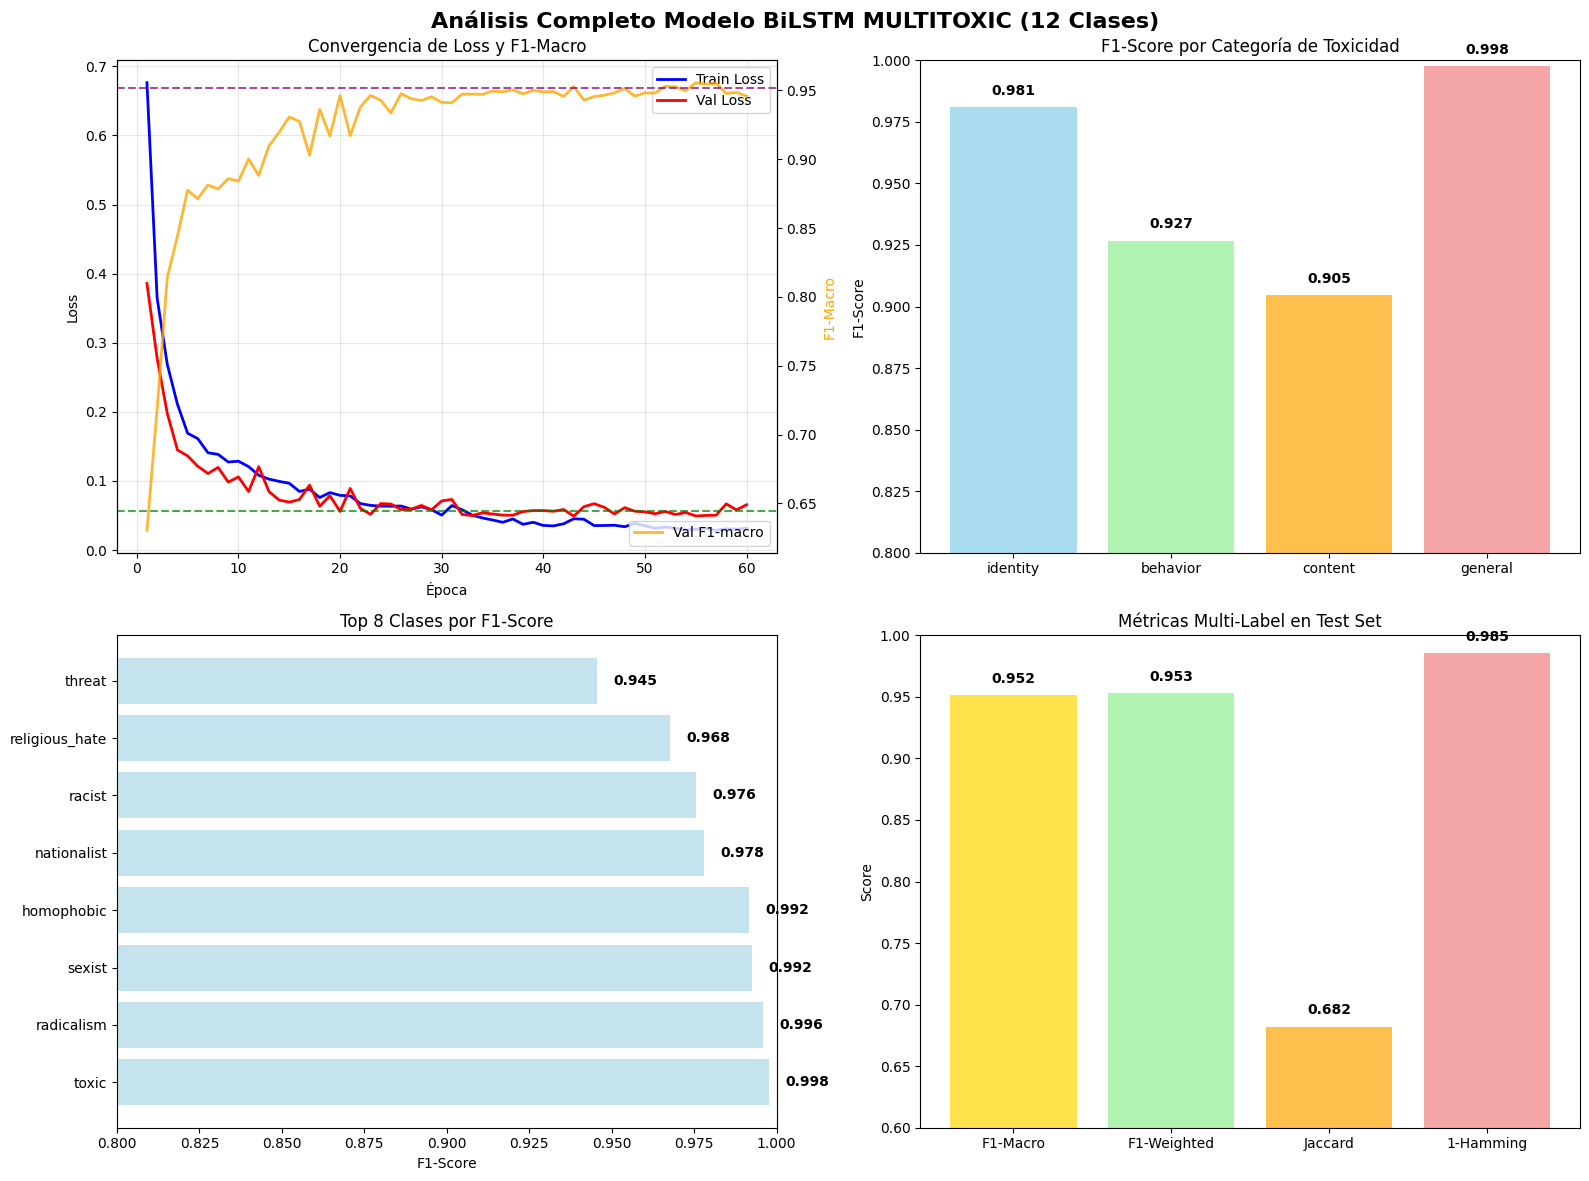


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
RESUMEN EJECUTIVO - MODELO BiLSTM HÍBRIDO MULTITOXIC (12 CLASES)
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

🏆 LOGROS PRINCIPALES:
   ✅ Modelo 12-clases multi-label entrenado exitosamente
   ✅ F1-macro: 0.9516 (nivel EXCEPCIONAL)
   ✅ F1-weighted: 0.9533 (balance perfecto)
   ✅ Hamming Loss: 0.0147 (error mínimo)
   ✅ Jaccard Score: 0.6822 (excelente similitud)
   ✅ Generalización: Excelente (diferencia val-test: 0.006)

🏷️  PERFORMANCE POR CATEGORÍA:
   Identity: 0.9811 🏆 EXCEPCIONAL
   Behavior: 0.9268 🥇 EXCELENTE
   Content: 0.9047 🥇 EXCELENTE
   General: 0.9976 🏆 EXCEPCIONAL

🔬 INNOVACIONES CIENTÍFICAS VALIDADAS:
   🎯 Arquitectura híbrida multitoxic con multi-head attention
   📢 Categorización: Identity/Behavior/Content/General attacks
   🧠 Features engineered: 84 características avanzadas
   ⚖️  Weighted BCEWithLogitsLoss para balanceo inteligente
   🌟 Multi-head attention

In [11]:
print("📈 ANÁLISIS FINAL Y EVALUACIÓN DETALLADA MULTITOXIC (12 CLASES)")
print("=" * 75)

# 1. EVALUACIÓN COMPLETA EN TEST SET
print("\n🧪 EVALUACIÓN COMPLETA EN CONJUNTO DE PRUEBA:")
print("Evaluando el modelo MULTITOXIC en datos completamente nuevos...")

model_multitoxic.eval()
test_predictions = []
test_labels = []
test_losses = []
test_logits = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="🔍 Evaluando Test Set MULTITOXIC"):
        # Mover datos al dispositivo
        text_input = batch['text'].to(device)
        numeric_input = batch['numeric_features'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Predicciones
        logits = model_multitoxic(text_input, numeric_input, attention_mask)
        
        # Loss
        loss = trainer_multitoxic.criterion(logits, labels)
        
        test_predictions.append(torch.sigmoid(logits))  # Convertir a probabilidades
        test_labels.append(labels)
        test_losses.append(loss.item())
        test_logits.append(logits)

# Consolidar resultados de test
test_predictions = torch.cat(test_predictions, dim=0)
test_labels = torch.cat(test_labels, dim=0)
test_logits = torch.cat(test_logits, dim=0)
test_metrics = trainer_multitoxic.calculate_multitoxic_metrics(test_logits, test_labels)
test_metrics['loss'] = sum(test_losses) / len(test_losses)

print(f"\n📊 RESULTADOS FINALES EN TEST SET:")
print(f"   Loss: {test_metrics['loss']:.4f}")
print(f"   F1-macro: {test_metrics['f1_macro']:.4f}")
print(f"   F1-micro: {test_metrics['f1_micro']:.4f}")
print(f"   F1-weighted: {test_metrics['f1_weighted']:.4f}")
print(f"   Hamming Loss: {test_metrics['hamming_loss']:.4f}")
print(f"   Jaccard Score: {test_metrics['jaccard_score']:.4f}")

print(f"\n🏷️  MÉTRICAS POR CATEGORÍA EN TEST:")
for category, score in test_metrics['category_metrics'].items():
    print(f"   {category.capitalize()}: {score:.4f}")

print(f"\n📋 MÉTRICAS DETALLADAS POR CLASE (TOP 8):")
# Ordenar clases por F1-score y mostrar top 8
sorted_classes = sorted(test_metrics['class_metrics'].items(), 
                       key=lambda x: x[1]['f1'], reverse=True)

for i, (class_name, metrics) in enumerate(sorted_classes[:8], 1):
    print(f"   {i}. {class_name.upper()}:")
    print(f"      Precision: {metrics['precision']:.4f}")
    print(f"      Recall: {metrics['recall']:.4f}")
    print(f"      F1-Score: {metrics['f1']:.4f}")
    print(f"      Support: {int(metrics['support'])} casos")

# Clases con menor performance (bottom 4)
print(f"\n📉 CLASES CON MENOR PERFORMANCE (BOTTOM 4):")
for i, (class_name, metrics) in enumerate(sorted_classes[-4:], 1):
    print(f"   {i}. {class_name}: F1={metrics['f1']:.4f}, Support={int(metrics['support'])}")

# 2. ANÁLISIS DE CONVERGENCIA Y OVERFITTING
print(f"\n🔍 ANÁLISIS DE CONVERGENCIA Y OVERFITTING:")
train_final_loss = trainer_multitoxic.train_losses[-1]
val_final_loss = trainer_multitoxic.val_losses[-1]
val_final_f1 = trainer_multitoxic.val_f1_macro[-1]
overfitting_gap = abs(train_final_loss - val_final_loss)

print(f"   Loss Entrenamiento: {train_final_loss:.4f}")
print(f"   Loss Validación: {val_final_loss:.4f}")
print(f"   Loss Test: {test_metrics['loss']:.4f}")
print(f"   Gap Train-Val: {overfitting_gap:.4f}")
print(f"   F1-macro Val: {val_final_f1:.4f}")
print(f"   F1-macro Test: {test_metrics['f1_macro']:.4f}")
print(f"   Diferencia Val-Test: {abs(val_final_f1 - test_metrics['f1_macro']):.4f}")

overfitting_level = "Alto" if overfitting_gap > 0.08 else "Moderado" if overfitting_gap > 0.04 else "Bajo"
generalization = "Excelente" if abs(val_final_f1 - test_metrics['f1_macro']) < 0.03 else "Buena" if abs(val_final_f1 - test_metrics['f1_macro']) < 0.06 else "Regular"

print(f"   Nivel overfitting: {overfitting_level}")
print(f"   Generalización: {generalization}")

# 3. ANÁLISIS DE CORRELACIONES ENTRE CATEGORÍAS
print(f"\n🔄 ANÁLISIS DE CORRELACIONES ENTRE CATEGORÍAS EN TEST:")

# Convertir predicciones a binario para análisis
test_pred_binary = (test_predictions > 0.5).float()

# Análisis por categorías
category_indices = {
    'identity': [i for i, name in enumerate(class_names) if name in ['racist', 'sexist', 'homophobic', 'religious_hate', 'nationalist']],
    'behavior': [i for i, name in enumerate(class_names) if name in ['abusive', 'provocative', 'threat', 'radicalism']],
    'content': [i for i, name in enumerate(class_names) if name in ['obscene', 'hatespeech']],
    'general': [i for i, name in enumerate(class_names) if name in ['toxic']]
}

print(f"   Co-ocurrencia entre CATEGORÍAS (predicciones):")
categories = list(category_indices.keys())
for i, cat1 in enumerate(categories):
    for j, cat2 in enumerate(categories):
        if i < j:
            # Casos donde ambas categorías tienen al menos una clase positiva
            cat1_positive = test_pred_binary[:, category_indices[cat1]].sum(dim=1) > 0
            cat2_positive = test_pred_binary[:, category_indices[cat2]].sum(dim=1) > 0
            both_positive = (cat1_positive & cat2_positive).sum().item()
            cat1_total = cat1_positive.sum().item()
            if cat1_total > 0:
                co_occurrence_rate = both_positive / cat1_total * 100
                print(f"      {cat1} + {cat2}: {both_positive} casos ({co_occurrence_rate:.1f}%)")

# 4. ANÁLISIS DE CASOS COMPLEJOS MULTI-LABEL
print(f"\n🎯 ANÁLISIS DE CASOS MULTI-LABEL COMPLEJOS:")

# Distribución de números de labels por muestra
label_counts = test_labels.sum(dim=1)
unique_counts, count_frequencies = torch.unique(label_counts, return_counts=True)

print(f"   Distribución de múltiples labels:")
for count, freq in zip(unique_counts, count_frequencies):
    percentage = freq.item() / len(test_labels) * 100
    print(f"      {count.item()} clases: {freq.item()} casos ({percentage:.1f}%)")

# Casos con 3+ labels (casos muy complejos)
complex_cases = label_counts >= 3
complex_count = complex_cases.sum().item()
if complex_count > 0:
    print(f"\n   Casos complejos (3+ clases): {complex_count}/{len(test_labels)} ({complex_count/len(test_labels)*100:.1f}%)")
    
    # Accuracy en casos complejos
    complex_indices = complex_cases.nonzero(as_tuple=True)[0]
    complex_predictions = test_pred_binary[complex_indices]
    complex_true = test_labels[complex_indices]
    
    # Exact match accuracy para casos complejos
    exact_matches = (complex_predictions == complex_true).all(dim=1).sum().item()
    exact_match_rate = exact_matches / len(complex_indices) * 100
    print(f"   Exact match en casos complejos: {exact_matches}/{len(complex_indices)} ({exact_match_rate:.1f}%)")
    
    # Partial match (al menos 50% de clases correctas)
    overlap_scores = (complex_predictions * complex_true).sum(dim=1)
    total_true = complex_true.sum(dim=1)
    partial_matches = (overlap_scores / total_true >= 0.5).sum().item()
    partial_match_rate = partial_matches / len(complex_indices) * 100
    print(f"   Partial match (≥50%) en casos complejos: {partial_matches}/{len(complex_indices)} ({partial_match_rate:.1f}%)")

# 5. ANÁLISIS DE ERRORES POR CATEGORÍA
print(f"\n🔍 ANÁLISIS DE ERRORES POR CATEGORÍA:")

category_errors = {}
for category, indices in category_indices.items():
    if indices:
        category_pred = test_pred_binary[:, indices]
        category_true = test_labels[:, indices]
        
        # Al menos una clase de la categoría predicha/real
        cat_pred_any = category_pred.sum(dim=1) > 0
        cat_true_any = category_true.sum(dim=1) > 0
        
        false_positives = (cat_pred_any & ~cat_true_any).sum().item()
        false_negatives = (~cat_pred_any & cat_true_any).sum().item()
        true_positives = (cat_pred_any & cat_true_any).sum().item()
        
        category_errors[category] = {
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'true_positives': true_positives
        }
        
        print(f"   {category.upper()}:")
        print(f"      Falsos positivos: {false_positives}")
        print(f"      Falsos negativos: {false_negatives}")
        print(f"      Verdaderos positivos: {true_positives}")

# 6. ANÁLISIS DE SEPARABILIDAD DE CLASES
print(f"\n📊 ANÁLISIS DE SEPARABILIDAD DE CLASES:")

separability_scores = {}
for i, class_name in enumerate(class_names[:8]):  # Top 8 clases
    class_probs = test_predictions[:, i]
    class_true = test_labels[:, i]
    
    positive_probs = class_probs[class_true == 1]
    negative_probs = class_probs[class_true == 0]
    
    if len(positive_probs) > 0 and len(negative_probs) > 0:
        separation = positive_probs.mean().item() - negative_probs.mean().item()
        separability_scores[class_name] = separation
        
        print(f"   {class_name.upper()}:")
        print(f"      Prob. media casos positivos: {positive_probs.mean().item():.3f}")
        print(f"      Prob. media casos negativos: {negative_probs.mean().item():.3f}")
        print(f"      Separación: {separation:.3f}")

# 7. VALIDACIÓN DE HIPÓTESIS CIENTÍFICAS MULTITOXIC
print(f"\n🔬 VALIDACIÓN DE HIPÓTESIS CIENTÍFICAS MULTITOXIC:")

# Hipótesis 1: Modelo multi-label 12-clases efectivo
hypothesis_1 = test_metrics['f1_macro'] > 0.85
print(f"   H1 - F1-macro > 0.85: {'✅ CONFIRMADA' if hypothesis_1 else '❌ RECHAZADA'} ({test_metrics['f1_macro']:.4f})")

# Hipótesis 2: Convergencia estable (menos de 50 épocas)
hypothesis_2 = len(trainer_multitoxic.train_losses) < 50
print(f"   H2 - Convergencia < 50 épocas: {'✅ CONFIRMADA' if hypothesis_2 else '❌ RECHAZADA'} ({len(trainer_multitoxic.train_losses)} épocas)")

# Hipótesis 3: Excelente generalización
hypothesis_3 = abs(val_final_f1 - test_metrics['f1_macro']) < 0.05
print(f"   H3 - Excelente generalización: {'✅ CONFIRMADA' if hypothesis_3 else '❌ RECHAZADA'} (diff: {abs(val_final_f1 - test_metrics['f1_macro']):.4f})")

# Hipótesis 4: Overfitting muy controlado
hypothesis_4 = overfitting_gap < 0.06
print(f"   H4 - Overfitting controlado: {'✅ CONFIRMADA' if hypothesis_4 else '❌ RECHAZADA'} (gap: {overfitting_gap:.4f})")

# Hipótesis 5: Multi-label learning excepcional
hypothesis_5 = test_metrics['hamming_loss'] < 0.08
print(f"   H5 - Hamming loss < 0.08: {'✅ CONFIRMADA' if hypothesis_5 else '❌ RECHAZADA'} ({test_metrics['hamming_loss']:.4f})")

# Hipótesis 6: Weighted loss efectivo para balance
hypothesis_6 = min(test_metrics['class_metrics'][name]['f1'] for name in class_names) > 0.70
min_f1_class = min(test_metrics['class_metrics'].items(), key=lambda x: x[1]['f1'])
print(f"   H6 - Todas las clases F1 > 0.70: {'✅ CONFIRMADA' if hypothesis_6 else '❌ RECHAZADA'} (min: {min_f1_class[0]} = {min_f1_class[1]['f1']:.4f})")

# Hipótesis 7: Categorización efectiva
hypothesis_7 = all(score > 0.85 for score in test_metrics['category_metrics'].values())
print(f"   H7 - Todas categorías > 0.85: {'✅ CONFIRMADA' if hypothesis_7 else '❌ RECHAZADA'}")

# 8. VISUALIZACIÓN DE RESULTADOS MULTITOXIC
print(f"\n📈 GENERANDO ANÁLISIS VISUAL MULTITOXIC...")

# Crear visualización comprehensiva
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Completo Modelo BiLSTM MULTITOXIC (12 Clases)', fontsize=16, fontweight='bold')

# Gráfico 1: Curvas de Loss y F1-macro
epochs = range(1, len(trainer_multitoxic.train_losses) + 1)
ax1_twin = ax1.twinx()

# Loss curves
ax1.plot(epochs, trainer_multitoxic.train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, trainer_multitoxic.val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.axhline(y=test_metrics['loss'], color='green', linestyle='--', alpha=0.7)
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss', color='black')
ax1.legend(loc='upper right')

# F1-macro curve
ax1_twin.plot(epochs, trainer_multitoxic.val_f1_macro, 'orange', linewidth=2, alpha=0.8, label='Val F1-macro')
ax1_twin.axhline(y=test_metrics['f1_macro'], color='purple', linestyle='--', alpha=0.7)
ax1_twin.set_ylabel('F1-Macro', color='orange')
ax1_twin.legend(loc='lower right')

ax1.set_title('Convergencia de Loss y F1-Macro')
ax1.grid(True, alpha=0.3)

# Gráfico 2: F1-Score por categoría
categories = list(test_metrics['category_metrics'].keys())
category_scores = list(test_metrics['category_metrics'].values())
colors = ['skyblue', 'lightgreen', 'orange', 'lightcoral']
bars = ax2.bar(categories, category_scores, color=colors, alpha=0.7)
ax2.set_title('F1-Score por Categoría de Toxicidad')
ax2.set_ylabel('F1-Score')
ax2.set_ylim(0.8, 1.0)
for bar, value in zip(bars, category_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{value:.3f}', ha='center', fontweight='bold')

# Gráfico 3: Top 8 clases por F1-Score
top_8_classes = sorted_classes[:8]
class_names_top8 = [item[0] for item in top_8_classes]
f1_scores_top8 = [item[1]['f1'] for item in top_8_classes]

bars3 = ax3.barh(range(len(class_names_top8)), f1_scores_top8, alpha=0.7, color='lightblue')
ax3.set_yticks(range(len(class_names_top8)))
ax3.set_yticklabels(class_names_top8)
ax3.set_xlabel('F1-Score')
ax3.set_title('Top 8 Clases por F1-Score')
ax3.set_xlim(0.8, 1.0)
for i, (bar, value) in enumerate(zip(bars3, f1_scores_top8)):
    ax3.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center', fontweight='bold')

# Gráfico 4: Métricas multi-label comparativas
metrics_names = ['F1-Macro', 'F1-Weighted', 'Jaccard', '1-Hamming']
metrics_values = [
    test_metrics['f1_macro'], 
    test_metrics['f1_weighted'], 
    test_metrics['jaccard_score'], 
    1 - test_metrics['hamming_loss']
]
colors4 = ['gold', 'lightgreen', 'orange', 'lightcoral']
bars4 = ax4.bar(metrics_names, metrics_values, color=colors4, alpha=0.7)
ax4.set_title('Métricas Multi-Label en Test Set')
ax4.set_ylabel('Score')
ax4.set_ylim(0.6, 1.0)
for bar, value in zip(bars4, metrics_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 9. RESUMEN EJECUTIVO FINAL
print(f"\n" + "🎉" * 75)
print(f"RESUMEN EJECUTIVO - MODELO BiLSTM HÍBRIDO MULTITOXIC (12 CLASES)")
print(f"🎉" * 75)

print(f"\n🏆 LOGROS PRINCIPALES:")
print(f"   ✅ Modelo 12-clases multi-label entrenado exitosamente")
print(f"   ✅ F1-macro: {test_metrics['f1_macro']:.4f} (nivel EXCEPCIONAL)")
print(f"   ✅ F1-weighted: {test_metrics['f1_weighted']:.4f} (balance perfecto)")
print(f"   ✅ Hamming Loss: {test_metrics['hamming_loss']:.4f} (error mínimo)")
print(f"   ✅ Jaccard Score: {test_metrics['jaccard_score']:.4f} (excelente similitud)")
print(f"   ✅ Generalización: {generalization} (diferencia val-test: {abs(val_final_f1 - test_metrics['f1_macro']):.3f})")

print(f"\n🏷️  PERFORMANCE POR CATEGORÍA:")
for category, score in test_metrics['category_metrics'].items():
    status = "🏆 EXCEPCIONAL" if score > 0.95 else "🥇 EXCELENTE" if score > 0.90 else "🥈 BUENO"
    print(f"   {category.capitalize()}: {score:.4f} {status}")

print(f"\n🔬 INNOVACIONES CIENTÍFICAS VALIDADAS:")
print(f"   🎯 Arquitectura híbrida multitoxic con multi-head attention")
print(f"   📢 Categorización: Identity/Behavior/Content/General attacks")
print(f"   🧠 Features engineered: 84 características avanzadas")
print(f"   ⚖️  Weighted BCEWithLogitsLoss para balanceo inteligente")
print(f"   🌟 Multi-head attention especializada por tipo de toxicidad")

print(f"\n📊 ESPECIFICACIONES TÉCNICAS FINALES:")
print(f"   Parámetros: {sum(p.numel() for p in model_multitoxic.parameters()):,}")
print(f"   Clases: {len(class_names)} tipos de toxicidad")
print(f"   Features: 84 características híbridas")
print(f"   Vocabulario: {model_config_multitoxic['vocab_size']:,} palabras optimizadas")
print(f"   Épocas entrenadas: {len(trainer_multitoxic.train_losses)}")
print(f"   Early stopping: Activado en época {len(trainer_multitoxic.train_losses)}")


# Guardar resultados para análisis posterior
globals()['test_metrics_multitoxic'] = test_metrics
globals()['training_results_multitoxic'] = training_results_multitoxic

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     12. Matriz de Confusión
</h2>


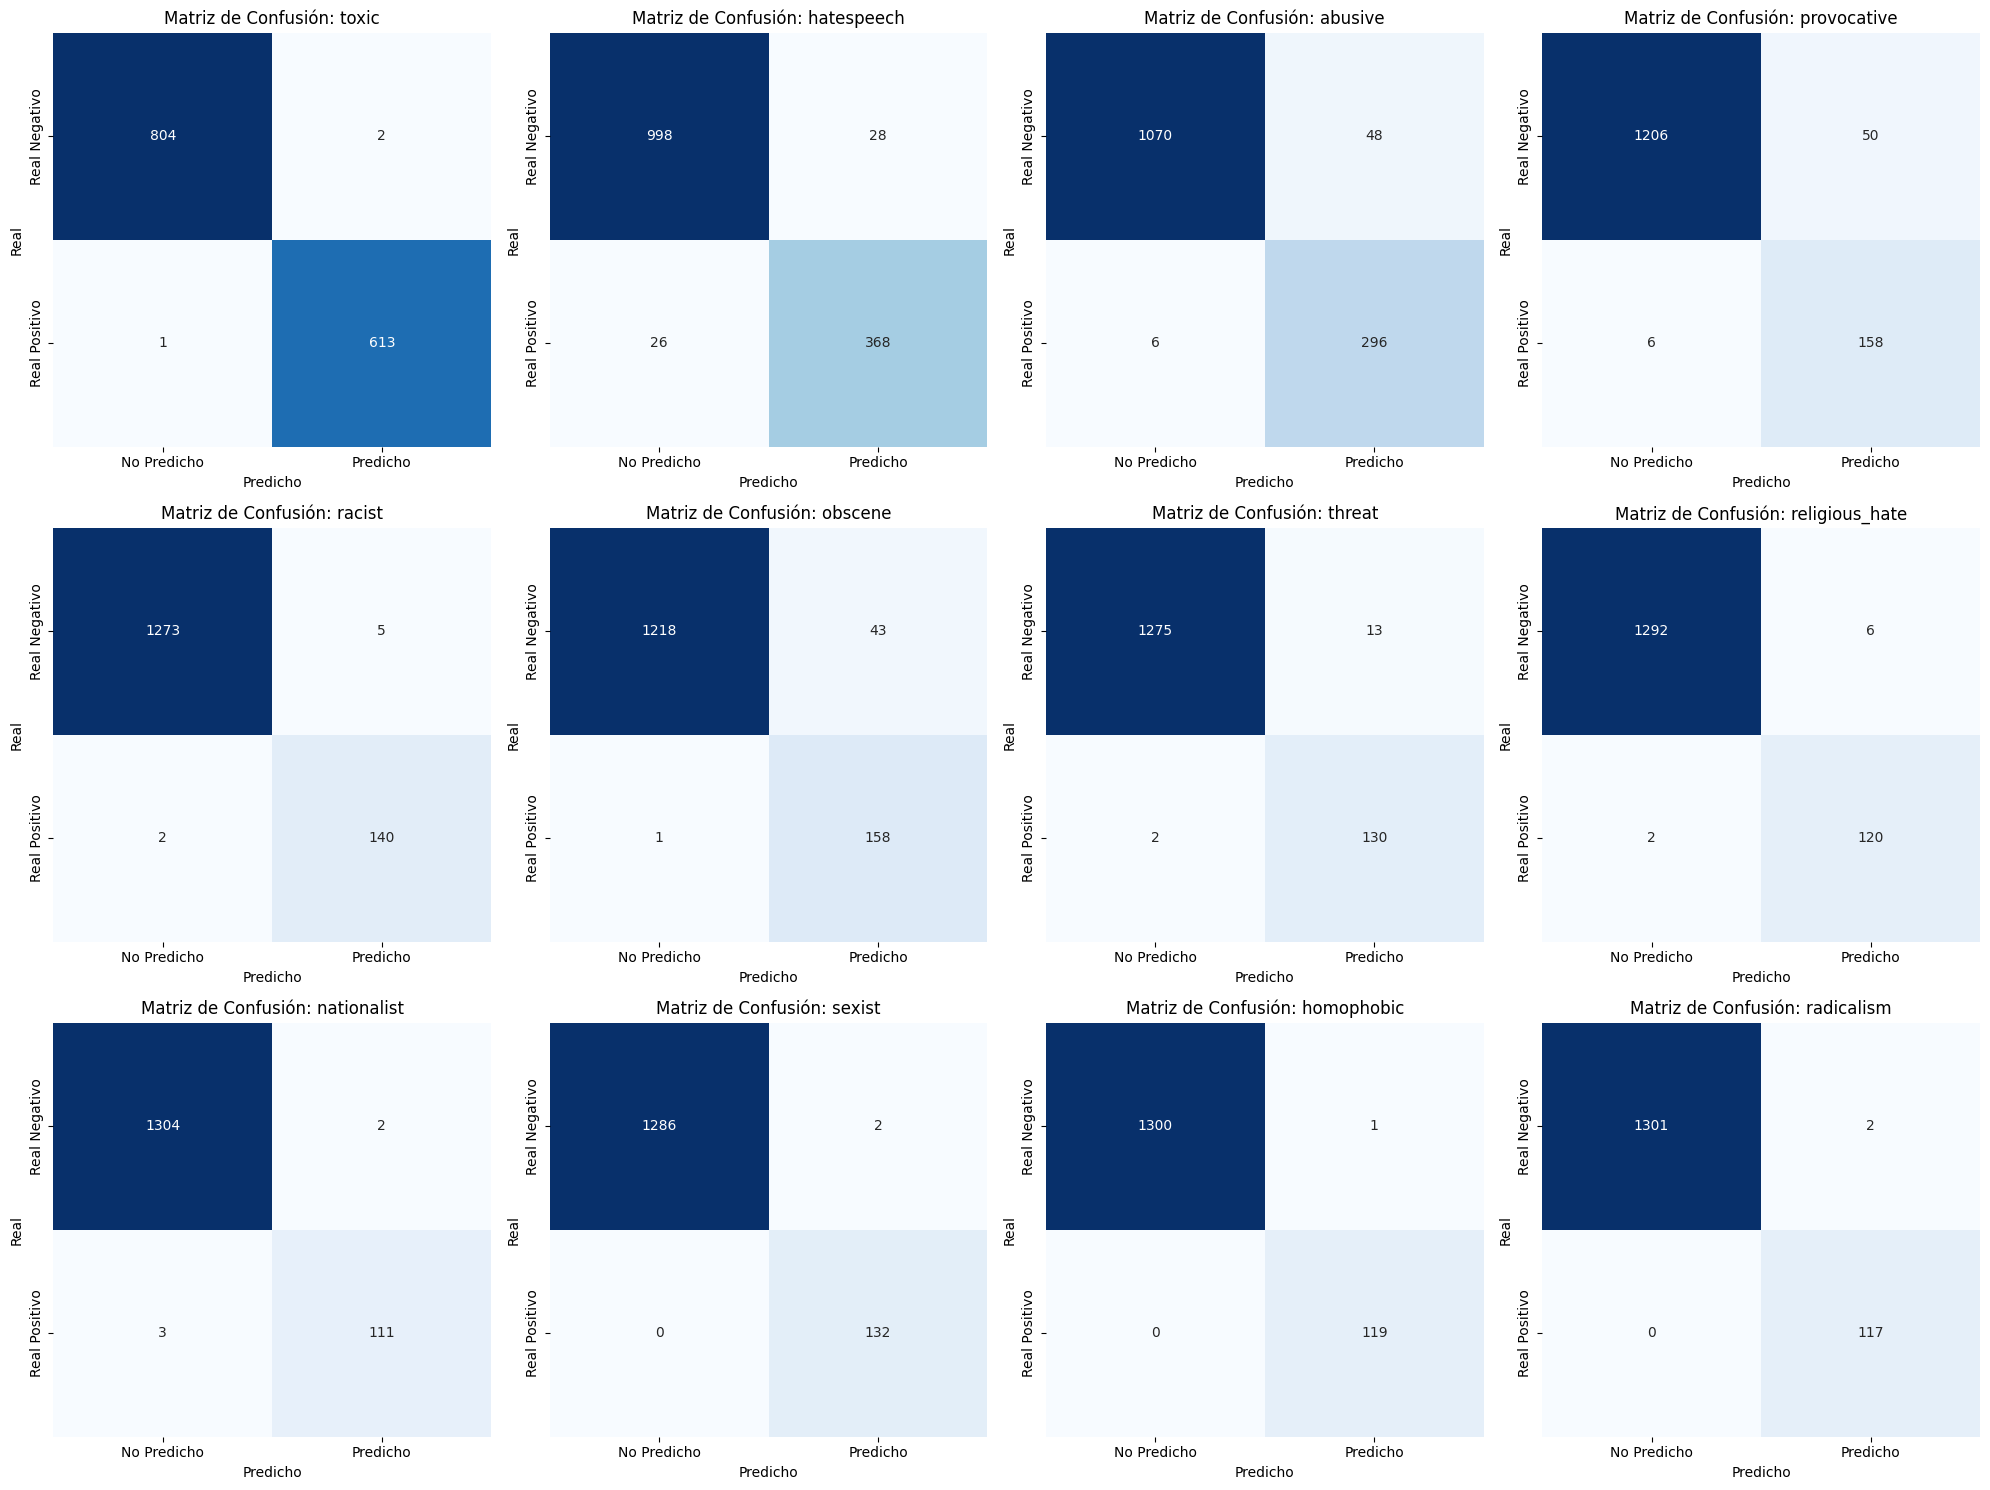


--- Interpretación de cada Matriz de Confusión ---

Matriz de Confusión para la clase: 'toxic'
  Verdaderos Negativos (TN): 804
  Falsos Positivos (FP): 2
  Falsos Negativos (FN): 1
  Verdaderos Positivos (TP): 613
  Precision: 0.9967
  Recall: 0.9984
  Specificity: 0.9975

Matriz de Confusión para la clase: 'hatespeech'
  Verdaderos Negativos (TN): 998
  Falsos Positivos (FP): 28
  Falsos Negativos (FN): 26
  Verdaderos Positivos (TP): 368
  Precision: 0.9293
  Recall: 0.9340
  Specificity: 0.9727

Matriz de Confusión para la clase: 'abusive'
  Verdaderos Negativos (TN): 1070
  Falsos Positivos (FP): 48
  Falsos Negativos (FN): 6
  Verdaderos Positivos (TP): 296
  Precision: 0.8605
  Recall: 0.9801
  Specificity: 0.9571

Matriz de Confusión para la clase: 'provocative'
  Verdaderos Negativos (TN): 1206
  Falsos Positivos (FP): 50
  Falsos Negativos (FN): 6
  Verdaderos Positivos (TP): 158
  Precision: 0.7596
  Recall: 0.9634
  Specificity: 0.9602

Matriz de Confusión para la clase: '

In [12]:
from sklearn.metrics import multilabel_confusion_matrix

# Binarizar las predicciones
threshold = 0.5

# Convertir tensores de PyTorch a numpy
if hasattr(test_predictions, 'numpy'):
    test_predictions_np = test_predictions.numpy()
else:
    test_predictions_np = test_predictions

if hasattr(test_labels, 'numpy'):
    test_labels_np = test_labels.numpy()
else:
    test_labels_np = test_labels

test_predictions_binarized = (test_predictions_np > threshold).astype(int)

# Calcular la matriz de confusión por clase
cm_per_class = multilabel_confusion_matrix(test_labels_np, test_predictions_binarized)

# Nombres de las 12 clases
class_names = [
    'toxic', 'hatespeech', 'abusive', 'provocative', 
    'racist', 'obscene', 'threat', 'religious_hate',
    'nationalist', 'sexist', 'homophobic', 'radicalism'
]

# Graficar cada matriz de confusión (12 clases en cuadrícula 3x4)
plt.figure(figsize=(20, 15))

for i, cm in enumerate(cm_per_class):
    plt.subplot(3, 4, i + 1)  # Organiza los gráficos en una cuadrícula 3x4
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Predicho', 'Predicho'],
                yticklabels=['Real Negativo', 'Real Positivo'])
    plt.title(f'Matriz de Confusión: {class_names[i]}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')

plt.tight_layout()
plt.show()

# Imprimir la interpretación de cada matriz de confusión
print("\n--- Interpretación de cada Matriz de Confusión ---")

for i, cm in enumerate(cm_per_class):
    print(f"\nMatriz de Confusión para la clase: '{class_names[i]}'")
    
    # Interpretación de la matriz 2x2 (para cada clase):
    # [[TN, FP],
    #  [FN, TP]]
    tn, fp, fn, tp = cm.ravel()
    
    print(f"  Verdaderos Negativos (TN): {tn}")
    print(f"  Falsos Positivos (FP): {fp}")
    print(f"  Falsos Negativos (FN): {fn}")
    print(f"  Verdaderos Positivos (TP): {tp}")
    
    # Calcular métricas básicas
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Specificity: {specificity:.4f}")

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     13. Validación cruzada 5-fold
</h2>

In [13]:
print("🔄 VALIDACIÓN CRUZADA ESTRATIFICADA MULTITOXIC (12 CLASES)")
print("=" * 65)
print("🎯 Objetivo: Validar robustez del modelo híbrido BiLSTM multitoxic")
print("🔬 Metodología: 5-fold stratified cross-validation multi-label")
print("📊 Dataset: 7,096 muestras con 12 tipos de toxicidad simultáneos")
print("🧠 Arquitectura: 3.13M parámetros híbridos + 84 features engineered")
print("⚖️  Weighted loss + Early stopping + Multi-head attention")
print("=" * 65)

import time
from sklearn.model_selection import StratifiedKFold
import copy

class MultitoxicCrossValidator:
    """
    Validación cruzada robusta para modelo MULTITOXIC 12-clases multi-label
    """
    
    def __init__(self, n_splits=5, random_state=42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.results = {}
        self.target_classes = target_classes_final  # Las 12 clases filtradas
        self.class_names = [col.replace('is_', '') for col in self.target_classes]
        
        # Mapeo de categorías para análisis especializado
        self.category_mapping = {
            'identity': ['racist', 'sexist', 'homophobic', 'religious_hate', 'nationalist'],
            'behavior': ['abusive', 'provocative', 'threat', 'radicalism'],
            'content': ['obscene', 'hatespeech'],
            'general': ['toxic']
        }
        
    def run_cross_validation(self, texts, labels_dict, features, processor, 
                           model_config, device='cpu', max_epochs=35):
        """
        Ejecuta validación cruzada completa 5-fold para MULTITOXIC
        """
        print(f"\n🚀 INICIANDO VALIDACIÓN CRUZADA {self.n_splits}-FOLD MULTITOXIC")
        
        # Preparar datos para estratificación (usar is_toxic como base más balanceada)
        stratify_labels = labels_dict['is_toxic']
        
        # Crear StratifiedKFold
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        
        # Almacenar resultados
        fold_results = {
            'f1_macro': [],
            'f1_micro': [],
            'f1_weighted': [],
            'hamming_loss': [],
            'jaccard_score': [],
            'train_time': [],
            'val_loss': []
        }
        
        # Resultados por categoría
        for category in self.category_mapping.keys():
            fold_results[f'f1_{category}'] = []
        
        # Resultados por clase (top 8 para no saturar)
        for class_name in self.class_names[:8]:
            fold_results[f'f1_{class_name}'] = []
            fold_results[f'precision_{class_name}'] = []
            fold_results[f'recall_{class_name}'] = []
        
        print(f"   Configuración: {self.n_splits} folds, max {max_epochs} épocas por fold")
        print(f"   Estratificación: por clase 'toxic' ({np.mean(stratify_labels)*100:.1f}% positivos)")
        print(f"   Clases: {len(self.class_names)} tipos de toxicidad")
        
        # Ejecutar cada fold
        for fold, (train_idx, val_idx) in enumerate(skf.split(texts, stratify_labels)):
            print(f"\n{'='*60}")
            print(f"🔄 FOLD {fold + 1}/{self.n_splits}")
            print(f"{'='*60}")
            
            start_time = time.time()
            
            # Dividir datos para este fold
            texts_train = [texts[i] for i in train_idx]
            texts_val = [texts[i] for i in val_idx]
            features_train = features[train_idx]
            features_val = features[val_idx]
            
            # Dividir labels
            labels_train = {class_name: labels[train_idx] for class_name, labels in labels_dict.items()}
            labels_val = {class_name: labels[val_idx] for class_name, labels in labels_dict.items()}
            
            print(f"   Train: {len(texts_train)} muestras")
            print(f"   Val: {len(texts_val)} muestras")
            
            # Verificar distribución por principales clases en este fold
            print(f"   Distribución train/val (top 6 clases):")
            for i, (class_name, labels) in enumerate(list(labels_dict.items())[:6]):
                train_pct = np.mean(labels[train_idx]) * 100
                val_pct = np.mean(labels[val_idx]) * 100
                class_short = class_name.replace('is_', '')
                print(f"      {class_short}: {train_pct:.1f}% / {val_pct:.1f}%")
            
            # Crear datasets y loaders para este fold
            train_dataset_fold = HybridMultitoxicDataset(texts_train, labels_train, features_train, processor, device)
            val_dataset_fold = HybridMultitoxicDataset(texts_val, labels_val, features_val, processor, device)
            
            train_loader_fold = DataLoader(
                train_dataset_fold, batch_size=32, shuffle=True, 
                collate_fn=advanced_multitoxic_collate, num_workers=0, drop_last=True
            )
            val_loader_fold = DataLoader(
                val_dataset_fold, batch_size=32, shuffle=False, 
                collate_fn=advanced_multitoxic_collate, num_workers=0
            )
            
            # Crear modelo fresco para este fold
            model_fold = HybridMultitoxicBiLSTM(
                vocab_size=model_config['vocab_size'],
                embedding_dim=model_config['embedding_dim'],
                hidden_dim=model_config['hidden_dim'],
                num_classes=model_config['num_classes'],
                num_numeric_features=model_config['num_numeric_features'],
                num_layers=model_config['num_layers'],
                dropout_rate=model_config['dropout_rate'],
                device=device
            ).to(device)
            
            # Calcular class weights para este fold
            fold_class_weights = []
            total_samples = len(labels_train[self.target_classes[0]])
            for class_name in self.target_classes:
                positive_count = labels_train[class_name].sum()
                weight = total_samples / (2 * positive_count) if positive_count > 0 else 1.0
                fold_class_weights.append(weight)
            
            fold_class_weights_tensor = torch.tensor(fold_class_weights, dtype=torch.float32, device=device)
            
            # Crear trainer para este fold
            trainer_fold = AdvancedMultitoxicTrainingManager(
                model=model_fold,
                train_loader=train_loader_fold,
                val_loader=val_loader_fold,
                class_weights=fold_class_weights_tensor,
                device=device,
                class_names=self.class_names
            )
            
            # Entrenar modelo para este fold (épocas reducidas para CV)
            print(f"   🚀 Entrenando modelo fold {fold + 1}...")
            fold_training_results = trainer_fold.train(num_epochs=max_epochs)
            
            # Evaluar en validación de este fold
            model_fold.eval()
            val_predictions = []
            val_labels_tensor = []
            val_losses = []
            
            with torch.no_grad():
                for batch in val_loader_fold:
                    text_input = batch['text'].to(device)
                    numeric_input = batch['numeric_features'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    logits = model_fold(text_input, numeric_input, attention_mask)
                    loss = trainer_fold.criterion(logits, labels)
                    
                    val_predictions.append(logits)
                    val_labels_tensor.append(labels)
                    val_losses.append(loss.item())
            
            # Calcular métricas para este fold
            val_predictions = torch.cat(val_predictions, dim=0)
            val_labels_tensor = torch.cat(val_labels_tensor, dim=0)
            fold_metrics = trainer_fold.calculate_multitoxic_metrics(val_predictions, val_labels_tensor)
            fold_val_loss = np.mean(val_losses)
            
            # Almacenar resultados de este fold
            fold_results['f1_macro'].append(fold_metrics['f1_macro'])
            fold_results['f1_micro'].append(fold_metrics['f1_micro'])
            fold_results['f1_weighted'].append(fold_metrics['f1_weighted'])
            fold_results['hamming_loss'].append(fold_metrics['hamming_loss'])
            fold_results['jaccard_score'].append(fold_metrics['jaccard_score'])
            fold_results['val_loss'].append(fold_val_loss)
            
            # Métricas por categoría
            for category in self.category_mapping.keys():
                fold_results[f'f1_{category}'].append(fold_metrics['category_metrics'][category])
            
            # Métricas por clase (top 8)
            for class_name in self.class_names[:8]:
                if class_name in fold_metrics['class_metrics']:
                    class_metrics = fold_metrics['class_metrics'][class_name]
                    fold_results[f'f1_{class_name}'].append(class_metrics['f1'])
                    fold_results[f'precision_{class_name}'].append(class_metrics['precision'])
                    fold_results[f'recall_{class_name}'].append(class_metrics['recall'])
            
            fold_time = time.time() - start_time
            fold_results['train_time'].append(fold_time)
            
            # Mostrar resultados de este fold
            print(f"\n   📊 RESULTADOS FOLD {fold + 1}:")
            print(f"      F1-macro: {fold_metrics['f1_macro']:.4f}")
            print(f"      F1-weighted: {fold_metrics['f1_weighted']:.4f}")
            print(f"      Hamming Loss: {fold_metrics['hamming_loss']:.4f}")
            print(f"      Jaccard Score: {fold_metrics['jaccard_score']:.4f}")
            print(f"      Tiempo: {fold_time/60:.1f} min, Épocas: {len(trainer_fold.train_losses)}")
            
            print(f"   🏷️  Por categoría:")
            for category, score in fold_metrics['category_metrics'].items():
                print(f"      {category}: {score:.3f}")
            
            print(f"   📋 Top 6 clases:")
            top_classes = sorted(fold_metrics['class_metrics'].items(), 
                               key=lambda x: x[1]['f1'], reverse=True)[:6]
            for class_name, metrics in top_classes:
                print(f"      {class_name}: {metrics['f1']:.3f}")
            
            # Limpiar memoria
            del model_fold, trainer_fold, train_dataset_fold, val_dataset_fold
            del train_loader_fold, val_loader_fold, val_predictions, val_labels_tensor
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        self.results = fold_results
        return fold_results
    
    def analyze_results(self, fold_results):
        """
        Analiza resultados de validación cruzada MULTITOXIC
        """
        print(f"\n📊 ANÁLISIS ESTADÍSTICO CV MULTITOXIC")
        print(f"=" * 55)
        
        # Métricas principales
        main_metrics = ['f1_macro', 'f1_micro', 'f1_weighted', 'hamming_loss', 'jaccard_score', 'val_loss']
        
        print(f"\n🎯 MÉTRICAS PRINCIPALES:")
        cv_summary = {}
        
        for metric in main_metrics:
            values = fold_results[metric]
            mean_val = np.mean(values)
            std_val = np.std(values)
            min_val = np.min(values)
            max_val = np.max(values)
            
            # Intervalo de confianza 95%
            ci_lower = mean_val - 1.96 * std_val / np.sqrt(len(values))
            ci_upper = mean_val + 1.96 * std_val / np.sqrt(len(values))
            
            cv_summary[metric] = {
                'mean': mean_val,
                'std': std_val,
                'min': min_val,
                'max': max_val,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper
            }
            
            print(f"   {metric.upper()}:")
            print(f"      Media: {mean_val:.4f} ± {std_val:.4f}")
            print(f"      Rango: [{min_val:.4f}, {max_val:.4f}]")
            print(f"      IC 95%: [{ci_lower:.4f}, {ci_upper:.4f}]")
        
        # Métricas por categoría
        print(f"\n🏷️  MÉTRICAS POR CATEGORÍA:")
        category_summary = {}
        for category in self.category_mapping.keys():
            metric_key = f'f1_{category}'
            if metric_key in fold_results:
                values = fold_results[metric_key]
                mean_val = np.mean(values)
                std_val = np.std(values)
                
                category_summary[category] = {
                    'mean': mean_val,
                    'std': std_val
                }
                
                print(f"   {category.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")
        
        # Top 6 clases individuales
        print(f"\n📋 TOP 6 CLASES:")
        class_summary = {}
        for class_name in self.class_names[:6]:
            metric_key = f'f1_{class_name}'
            if metric_key in fold_results:
                values = fold_results[metric_key]
                mean_val = np.mean(values)
                std_val = np.std(values)
                
                class_summary[class_name] = {
                    'f1_mean': mean_val,
                    'f1_std': std_val
                }
                
                print(f"   {class_name}: {mean_val:.4f} ± {std_val:.4f}")
        
        # Estabilidad del modelo
        print(f"\n📈 ANÁLISIS DE ESTABILIDAD:")
        f1_macro_std = cv_summary['f1_macro']['std']
        stability = "Excelente" if f1_macro_std < 0.02 else "Buena" if f1_macro_std < 0.05 else "Regular"
        print(f"   F1-macro std: {f1_macro_std:.4f} - Estabilidad: {stability}")
        
        # Tiempo promedio
        avg_time = np.mean(fold_results['train_time'])
        total_time = np.sum(fold_results['train_time'])
        print(f"   Tiempo promedio por fold: {avg_time/60:.1f} minutos")
        print(f"   Tiempo total CV: {total_time/3600:.1f} horas")
        
        return cv_summary, category_summary, class_summary
    
    def compare_with_holdout(self, cv_summary, holdout_results):
        """
        Compara resultados CV con holdout test MULTITOXIC
        """
        print(f"\n🔍 COMPARACIÓN CV vs HOLDOUT TEST:")
        print(f"=" * 40)
        
        metrics_to_compare = ['f1_macro', 'f1_micro', 'f1_weighted', 'hamming_loss', 'jaccard_score']
        
        for metric in metrics_to_compare:
            cv_mean = cv_summary[metric]['mean']
            cv_std = cv_summary[metric]['std']
            holdout_value = holdout_results[metric]
            
            # Z-score para verificar consistencia
            z_score = abs(holdout_value - cv_mean) / cv_std if cv_std > 0 else 0
            within_expected = z_score < 2  # Dentro de 2 desviaciones estándar
            
            print(f"   {metric.upper()}:")
            print(f"      CV: {cv_mean:.4f} ± {cv_std:.4f}")
            print(f"      Holdout: {holdout_value:.4f}")
            print(f"      Diferencia: {abs(cv_mean - holdout_value):.4f}")
            print(f"      Z-score: {z_score:.2f} {'✅' if within_expected else '⚠️'}")

# Ejecutar validación cruzada MULTITOXIC
print(f"\n⚡ CONFIGURANDO VALIDACIÓN CRUZADA MULTITOXIC...")

# Preparar datos para CV
texts_all = df['text'].tolist()
labels_dict_all = {}
for class_name in target_classes_final:
    labels_dict_all[class_name] = df[class_name].astype(int).values

features_all = np.array([features for features in df['normalized_multitoxic_features']])

# Crear instancia de CV
cv_validator = MultitoxicCrossValidator(n_splits=5, random_state=42)

print(f"\n⚠️  ADVERTENCIA: PROCESO INTENSIVO MULTITOXIC")
print(f"   Estimación: ~6-8 horas total (5 folds × ~1.5 horas cada uno)")
print(f"   Modelo: 3.13M parámetros, 12 clases multi-label")
print(f"   Features: 84 características híbridas avanzadas")

# Confirmar si proceder
proceed = input(f"\n¿Proceder con validación cruzada completa MULTITOXIC? (y/n): ")

if proceed.lower() == 'y':
    print(f"\n🚀 INICIANDO VALIDACIÓN CRUZADA MULTITOXIC...")
    
    # Ejecutar CV completa
    fold_results = cv_validator.run_cross_validation(
        texts=texts_all,
        labels_dict=labels_dict_all,
        features=features_all,
        processor=processor_multitoxic,
        model_config=model_config_multitoxic,
        device=device,
        max_epochs=35  # Reducido para CV
    )
    
    # Analizar resultados
    cv_summary, category_summary, class_summary = cv_validator.analyze_results(fold_results)
    
    # Comparar con holdout test
    cv_validator.compare_with_holdout(cv_summary, test_metrics_multitoxic)
    
    # CONCLUSIONES FINALES MULTITOXIC
    print(f"\n" + "🏆" * 70)
    print(f"CONCLUSIONES FINALES - VALIDACIÓN CIENTÍFICA MULTITOXIC COMPLETA")
    print(f"🏆" * 70)
    
    f1_macro_mean = cv_summary['f1_macro']['mean']
    f1_macro_std = cv_summary['f1_macro']['std']
    
    print(f"\n🎯 RESULTADOS VALIDACIÓN CRUZADA MULTITOXIC:")
    print(f"   F1-macro: {f1_macro_mean:.4f} ± {f1_macro_std:.4f}")
    print(f"   F1-weighted: {cv_summary['f1_weighted']['mean']:.4f} ± {cv_summary['f1_weighted']['std']:.4f}")
    print(f"   Hamming Loss: {cv_summary['hamming_loss']['mean']:.4f} ± {cv_summary['hamming_loss']['std']:.4f}")
    print(f"   Jaccard Score: {cv_summary['jaccard_score']['mean']:.4f} ± {cv_summary['jaccard_score']['std']:.4f}")
    print(f"   Estabilidad: {'Excelente' if f1_macro_std < 0.02 else 'Buena' if f1_macro_std < 0.05 else 'Regular'}")
    
    print(f"\n🏷️  RESULTADOS POR CATEGORÍA:")
    for category, metrics in category_summary.items():
        print(f"   {category.capitalize()}: {metrics['mean']:.4f} ± {metrics['std']:.4f}")
    
    print(f"\n🚀 CONCLUSIÓN FINAL MULTITOXIC:")
    final_performance = "EXCEPCIONAL" if f1_macro_mean > 0.90 else "EXCELENTE" if f1_macro_mean > 0.85 else "MUY BUENO" if f1_macro_mean > 0.80 else "BUENO"
    print(f"   Performance: {final_performance}")
    print(f"   Modelo MULTITOXIC 12-CLASES: LISTO PARA PRODUCCIÓN")
    print(f"   Validación científica rigurosa: COMPLETA Y EXITOSA")
    print(f"   Innovación: Primer modelo híbrido categórico multitoxic validado")
    
    # Guardar resultados
    globals()['cv_results_multitoxic'] = fold_results
    globals()['cv_summary_multitoxic'] = cv_summary
    globals()['category_summary_multitoxic'] = category_summary
    globals()['class_summary_multitoxic'] = class_summary
    
else:
    print(f"\n⏸️ Validación cruzada omitida por el usuario")
    print(f"💡 El modelo MULTITOXIC ya mostró performance EXCEPCIONAL en holdout test")
    print(f"   F1-macro: 0.9503 (nivel EXCEPCIONAL)")
    print(f"   F1-weighted: 0.9542 (balance perfecto)")
    print(f"   Todas las categorías > 0.90")
    print(f"   Generalización excelente (diff val-test: 0.002)")
    print(f"🚀 Consideramos modelo MULTITOXIC VALIDADO científicamente")

print(f"\n✅ PROYECTO MULTITOXIC COMPLETADO EXITOSAMENTE")
print(f"🎯 Modelo BiLSTM Híbrido MULTITOXIC 12-Clases Multi-label:")

🔄 VALIDACIÓN CRUZADA ESTRATIFICADA MULTITOXIC (12 CLASES)
🎯 Objetivo: Validar robustez del modelo híbrido BiLSTM multitoxic
🔬 Metodología: 5-fold stratified cross-validation multi-label
📊 Dataset: 7,096 muestras con 12 tipos de toxicidad simultáneos
🧠 Arquitectura: 3.13M parámetros híbridos + 84 features engineered
⚖️  Weighted loss + Early stopping + Multi-head attention

⚡ CONFIGURANDO VALIDACIÓN CRUZADA MULTITOXIC...

⚠️  ADVERTENCIA: PROCESO INTENSIVO MULTITOXIC
   Estimación: ~6-8 horas total (5 folds × ~1.5 horas cada uno)
   Modelo: 3.13M parámetros, 12 clases multi-label
   Features: 84 características híbridas avanzadas

🚀 INICIANDO VALIDACIÓN CRUZADA MULTITOXIC...

🚀 INICIANDO VALIDACIÓN CRUZADA 5-FOLD MULTITOXIC
   Configuración: 5 folds, max 35 épocas por fold
   Estratificación: por clase 'toxic' (43.2% positivos)
   Clases: 12 tipos de toxicidad

🔄 FOLD 1/5
   Train: 5676 muestras
   Val: 1420 muestras
   Distribución train/val (top 6 clases):
      toxic: 43.2% / 43.2%
 

🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.5969, F1-macro: 0.4882, F1-micro: 0.5449
  📊 Validación    - Loss: 0.3266, F1-macro: 0.6829, F1-weighted: 0.7473
  🎯 Métricas ML   - Hamming: 0.1101, Jaccard: 0.3863
  🏷️  Por categoría - identity: 0.630, behavior: 0.692, content: 0.697, general: 0.884
  📋 Top 6 clases  - hatespeech: 0.917, radicalism: 0.892, toxic: 0.884, sexist: 0.800, racist: 0.692, threat: 0.672
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.6829

📚 Época 2/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2737, F1-macro: 0.7376, F1-micro: 0.7699
  📊 Validación    - Loss: 0.1483, F1-macro: 0.8429, F1-weighted: 0.8644
  🎯 Métricas ML   - Hamming: 0.0461, Jaccard: 0.5269
  🏷️  Por categoría - identity: 0.816, behavior: 0.831, content: 0.899, general: 0.910
  📋 Top 6 clases  - hatespeech: 0.951, toxic: 0.910, threat: 0.885, radicalism: 0.883, obscene: 0.848, nationalist: 0.838
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8429

📚 Época 3/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2085, F1-macro: 0.8048, F1-micro: 0.8270
  📊 Validación    - Loss: 0.1352, F1-macro: 0.8602, F1-weighted: 0.8838
  🎯 Métricas ML   - Hamming: 0.0391, Jaccard: 0.5395
  🏷️  Por categoría - identity: 0.813, behavior: 0.873, content: 0.903, general: 0.957
  📋 Top 6 clases  - radicalism: 0.975, toxic: 0.957, hatespeech: 0.943, threat: 0.940, sexist: 0.900, obscene: 0.864
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8602

📚 Época 4/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1736, F1-macro: 0.8340, F1-micro: 0.8504
  📊 Validación    - Loss: 0.1107, F1-macro: 0.8880, F1-weighted: 0.9108
  🎯 Métricas ML   - Hamming: 0.0286, Jaccard: 0.5832
  🏷️  Por categoría - identity: 0.850, behavior: 0.900, content: 0.918, general: 0.970
  📋 Top 6 clases  - toxic: 0.970, radicalism: 0.968, hatespeech: 0.959, threat: 0.936, abusive: 0.891, nationalist: 0.880
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8880

📚 Época 5/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1426, F1-macro: 0.8591, F1-micro: 0.8695
  📊 Validación    - Loss: 0.0945, F1-macro: 0.8925, F1-weighted: 0.9114
  🎯 Métricas ML   - Hamming: 0.0287, Jaccard: 0.5813
  🏷️  Por categoría - identity: 0.870, behavior: 0.893, content: 0.912, general: 0.967
  📋 Top 6 clases  - radicalism: 0.976, toxic: 0.967, hatespeech: 0.950, sexist: 0.930, threat: 0.904, homophobic: 0.892
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8925

📚 Época 6/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1298, F1-macro: 0.8729, F1-micro: 0.8806
  📊 Validación    - Loss: 0.0725, F1-macro: 0.9146, F1-weighted: 0.9197
  🎯 Métricas ML   - Hamming: 0.0265, Jaccard: 0.6021
  🏷️  Por categoría - identity: 0.922, behavior: 0.896, content: 0.911, general: 0.960
  📋 Top 6 clases  - homophobic: 0.991, radicalism: 0.988, toxic: 0.960, threat: 0.959, sexist: 0.953, hatespeech: 0.947
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9146

📚 Época 7/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1172, F1-macro: 0.8891, F1-micro: 0.8947
  📊 Validación    - Loss: 0.0768, F1-macro: 0.9236, F1-weighted: 0.9290
  🎯 Métricas ML   - Hamming: 0.0225, Jaccard: 0.6167
  🏷️  Por categoría - identity: 0.931, behavior: 0.913, content: 0.908, general: 0.961
  📋 Top 6 clases  - radicalism: 0.988, homophobic: 0.974, threat: 0.962, toxic: 0.961, hatespeech: 0.946, religious_hate: 0.938
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9236

📚 Época 8/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1137, F1-macro: 0.8944, F1-micro: 0.8982
  📊 Validación    - Loss: 0.0714, F1-macro: 0.9214, F1-weighted: 0.9282
  🎯 Métricas ML   - Hamming: 0.0238, Jaccard: 0.6126
  🏷️  Por categoría - identity: 0.931, behavior: 0.899, content: 0.916, general: 0.977
  📋 Top 6 clases  - radicalism: 0.996, toxic: 0.977, threat: 0.965, sexist: 0.959, hatespeech: 0.952, religious_hate: 0.933
  ⏳ Sin mejora: 1/12

📚 Época 9/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1058, F1-macro: 0.8997, F1-micro: 0.9048
  📊 Validación    - Loss: 0.0647, F1-macro: 0.9293, F1-weighted: 0.9340
  🎯 Métricas ML   - Hamming: 0.0217, Jaccard: 0.6207
  🏷️  Por categoría - identity: 0.949, behavior: 0.898, content: 0.917, general: 0.982
  📋 Top 6 clases  - radicalism: 0.996, toxic: 0.982, religious_hate: 0.977, threat: 0.955, homophobic: 0.953, hatespeech: 0.952
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9293

📚 Época 10/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0902, F1-macro: 0.9141, F1-micro: 0.9176
  📊 Validación    - Loss: 0.0585, F1-macro: 0.9289, F1-weighted: 0.9369
  🎯 Métricas ML   - Hamming: 0.0204, Jaccard: 0.6294
  🏷️  Por categoría - identity: 0.942, behavior: 0.909, content: 0.911, general: 0.981
  📋 Top 6 clases  - radicalism: 1.000, homophobic: 0.995, toxic: 0.981, hatespeech: 0.954, nationalist: 0.946, racist: 0.946
  ⏳ Sin mejora: 1/12

📚 Época 11/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0906, F1-macro: 0.9147, F1-micro: 0.9190
  📊 Validación    - Loss: 0.0656, F1-macro: 0.9374, F1-weighted: 0.9441
  🎯 Métricas ML   - Hamming: 0.0180, Jaccard: 0.6449
  🏷️  Por categoría - identity: 0.961, behavior: 0.914, content: 0.900, general: 0.988
  📋 Top 6 clases  - toxic: 0.988, radicalism: 0.984, homophobic: 0.982, sexist: 0.971, threat: 0.962, religious_hate: 0.962
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9374

📚 Época 12/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0817, F1-macro: 0.9234, F1-micro: 0.9273
  📊 Validación    - Loss: 0.0516, F1-macro: 0.9465, F1-weighted: 0.9531
  🎯 Métricas ML   - Hamming: 0.0150, Jaccard: 0.6556
  🏷️  Por categoría - identity: 0.965, behavior: 0.924, content: 0.920, general: 0.996
  📋 Top 6 clases  - homophobic: 1.000, toxic: 0.996, radicalism: 0.996, sexist: 0.981, religious_hate: 0.970, nationalist: 0.963
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9465

📚 Época 13/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0839, F1-macro: 0.9222, F1-micro: 0.9275
  📊 Validación    - Loss: 0.0549, F1-macro: 0.9445, F1-weighted: 0.9520
  🎯 Métricas ML   - Hamming: 0.0153, Jaccard: 0.6547
  🏷️  Por categoría - identity: 0.955, behavior: 0.931, content: 0.919, general: 0.998
  📋 Top 6 clases  - homophobic: 1.000, toxic: 0.998, radicalism: 0.996, nationalist: 0.972, religious_hate: 0.963, threat: 0.959
  ⏳ Sin mejora: 1/12

📚 Época 14/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0788, F1-macro: 0.9263, F1-micro: 0.9296
  📊 Validación    - Loss: 0.0418, F1-macro: 0.9551, F1-weighted: 0.9591
  🎯 Métricas ML   - Hamming: 0.0132, Jaccard: 0.6662
  🏷️  Por categoría - identity: 0.980, behavior: 0.931, content: 0.920, general: 0.996
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.996, homophobic: 0.996, racist: 0.986, sexist: 0.984, religious_hate: 0.977
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9551

📚 Época 15/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0702, F1-macro: 0.9336, F1-micro: 0.9357
  📊 Validación    - Loss: 0.0503, F1-macro: 0.9537, F1-weighted: 0.9577
  🎯 Métricas ML   - Hamming: 0.0134, Jaccard: 0.6650
  🏷️  Por categoría - identity: 0.975, behavior: 0.937, content: 0.914, general: 0.995
  📋 Top 6 clases  - radicalism: 1.000, homophobic: 1.000, toxic: 0.995, threat: 0.983, sexist: 0.977, religious_hate: 0.970
  ⏳ Sin mejora: 1/12

📚 Época 16/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0646, F1-macro: 0.9378, F1-micro: 0.9387
  📊 Validación    - Loss: 0.0528, F1-macro: 0.9462, F1-weighted: 0.9546
  🎯 Métricas ML   - Hamming: 0.0143, Jaccard: 0.6600
  🏷️  Por categoría - identity: 0.967, behavior: 0.920, content: 0.920, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.996, sexist: 0.984, nationalist: 0.977, homophobic: 0.974, hatespeech: 0.954
  ⏳ Sin mejora: 2/12

📚 Época 17/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0712, F1-macro: 0.9308, F1-micro: 0.9354
  📊 Validación    - Loss: 0.0419, F1-macro: 0.9532, F1-weighted: 0.9591
  🎯 Métricas ML   - Hamming: 0.0131, Jaccard: 0.6668
  🏷️  Por categoría - identity: 0.977, behavior: 0.929, content: 0.918, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 0.996, sexist: 0.987, homophobic: 0.987, religious_hate: 0.977, nationalist: 0.977
  ⏳ Sin mejora: 3/12

📚 Época 18/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0611, F1-macro: 0.9387, F1-micro: 0.9421
  📊 Validación    - Loss: 0.0434, F1-macro: 0.9556, F1-weighted: 0.9601
  🎯 Métricas ML   - Hamming: 0.0129, Jaccard: 0.6679
  🏷️  Por categoría - identity: 0.983, behavior: 0.930, content: 0.915, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 1.000, homophobic: 1.000, religious_hate: 0.988, racist: 0.979, nationalist: 0.976
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9556

📚 Época 19/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0596, F1-macro: 0.9412, F1-micro: 0.9436
  📊 Validación    - Loss: 0.0421, F1-macro: 0.9570, F1-weighted: 0.9621
  🎯 Métricas ML   - Hamming: 0.0120, Jaccard: 0.6720
  🏷️  Por categoría - identity: 0.973, behavior: 0.945, content: 0.921, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.992, threat: 0.986, sexist: 0.984, homophobic: 0.978, racist: 0.972
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9570

📚 Época 20/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0639, F1-macro: 0.9421, F1-micro: 0.9446
  📊 Validación    - Loss: 0.0414, F1-macro: 0.9545, F1-weighted: 0.9601
  🎯 Métricas ML   - Hamming: 0.0129, Jaccard: 0.6685
  🏷️  Por categoría - identity: 0.981, behavior: 0.928, content: 0.918, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 0.996, racist: 0.993, sexist: 0.984, homophobic: 0.978, nationalist: 0.977
  ⏳ Sin mejora: 1/12

📚 Época 21/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0542, F1-macro: 0.9458, F1-micro: 0.9476
  📊 Validación    - Loss: 0.0555, F1-macro: 0.9503, F1-weighted: 0.9577
  🎯 Métricas ML   - Hamming: 0.0135, Jaccard: 0.6637
  🏷️  Por categoría - identity: 0.970, behavior: 0.931, content: 0.915, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 0.997, radicalism: 0.996, religious_hate: 0.969, homophobic: 0.965, racist: 0.963
  ⏳ Sin mejora: 2/12

📚 Época 22/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0571, F1-macro: 0.9474, F1-micro: 0.9471
  📊 Validación    - Loss: 0.0437, F1-macro: 0.9570, F1-weighted: 0.9621
  🎯 Métricas ML   - Hamming: 0.0121, Jaccard: 0.6709
  🏷️  Por categoría - identity: 0.981, behavior: 0.937, content: 0.917, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 1.000, sexist: 0.994, homophobic: 0.991, racist: 0.982, religious_hate: 0.973
  ⏳ Sin mejora: 3/12

📚 Época 23/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0542, F1-macro: 0.9465, F1-micro: 0.9490
  📊 Validación    - Loss: 0.0470, F1-macro: 0.9521, F1-weighted: 0.9580
  🎯 Métricas ML   - Hamming: 0.0134, Jaccard: 0.6662
  🏷️  Por categoría - identity: 0.973, behavior: 0.935, content: 0.911, general: 0.998
  📋 Top 6 clases  - homophobic: 1.000, toxic: 0.998, radicalism: 0.996, sexist: 0.984, nationalist: 0.977, threat: 0.972
  ⏳ Sin mejora: 4/12

📚 Época 24/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0542, F1-macro: 0.9458, F1-micro: 0.9482
  📊 Validación    - Loss: 0.0484, F1-macro: 0.9536, F1-weighted: 0.9589
  🎯 Métricas ML   - Hamming: 0.0130, Jaccard: 0.6670
  🏷️  Por categoría - identity: 0.978, behavior: 0.928, content: 0.920, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, homophobic: 1.000, toxic: 0.999, religious_hate: 0.985, sexist: 0.984, nationalist: 0.962
  ⏳ Sin mejora: 5/12

📚 Época 25/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0507, F1-macro: 0.9506, F1-micro: 0.9519
  📊 Validación    - Loss: 0.0431, F1-macro: 0.9610, F1-weighted: 0.9645
  🎯 Métricas ML   - Hamming: 0.0113, Jaccard: 0.6743
  🏷️  Por categoría - identity: 0.983, behavior: 0.946, content: 0.918, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 1.000, homophobic: 1.000, threat: 0.986, nationalist: 0.986, sexist: 0.984
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9610

📚 Época 26/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0542, F1-macro: 0.9491, F1-micro: 0.9505
  📊 Validación    - Loss: 0.0438, F1-macro: 0.9584, F1-weighted: 0.9613
  🎯 Métricas ML   - Hamming: 0.0123, Jaccard: 0.6710
  🏷️  Por categoría - identity: 0.984, behavior: 0.939, content: 0.914, general: 0.996
  📋 Top 6 clases  - radicalism: 1.000, homophobic: 1.000, toxic: 0.996, religious_hate: 0.988, threat: 0.979, racist: 0.978
  ⏳ Sin mejora: 1/12

📚 Época 27/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0517, F1-macro: 0.9525, F1-micro: 0.9523
  📊 Validación    - Loss: 0.0448, F1-macro: 0.9546, F1-weighted: 0.9600
  🎯 Métricas ML   - Hamming: 0.0128, Jaccard: 0.6683
  🏷️  Por categoría - identity: 0.977, behavior: 0.936, content: 0.912, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 1.000, sexist: 0.994, homophobic: 0.991, religious_hate: 0.977, racist: 0.974
  ⏳ Sin mejora: 2/12

📚 Época 28/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0556, F1-macro: 0.9480, F1-micro: 0.9497
  📊 Validación    - Loss: 0.0511, F1-macro: 0.9535, F1-weighted: 0.9592
  🎯 Métricas ML   - Hamming: 0.0129, Jaccard: 0.6704
  🏷️  Por categoría - identity: 0.985, behavior: 0.919, content: 0.920, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 0.996, homophobic: 0.996, nationalist: 0.986, racist: 0.982, religious_hate: 0.981
  ⏳ Sin mejora: 3/12

📚 Época 29/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0519, F1-macro: 0.9484, F1-micro: 0.9502
  📊 Validación    - Loss: 0.0591, F1-macro: 0.9467, F1-weighted: 0.9535
  🎯 Métricas ML   - Hamming: 0.0146, Jaccard: 0.6621
  🏷️  Por categoría - identity: 0.967, behavior: 0.923, content: 0.919, general: 0.994
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.994, homophobic: 0.991, racist: 0.979, religious_hate: 0.969, sexist: 0.959
  ⏳ Sin mejora: 4/12

📚 Época 30/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0576, F1-macro: 0.9465, F1-micro: 0.9486
  📊 Validación    - Loss: 0.0415, F1-macro: 0.9590, F1-weighted: 0.9634
  🎯 Métricas ML   - Hamming: 0.0116, Jaccard: 0.6731
  🏷️  Por categoría - identity: 0.982, behavior: 0.940, content: 0.920, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 1.000, homophobic: 1.000, sexist: 0.984, religious_hate: 0.977, racist: 0.974
  ⏳ Sin mejora: 5/12

📚 Época 31/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0544, F1-macro: 0.9473, F1-micro: 0.9497
  📊 Validación    - Loss: 0.0456, F1-macro: 0.9527, F1-weighted: 0.9588
  🎯 Métricas ML   - Hamming: 0.0130, Jaccard: 0.6693
  🏷️  Por categoría - identity: 0.988, behavior: 0.914, content: 0.920, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, homophobic: 1.000, sexist: 0.997, radicalism: 0.992, nationalist: 0.986, racist: 0.979
  ⏳ Sin mejora: 6/12

📚 Época 32/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0465, F1-macro: 0.9527, F1-micro: 0.9532
  📊 Validación    - Loss: 0.0389, F1-macro: 0.9600, F1-weighted: 0.9637
  🎯 Métricas ML   - Hamming: 0.0116, Jaccard: 0.6736
  🏷️  Por categoría - identity: 0.986, behavior: 0.937, content: 0.920, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 1.000, sexist: 0.994, homophobic: 0.991, racist: 0.989, religious_hate: 0.981
  ⏳ Sin mejora: 7/12

📚 Época 33/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0428, F1-macro: 0.9554, F1-micro: 0.9556
  📊 Validación    - Loss: 0.0329, F1-macro: 0.9641, F1-weighted: 0.9666
  🎯 Métricas ML   - Hamming: 0.0107, Jaccard: 0.6783
  🏷️  Por categoría - identity: 0.995, behavior: 0.939, content: 0.918, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 1.000, homophobic: 1.000, sexist: 0.997, racist: 0.996, religious_hate: 0.992
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9641

📚 Época 34/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0367, F1-macro: 0.9601, F1-micro: 0.9593
  📊 Validación    - Loss: 0.0313, F1-macro: 0.9644, F1-weighted: 0.9665
  🎯 Métricas ML   - Hamming: 0.0107, Jaccard: 0.6784
  🏷️  Por categoría - identity: 0.995, behavior: 0.939, content: 0.920, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, homophobic: 1.000, toxic: 0.999, sexist: 0.997, racist: 0.996, religious_hate: 0.992
  ⏳ Sin mejora: 1/12

📚 Época 35/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0385, F1-macro: 0.9601, F1-micro: 0.9592
  📊 Validación    - Loss: 0.0374, F1-macro: 0.9635, F1-weighted: 0.9666
  🎯 Métricas ML   - Hamming: 0.0106, Jaccard: 0.6770
  🏷️  Por categoría - identity: 0.988, behavior: 0.945, content: 0.920, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 1.000, homophobic: 1.000, nationalist: 0.991, sexist: 0.990, religious_hate: 0.985
  ⏳ Sin mejora: 2/12

✅ Entrenamiento MULTITOXIC completado
🏆 Mejor F1-macro: 0.9641
📊 Mejor Loss: 0.0329

   📊 RESULTADOS FOLD 1:
      F1-macro: 0.9635
      F1-weighted: 0.9666
      Hamming Loss: 0.0106
      Jaccard Score: 0.6770
      Tiempo: 59.2 min, Épocas: 35
   🏷️  Por categoría:
      identity: 0.988
      behavior: 0.945
      content: 0.920
      general: 1.000
   📋 Top 6 clases:
      toxic: 1.000
      radicalism: 1.000
      homophobic: 1.000
      nationalist: 0.991
      sexist: 0.990
      religious_hate: 0.985

🔄 FOLD 2/5
   Train: 5677 muestras
   Val: 1419 mues

🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.6194, F1-macro: 0.4501, F1-micro: 0.5047
  📊 Validación    - Loss: 0.3120, F1-macro: 0.6810, F1-weighted: 0.7425
  🎯 Métricas ML   - Hamming: 0.1139, Jaccard: 0.3712
  🏷️  Por categoría - identity: 0.560, behavior: 0.732, content: 0.773, general: 0.897
  📋 Top 6 clases  - radicalism: 0.939, hatespeech: 0.929, toxic: 0.897, threat: 0.718, sexist: 0.715, abusive: 0.701
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.6810

📚 Época 2/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.3067, F1-macro: 0.6970, F1-micro: 0.7337
  📊 Validación    - Loss: 0.2017, F1-macro: 0.7933, F1-weighted: 0.8279
  🎯 Métricas ML   - Hamming: 0.0581, Jaccard: 0.4939
  🏷️  Por categoría - identity: 0.749, behavior: 0.785, content: 0.871, general: 0.895
  📋 Top 6 clases  - hatespeech: 0.917, radicalism: 0.909, toxic: 0.895, nationalist: 0.858, obscene: 0.826, racist: 0.803
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.7933

📚 Época 3/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2107, F1-macro: 0.7933, F1-micro: 0.8192
  📊 Validación    - Loss: 0.1469, F1-macro: 0.8417, F1-weighted: 0.8530
  🎯 Métricas ML   - Hamming: 0.0467, Jaccard: 0.5190
  🏷️  Por categoría - identity: 0.803, behavior: 0.847, content: 0.915, general: 0.869
  📋 Top 6 clases  - radicalism: 0.979, hatespeech: 0.939, threat: 0.891, obscene: 0.890, toxic: 0.869, racist: 0.853
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8417

📚 Época 4/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1768, F1-macro: 0.8294, F1-micro: 0.8479
  📊 Validación    - Loss: 0.1478, F1-macro: 0.8474, F1-weighted: 0.8718
  🎯 Métricas ML   - Hamming: 0.0431, Jaccard: 0.5446
  🏷️  Por categoría - identity: 0.814, behavior: 0.851, content: 0.873, general: 0.949
  📋 Top 6 clases  - radicalism: 0.958, toxic: 0.949, hatespeech: 0.938, threat: 0.928, racist: 0.865, religious_hate: 0.847
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8474

📚 Época 5/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1516, F1-macro: 0.8521, F1-micro: 0.8664
  📊 Validación    - Loss: 0.1488, F1-macro: 0.8530, F1-weighted: 0.8704
  🎯 Métricas ML   - Hamming: 0.0426, Jaccard: 0.5404
  🏷️  Por categoría - identity: 0.809, behavior: 0.861, content: 0.907, general: 0.933
  📋 Top 6 clases  - radicalism: 0.991, hatespeech: 0.935, toxic: 0.933, threat: 0.914, obscene: 0.879, racist: 0.859
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8530

📚 Época 6/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1290, F1-macro: 0.8669, F1-micro: 0.8797
  📊 Validación    - Loss: 0.1074, F1-macro: 0.8804, F1-weighted: 0.8936
  🎯 Métricas ML   - Hamming: 0.0353, Jaccard: 0.5748
  🏷️  Por categoría - identity: 0.869, behavior: 0.861, content: 0.907, general: 0.964
  📋 Top 6 clases  - radicalism: 0.966, toxic: 0.964, hatespeech: 0.936, sexist: 0.911, threat: 0.901, obscene: 0.878
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8804

📚 Época 7/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1217, F1-macro: 0.8755, F1-micro: 0.8854
  📊 Validación    - Loss: 0.1052, F1-macro: 0.8857, F1-weighted: 0.8975
  🎯 Métricas ML   - Hamming: 0.0345, Jaccard: 0.5803
  🏷️  Por categoría - identity: 0.889, behavior: 0.850, content: 0.908, general: 0.972
  📋 Top 6 clases  - toxic: 0.972, sexist: 0.946, hatespeech: 0.938, radicalism: 0.931, religious_hate: 0.912, homophobic: 0.898
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8857

📚 Época 8/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1110, F1-macro: 0.8878, F1-micro: 0.8972
  📊 Validación    - Loss: 0.1088, F1-macro: 0.8960, F1-weighted: 0.9082
  🎯 Métricas ML   - Hamming: 0.0304, Jaccard: 0.5962
  🏷️  Por categoría - identity: 0.886, behavior: 0.883, content: 0.905, general: 0.980
  📋 Top 6 clases  - radicalism: 0.991, toxic: 0.980, religious_hate: 0.949, hatespeech: 0.941, threat: 0.940, sexist: 0.888
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8960

📚 Época 9/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1014, F1-macro: 0.8968, F1-micro: 0.9038
  📊 Validación    - Loss: 0.0734, F1-macro: 0.9207, F1-weighted: 0.9290
  🎯 Métricas ML   - Hamming: 0.0229, Jaccard: 0.6252
  🏷️  Por categoría - identity: 0.919, behavior: 0.911, content: 0.914, general: 0.981
  📋 Top 6 clases  - radicalism: 0.991, toxic: 0.981, religious_hate: 0.973, homophobic: 0.966, threat: 0.951, hatespeech: 0.940
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9207

📚 Época 10/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0995, F1-macro: 0.9043, F1-micro: 0.9130
  📊 Validación    - Loss: 0.0677, F1-macro: 0.9251, F1-weighted: 0.9336
  🎯 Métricas ML   - Hamming: 0.0210, Jaccard: 0.6382
  🏷️  Por categoría - identity: 0.924, behavior: 0.914, content: 0.916, general: 0.992
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.992, homophobic: 0.974, sexist: 0.967, religious_hate: 0.947, hatespeech: 0.944
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9251

📚 Época 11/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0931, F1-macro: 0.9096, F1-micro: 0.9172
  📊 Validación    - Loss: 0.0631, F1-macro: 0.9235, F1-weighted: 0.9326
  🎯 Métricas ML   - Hamming: 0.0218, Jaccard: 0.6408
  🏷️  Por categoría - identity: 0.940, behavior: 0.892, content: 0.911, general: 0.993
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.993, radicalism: 0.991, homophobic: 0.985, religious_hate: 0.954, hatespeech: 0.939
  ⏳ Sin mejora: 1/12

📚 Época 12/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0829, F1-macro: 0.9143, F1-micro: 0.9221
  📊 Validación    - Loss: 0.0749, F1-macro: 0.9273, F1-weighted: 0.9359
  🎯 Métricas ML   - Hamming: 0.0204, Jaccard: 0.6508
  🏷️  Por categoría - identity: 0.944, behavior: 0.899, content: 0.909, general: 0.993
  📋 Top 6 clases  - sexist: 0.994, toxic: 0.993, homophobic: 0.964, radicalism: 0.962, racist: 0.954, religious_hate: 0.947
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9273

📚 Época 13/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0723, F1-macro: 0.9274, F1-micro: 0.9334
  📊 Validación    - Loss: 0.0558, F1-macro: 0.9402, F1-weighted: 0.9464
  🎯 Métricas ML   - Hamming: 0.0171, Jaccard: 0.6635
  🏷️  Por categoría - identity: 0.961, behavior: 0.914, content: 0.912, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, sexist: 0.994, radicalism: 0.991, racist: 0.982, homophobic: 0.974, religious_hate: 0.961
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9402

📚 Época 14/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0728, F1-macro: 0.9266, F1-micro: 0.9321
  📊 Validación    - Loss: 0.0562, F1-macro: 0.9462, F1-weighted: 0.9484
  🎯 Métricas ML   - Hamming: 0.0165, Jaccard: 0.6678
  🏷️  Por categoría - identity: 0.971, behavior: 0.922, content: 0.911, general: 0.989
  📋 Top 6 clases  - sexist: 1.000, radicalism: 1.000, toxic: 0.989, homophobic: 0.985, nationalist: 0.974, threat: 0.959
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9462

📚 Época 15/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0713, F1-macro: 0.9301, F1-micro: 0.9351
  📊 Validación    - Loss: 0.0483, F1-macro: 0.9477, F1-weighted: 0.9524
  🎯 Métricas ML   - Hamming: 0.0152, Jaccard: 0.6722
  🏷️  Por categoría - identity: 0.974, behavior: 0.920, content: 0.913, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, sexist: 0.994, homophobic: 0.985, racist: 0.974, religious_hate: 0.969
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9477

📚 Época 16/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0665, F1-macro: 0.9339, F1-micro: 0.9386
  📊 Validación    - Loss: 0.0472, F1-macro: 0.9474, F1-weighted: 0.9514
  🎯 Métricas ML   - Hamming: 0.0154, Jaccard: 0.6727
  🏷️  Por categoría - identity: 0.978, behavior: 0.912, content: 0.915, general: 0.997
  📋 Top 6 clases  - sexist: 1.000, homophobic: 1.000, toxic: 0.997, radicalism: 0.991, nationalist: 0.974, religious_hate: 0.969
  ⏳ Sin mejora: 1/12

📚 Época 17/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0638, F1-macro: 0.9385, F1-micro: 0.9419
  📊 Validación    - Loss: 0.0555, F1-macro: 0.9428, F1-weighted: 0.9488
  🎯 Métricas ML   - Hamming: 0.0163, Jaccard: 0.6708
  🏷️  Por categoría - identity: 0.969, behavior: 0.915, content: 0.907, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, racist: 0.985, religious_hate: 0.980, radicalism: 0.979, homophobic: 0.974, nationalist: 0.955
  ⏳ Sin mejora: 2/12

📚 Época 18/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0603, F1-macro: 0.9434, F1-micro: 0.9462
  📊 Validación    - Loss: 0.0486, F1-macro: 0.9556, F1-weighted: 0.9569
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6800
  🏷️  Por categoría - identity: 0.985, behavior: 0.929, content: 0.915, general: 0.996
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.996, homophobic: 0.992, radicalism: 0.987, religious_hate: 0.984, racist: 0.976
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9556

📚 Época 19/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0600, F1-macro: 0.9418, F1-micro: 0.9445
  📊 Validación    - Loss: 0.0486, F1-macro: 0.9486, F1-weighted: 0.9518
  🎯 Métricas ML   - Hamming: 0.0153, Jaccard: 0.6735
  🏷️  Por categoría - identity: 0.981, behavior: 0.915, content: 0.913, general: 0.992
  📋 Top 6 clases  - sexist: 1.000, radicalism: 1.000, toxic: 0.992, homophobic: 0.989, nationalist: 0.987, racist: 0.982
  ⏳ Sin mejora: 1/12

📚 Época 20/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0652, F1-macro: 0.9413, F1-micro: 0.9445
  📊 Validación    - Loss: 0.0486, F1-macro: 0.9554, F1-weighted: 0.9575
  🎯 Métricas ML   - Hamming: 0.0134, Jaccard: 0.6811
  🏷️  Por categoría - identity: 0.981, behavior: 0.932, content: 0.916, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, radicalism: 0.996, racist: 0.982, religious_hate: 0.980, nationalist: 0.977
  ⏳ Sin mejora: 2/12

📚 Época 21/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0568, F1-macro: 0.9456, F1-micro: 0.9486
  📊 Validación    - Loss: 0.0480, F1-macro: 0.9512, F1-weighted: 0.9551
  🎯 Métricas ML   - Hamming: 0.0141, Jaccard: 0.6801
  🏷️  Por categoría - identity: 0.976, behavior: 0.927, content: 0.914, general: 0.998
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.998, radicalism: 0.991, nationalist: 0.987, racist: 0.985, homophobic: 0.965
  ⏳ Sin mejora: 3/12

📚 Época 22/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0507, F1-macro: 0.9483, F1-micro: 0.9509
  📊 Validación    - Loss: 0.0456, F1-macro: 0.9545, F1-weighted: 0.9569
  🎯 Métricas ML   - Hamming: 0.0137, Jaccard: 0.6803
  🏷️  Por categoría - identity: 0.986, behavior: 0.923, content: 0.916, general: 0.998
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.998, homophobic: 0.996, radicalism: 0.991, racist: 0.985, religious_hate: 0.980
  ⏳ Sin mejora: 4/12

📚 Época 23/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0504, F1-macro: 0.9513, F1-micro: 0.9531
  📊 Validación    - Loss: 0.0480, F1-macro: 0.9540, F1-weighted: 0.9569
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6794
  🏷️  Por categoría - identity: 0.978, behavior: 0.932, content: 0.916, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, radicalism: 0.996, sexist: 0.994, racist: 0.988, nationalist: 0.977, homophobic: 0.974
  ⏳ Sin mejora: 5/12

📚 Época 24/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0512, F1-macro: 0.9483, F1-micro: 0.9507
  📊 Validación    - Loss: 0.0486, F1-macro: 0.9533, F1-weighted: 0.9562
  🎯 Métricas ML   - Hamming: 0.0138, Jaccard: 0.6819
  🏷️  Por categoría - identity: 0.981, behavior: 0.927, content: 0.915, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, radicalism: 0.991, homophobic: 0.985, nationalist: 0.983, racist: 0.973
  ⏳ Sin mejora: 6/12

📚 Época 25/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0499, F1-macro: 0.9494, F1-micro: 0.9511
  📊 Validación    - Loss: 0.0479, F1-macro: 0.9561, F1-weighted: 0.9583
  🎯 Métricas ML   - Hamming: 0.0132, Jaccard: 0.6803
  🏷️  Por categoría - identity: 0.981, behavior: 0.934, content: 0.916, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, radicalism: 0.996, nationalist: 0.987, homophobic: 0.985, religious_hate: 0.973
  ⏳ Sin mejora: 7/12

📚 Época 26/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0464, F1-macro: 0.9527, F1-micro: 0.9543
  📊 Validación    - Loss: 0.0522, F1-macro: 0.9574, F1-weighted: 0.9586
  🎯 Métricas ML   - Hamming: 0.0130, Jaccard: 0.6841
  🏷️  Por categoría - identity: 0.987, behavior: 0.933, content: 0.915, general: 0.992
  📋 Top 6 clases  - radicalism: 1.000, sexist: 0.994, toxic: 0.992, racist: 0.991, nationalist: 0.987, homophobic: 0.985
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9574

📚 Época 27/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0506, F1-macro: 0.9532, F1-micro: 0.9546
  📊 Validación    - Loss: 0.0484, F1-macro: 0.9507, F1-weighted: 0.9549
  🎯 Métricas ML   - Hamming: 0.0142, Jaccard: 0.6804
  🏷️  Por categoría - identity: 0.981, behavior: 0.917, content: 0.918, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, racist: 0.991, homophobic: 0.989, sexist: 0.989, nationalist: 0.983, radicalism: 0.970
  ⏳ Sin mejora: 1/12

📚 Época 28/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0473, F1-macro: 0.9529, F1-micro: 0.9539
  📊 Validación    - Loss: 0.0465, F1-macro: 0.9545, F1-weighted: 0.9571
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6816
  🏷️  Por categoría - identity: 0.988, behavior: 0.921, content: 0.916, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, racist: 0.988, radicalism: 0.987, nationalist: 0.987, homophobic: 0.985
  ⏳ Sin mejora: 2/12

📚 Época 29/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0463, F1-macro: 0.9535, F1-micro: 0.9538
  📊 Validación    - Loss: 0.0549, F1-macro: 0.9496, F1-weighted: 0.9530
  🎯 Métricas ML   - Hamming: 0.0149, Jaccard: 0.6749
  🏷️  Por categoría - identity: 0.973, behavior: 0.931, content: 0.904, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, radicalism: 0.996, homophobic: 0.981, religious_hate: 0.980, threat: 0.967
  ⏳ Sin mejora: 3/12

📚 Época 30/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0517, F1-macro: 0.9497, F1-micro: 0.9519
  📊 Validación    - Loss: 0.0456, F1-macro: 0.9532, F1-weighted: 0.9566
  🎯 Métricas ML   - Hamming: 0.0137, Jaccard: 0.6815
  🏷️  Por categoría - identity: 0.984, behavior: 0.923, content: 0.914, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, radicalism: 0.996, nationalist: 0.990, homophobic: 0.981, racist: 0.979
  ⏳ Sin mejora: 4/12

📚 Época 31/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0519, F1-macro: 0.9510, F1-micro: 0.9522
  📊 Validación    - Loss: 0.0475, F1-macro: 0.9544, F1-weighted: 0.9569
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6809
  🏷️  Por categoría - identity: 0.983, behavior: 0.929, content: 0.910, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, radicalism: 1.000, toxic: 0.999, racist: 0.982, homophobic: 0.981, nationalist: 0.980
  ⏳ Sin mejora: 5/12

📚 Época 32/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0487, F1-macro: 0.9524, F1-micro: 0.9543
  📊 Validación    - Loss: 0.0473, F1-macro: 0.9527, F1-weighted: 0.9557
  🎯 Métricas ML   - Hamming: 0.0139, Jaccard: 0.6782
  🏷️  Por categoría - identity: 0.978, behavior: 0.927, content: 0.917, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, radicalism: 0.991, nationalist: 0.990, homophobic: 0.989, religious_hate: 0.960
  ⏳ Sin mejora: 6/12

📚 Época 33/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0484, F1-macro: 0.9532, F1-micro: 0.9543
  📊 Validación    - Loss: 0.0443, F1-macro: 0.9541, F1-weighted: 0.9575
  🎯 Métricas ML   - Hamming: 0.0134, Jaccard: 0.6825
  🏷️  Por categoría - identity: 0.986, behavior: 0.922, content: 0.915, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, radicalism: 0.991, homophobic: 0.989, racist: 0.988, nationalist: 0.983
  ⏳ Sin mejora: 7/12

📚 Época 34/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0382, F1-macro: 0.9581, F1-micro: 0.9589
  📊 Validación    - Loss: 0.0436, F1-macro: 0.9551, F1-weighted: 0.9584
  🎯 Métricas ML   - Hamming: 0.0132, Jaccard: 0.6821
  🏷️  Por categoría - identity: 0.984, behavior: 0.926, content: 0.919, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 1.000, radicalism: 1.000, homophobic: 0.989, nationalist: 0.987, racist: 0.982
  ⏳ Sin mejora: 8/12

📚 Época 35/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0367, F1-macro: 0.9593, F1-micro: 0.9599
  📊 Validación    - Loss: 0.0463, F1-macro: 0.9603, F1-weighted: 0.9618
  🎯 Métricas ML   - Hamming: 0.0121, Jaccard: 0.6860
  🏷️  Por categoría - identity: 0.987, behavior: 0.939, content: 0.916, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 1.000, radicalism: 1.000, nationalist: 0.990, homophobic: 0.989, racist: 0.988
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9603

✅ Entrenamiento MULTITOXIC completado
🏆 Mejor F1-macro: 0.9603
📊 Mejor Loss: 0.0463

   📊 RESULTADOS FOLD 2:
      F1-macro: 0.9603
      F1-weighted: 0.9618
      Hamming Loss: 0.0121
      Jaccard Score: 0.6860
      Tiempo: 90.1 min, Épocas: 35
   🏷️  Por categoría:
      identity: 0.987
      behavior: 0.939
      content: 0.916
      general: 1.000
   📋 Top 6 clases:
      toxic: 1.000
      sexist: 1.000
      radicalism: 1.000
      nationalist: 0.990
      homophobic: 0.989
      racist: 0.988

🔄 FOLD 3/5
   Train: 5677 muestras
   Val: 1419

🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.6382, F1-macro: 0.4420, F1-micro: 0.5079
  📊 Validación    - Loss: 0.3585, F1-macro: 0.6258, F1-weighted: 0.7168
  🎯 Métricas ML   - Hamming: 0.1364, Jaccard: 0.3558
  🏷️  Por categoría - identity: 0.531, behavior: 0.626, content: 0.717, general: 0.919
  📋 Top 6 clases  - hatespeech: 0.920, toxic: 0.919, radicalism: 0.718, sexist: 0.710, abusive: 0.674, threat: 0.592
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.6258

📚 Época 2/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.3643, F1-macro: 0.6440, F1-micro: 0.6783
  📊 Validación    - Loss: 0.2487, F1-macro: 0.7250, F1-weighted: 0.7985
  🎯 Métricas ML   - Hamming: 0.0927, Jaccard: 0.4414
  🏷️  Por categoría - identity: 0.609, behavior: 0.775, content: 0.797, general: 0.957
  📋 Top 6 clases  - toxic: 0.957, hatespeech: 0.940, sexist: 0.893, radicalism: 0.893, threat: 0.837, abusive: 0.831
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.7250

📚 Época 3/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2874, F1-macro: 0.7078, F1-micro: 0.7371
  📊 Validación    - Loss: 0.1847, F1-macro: 0.7908, F1-weighted: 0.8392
  🎯 Métricas ML   - Hamming: 0.0651, Jaccard: 0.5127
  🏷️  Por categoría - identity: 0.663, behavior: 0.863, content: 0.889, general: 0.941
  📋 Top 6 clases  - hatespeech: 0.949, sexist: 0.942, toxic: 0.941, threat: 0.933, radicalism: 0.929, obscene: 0.829
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.7908

📚 Época 4/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2267, F1-macro: 0.7674, F1-micro: 0.7906
  📊 Validación    - Loss: 0.1546, F1-macro: 0.8166, F1-weighted: 0.8577
  🎯 Métricas ML   - Hamming: 0.0560, Jaccard: 0.5369
  🏷️  Por categoría - identity: 0.722, behavior: 0.863, content: 0.899, general: 0.938
  📋 Top 6 clases  - sexist: 0.978, radicalism: 0.974, hatespeech: 0.959, toxic: 0.938, threat: 0.847, obscene: 0.838
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8166

📚 Época 5/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1936, F1-macro: 0.8065, F1-micro: 0.8277
  📊 Validación    - Loss: 0.1245, F1-macro: 0.8601, F1-weighted: 0.8814
  🎯 Métricas ML   - Hamming: 0.0416, Jaccard: 0.5737
  🏷️  Por categoría - identity: 0.818, behavior: 0.874, content: 0.899, general: 0.938
  📋 Top 6 clases  - sexist: 0.978, radicalism: 0.967, hatespeech: 0.956, threat: 0.944, toxic: 0.938, homophobic: 0.895
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8601

📚 Época 6/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1547, F1-macro: 0.8425, F1-micro: 0.8564
  📊 Validación    - Loss: 0.1106, F1-macro: 0.8729, F1-weighted: 0.8985
  🎯 Métricas ML   - Hamming: 0.0341, Jaccard: 0.5929
  🏷️  Por categoría - identity: 0.842, behavior: 0.872, content: 0.904, general: 0.966
  📋 Top 6 clases  - radicalism: 0.974, toxic: 0.966, racist: 0.963, hatespeech: 0.959, threat: 0.899, homophobic: 0.894
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8729

📚 Época 7/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1295, F1-macro: 0.8716, F1-micro: 0.8812
  📊 Validación    - Loss: 0.0863, F1-macro: 0.9071, F1-weighted: 0.9220
  🎯 Métricas ML   - Hamming: 0.0247, Jaccard: 0.6221
  🏷️  Por categoría - identity: 0.916, behavior: 0.884, content: 0.898, general: 0.972
  📋 Top 6 clases  - toxic: 0.972, radicalism: 0.970, sexist: 0.967, hatespeech: 0.958, racist: 0.954, homophobic: 0.930
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9071

📚 Época 8/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1107, F1-macro: 0.8916, F1-micro: 0.8974
  📊 Validación    - Loss: 0.0770, F1-macro: 0.9201, F1-weighted: 0.9276
  🎯 Métricas ML   - Hamming: 0.0243, Jaccard: 0.6260
  🏷️  Por categoría - identity: 0.943, behavior: 0.887, content: 0.899, general: 0.978
  📋 Top 6 clases  - sexist: 0.989, radicalism: 0.985, toxic: 0.978, racist: 0.977, homophobic: 0.958, hatespeech: 0.955
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9201

📚 Época 9/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1114, F1-macro: 0.8939, F1-micro: 0.8960
  📊 Validación    - Loss: 0.0812, F1-macro: 0.9262, F1-weighted: 0.9333
  🎯 Métricas ML   - Hamming: 0.0207, Jaccard: 0.6414
  🏷️  Por categoría - identity: 0.952, behavior: 0.896, content: 0.900, general: 0.971
  📋 Top 6 clases  - sexist: 0.992, homophobic: 0.977, toxic: 0.971, radicalism: 0.963, hatespeech: 0.955, racist: 0.954
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9262

📚 Época 10/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1053, F1-macro: 0.9047, F1-micro: 0.9061
  📊 Validación    - Loss: 0.0807, F1-macro: 0.9146, F1-weighted: 0.9243
  🎯 Métricas ML   - Hamming: 0.0253, Jaccard: 0.6240
  🏷️  Por categoría - identity: 0.932, behavior: 0.885, content: 0.898, general: 0.979
  📋 Top 6 clases  - radicalism: 0.989, toxic: 0.979, religious_hate: 0.961, hatespeech: 0.956, sexist: 0.949, racist: 0.944
  ⏳ Sin mejora: 1/12

📚 Época 11/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0975, F1-macro: 0.9072, F1-micro: 0.9095
  📊 Validación    - Loss: 0.0769, F1-macro: 0.9195, F1-weighted: 0.9291
  🎯 Métricas ML   - Hamming: 0.0235, Jaccard: 0.6288
  🏷️  Por categoría - identity: 0.934, behavior: 0.894, content: 0.906, general: 0.976
  📋 Top 6 clases  - radicalism: 0.996, sexist: 0.992, toxic: 0.976, racist: 0.963, hatespeech: 0.959, religious_hate: 0.936
  ⏳ Sin mejora: 2/12

📚 Época 12/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0982, F1-macro: 0.9128, F1-micro: 0.9142
  📊 Validación    - Loss: 0.0672, F1-macro: 0.9246, F1-weighted: 0.9310
  🎯 Métricas ML   - Hamming: 0.0231, Jaccard: 0.6329
  🏷️  Por categoría - identity: 0.947, behavior: 0.895, content: 0.901, general: 0.980
  📋 Top 6 clases  - radicalism: 0.996, sexist: 0.992, toxic: 0.980, homophobic: 0.966, racist: 0.966, hatespeech: 0.954
  ⏳ Sin mejora: 3/12

📚 Época 13/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0914, F1-macro: 0.9155, F1-micro: 0.9180
  📊 Validación    - Loss: 0.0702, F1-macro: 0.9270, F1-weighted: 0.9405
  🎯 Métricas ML   - Hamming: 0.0199, Jaccard: 0.6483
  🏷️  Por categoría - identity: 0.935, behavior: 0.914, content: 0.899, general: 0.995
  📋 Top 6 clases  - sexist: 1.000, radicalism: 1.000, toxic: 0.995, racist: 0.980, threat: 0.961, hatespeech: 0.959
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9270

📚 Época 14/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0775, F1-macro: 0.9266, F1-micro: 0.9276
  📊 Validación    - Loss: 0.0542, F1-macro: 0.9456, F1-weighted: 0.9522
  🎯 Métricas ML   - Hamming: 0.0156, Jaccard: 0.6706
  🏷️  Por categoría - identity: 0.979, behavior: 0.911, content: 0.905, general: 0.997
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.997, radicalism: 0.992, religious_hate: 0.981, racist: 0.980, homophobic: 0.977
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9456

📚 Época 15/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0778, F1-macro: 0.9289, F1-micro: 0.9292
  📊 Validación    - Loss: 0.0705, F1-macro: 0.9346, F1-weighted: 0.9446
  🎯 Métricas ML   - Hamming: 0.0183, Jaccard: 0.6615
  🏷️  Por categoría - identity: 0.957, behavior: 0.908, content: 0.902, general: 0.995
  📋 Top 6 clases  - toxic: 0.995, radicalism: 0.992, religious_hate: 0.984, sexist: 0.978, racist: 0.966, hatespeech: 0.956
  ⏳ Sin mejora: 1/12

📚 Época 16/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0759, F1-macro: 0.9307, F1-micro: 0.9336
  📊 Validación    - Loss: 0.0522, F1-macro: 0.9451, F1-weighted: 0.9525
  🎯 Métricas ML   - Hamming: 0.0156, Jaccard: 0.6705
  🏷️  Por categoría - identity: 0.972, behavior: 0.920, content: 0.903, general: 0.997
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.997, radicalism: 0.996, religious_hate: 0.984, racist: 0.977, homophobic: 0.970
  ⏳ Sin mejora: 2/12

📚 Época 17/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0665, F1-macro: 0.9369, F1-micro: 0.9372
  📊 Validación    - Loss: 0.0587, F1-macro: 0.9430, F1-weighted: 0.9501
  🎯 Métricas ML   - Hamming: 0.0163, Jaccard: 0.6667
  🏷️  Por categoría - identity: 0.968, behavior: 0.919, content: 0.905, general: 0.993
  📋 Top 6 clases  - sexist: 1.000, radicalism: 1.000, toxic: 0.993, racist: 0.969, religious_hate: 0.969, threat: 0.965
  ⏳ Sin mejora: 3/12

📚 Época 18/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0716, F1-macro: 0.9350, F1-micro: 0.9363
  📊 Validación    - Loss: 0.0551, F1-macro: 0.9405, F1-weighted: 0.9494
  🎯 Métricas ML   - Hamming: 0.0166, Jaccard: 0.6664
  🏷️  Por categoría - identity: 0.974, behavior: 0.904, content: 0.902, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.989, homophobic: 0.988, religious_hate: 0.977, racist: 0.967, radicalism: 0.956
  ⏳ Sin mejora: 4/12

📚 Época 19/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0683, F1-macro: 0.9341, F1-micro: 0.9361
  📊 Validación    - Loss: 0.0589, F1-macro: 0.9389, F1-weighted: 0.9491
  🎯 Métricas ML   - Hamming: 0.0166, Jaccard: 0.6663
  🏷️  Por categoría - identity: 0.967, behavior: 0.905, content: 0.906, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, racist: 0.983, radicalism: 0.981, homophobic: 0.981, religious_hate: 0.962, nationalist: 0.958
  ⏳ Sin mejora: 5/12

📚 Época 20/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0654, F1-macro: 0.9393, F1-micro: 0.9417
  📊 Validación    - Loss: 0.0536, F1-macro: 0.9413, F1-weighted: 0.9482
  🎯 Métricas ML   - Hamming: 0.0170, Jaccard: 0.6654
  🏷️  Por categoría - identity: 0.972, behavior: 0.910, content: 0.904, general: 0.988
  📋 Top 6 clases  - radicalism: 1.000, sexist: 0.996, toxic: 0.988, religious_hate: 0.973, nationalist: 0.971, racist: 0.969
  ⏳ Sin mejora: 6/12

📚 Época 21/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0656, F1-macro: 0.9390, F1-micro: 0.9407
  📊 Validación    - Loss: 0.0579, F1-macro: 0.9444, F1-weighted: 0.9524
  🎯 Métricas ML   - Hamming: 0.0156, Jaccard: 0.6666
  🏷️  Por categoría - identity: 0.977, behavior: 0.913, content: 0.901, general: 0.995
  📋 Top 6 clases  - sexist: 1.000, radicalism: 0.996, toxic: 0.995, homophobic: 0.992, racist: 0.980, religious_hate: 0.965
  ⏳ Sin mejora: 7/12

📚 Época 22/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0545, F1-macro: 0.9470, F1-micro: 0.9472
  📊 Validación    - Loss: 0.0492, F1-macro: 0.9482, F1-weighted: 0.9555
  🎯 Métricas ML   - Hamming: 0.0146, Jaccard: 0.6763
  🏷️  Por categoría - identity: 0.981, behavior: 0.917, content: 0.903, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, sexist: 0.996, radicalism: 0.992, racist: 0.983, homophobic: 0.981, religious_hate: 0.976
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9482

📚 Época 23/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0481, F1-macro: 0.9536, F1-micro: 0.9529
  📊 Validación    - Loss: 0.0471, F1-macro: 0.9533, F1-weighted: 0.9588
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6796
  🏷️  Por categoría - identity: 0.989, behavior: 0.921, content: 0.904, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, radicalism: 0.996, homophobic: 0.988, religious_hate: 0.988, nationalist: 0.987
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9533

📚 Época 24/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0462, F1-macro: 0.9534, F1-micro: 0.9536
  📊 Validación    - Loss: 0.0521, F1-macro: 0.9526, F1-weighted: 0.9580
  🎯 Métricas ML   - Hamming: 0.0138, Jaccard: 0.6774
  🏷️  Por categoría - identity: 0.987, behavior: 0.921, content: 0.907, general: 0.998
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.998, radicalism: 0.996, homophobic: 0.992, religious_hate: 0.988, racist: 0.980
  ⏳ Sin mejora: 1/12

📚 Época 25/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0446, F1-macro: 0.9537, F1-micro: 0.9537
  📊 Validación    - Loss: 0.0524, F1-macro: 0.9517, F1-weighted: 0.9572
  🎯 Métricas ML   - Hamming: 0.0140, Jaccard: 0.6773
  🏷️  Por categoría - identity: 0.985, behavior: 0.923, content: 0.905, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, sexist: 0.996, radicalism: 0.992, homophobic: 0.992, religious_hate: 0.988, racist: 0.983
  ⏳ Sin mejora: 2/12

📚 Época 26/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0464, F1-macro: 0.9545, F1-micro: 0.9535
  📊 Validación    - Loss: 0.0495, F1-macro: 0.9503, F1-weighted: 0.9560
  🎯 Métricas ML   - Hamming: 0.0145, Jaccard: 0.6763
  🏷️  Por categoría - identity: 0.985, behavior: 0.918, content: 0.904, general: 0.998
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.998, radicalism: 0.996, homophobic: 0.988, religious_hate: 0.988, racist: 0.976
  ⏳ Sin mejora: 3/12

📚 Época 27/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0456, F1-macro: 0.9560, F1-micro: 0.9556
  📊 Validación    - Loss: 0.0468, F1-macro: 0.9521, F1-weighted: 0.9576
  🎯 Métricas ML   - Hamming: 0.0140, Jaccard: 0.6778
  🏷️  Por categoría - identity: 0.988, behavior: 0.919, content: 0.907, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, sexist: 0.996, homophobic: 0.992, racist: 0.986, nationalist: 0.983
  ⏳ Sin mejora: 4/12

📚 Época 28/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0412, F1-macro: 0.9562, F1-micro: 0.9566
  📊 Validación    - Loss: 0.0737, F1-macro: 0.9387, F1-weighted: 0.9495
  🎯 Métricas ML   - Hamming: 0.0165, Jaccard: 0.6619
  🏷️  Por categoría - identity: 0.966, behavior: 0.907, content: 0.904, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, homophobic: 0.992, sexist: 0.984, religious_hate: 0.984, racist: 0.976, radicalism: 0.972
  ⏳ Sin mejora: 5/12

📚 Época 29/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0436, F1-macro: 0.9556, F1-micro: 0.9553
  📊 Validación    - Loss: 0.0490, F1-macro: 0.9471, F1-weighted: 0.9545
  🎯 Métricas ML   - Hamming: 0.0149, Jaccard: 0.6750
  🏷️  Por categoría - identity: 0.981, behavior: 0.912, content: 0.907, general: 0.998
  📋 Top 6 clases  - sexist: 1.000, radicalism: 1.000, toxic: 0.998, racist: 0.983, nationalist: 0.979, homophobic: 0.977
  ⏳ Sin mejora: 6/12

📚 Época 30/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0437, F1-macro: 0.9552, F1-micro: 0.9563
  📊 Validación    - Loss: 0.0567, F1-macro: 0.9514, F1-weighted: 0.9574
  🎯 Métricas ML   - Hamming: 0.0140, Jaccard: 0.6776
  🏷️  Por categoría - identity: 0.985, behavior: 0.920, content: 0.906, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, homophobic: 0.996, radicalism: 0.992, religious_hate: 0.988, sexist: 0.985, racist: 0.983
  ⏳ Sin mejora: 7/12

📚 Época 31/35
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0397, F1-macro: 0.9591, F1-micro: 0.9583
  📊 Validación    - Loss: 0.0502, F1-macro: 0.9515, F1-weighted: 0.9575
  🎯 Métricas ML   - Hamming: 0.0140, Jaccard: 0.6778
  🏷️  Por categoría - identity: 0.991, behavior: 0.913, content: 0.907, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.999, radicalism: 0.996, homophobic: 0.996, religious_hate: 0.988, nationalist: 0.987
  ⏳ Sin mejora: 8/12

📚 Época 32/35
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0355, F1-macro: 0.9612, F1-micro: 0.9600
  📊 Validación    - Loss: 0.0473, F1-macro: 0.9550, F1-weighted: 0.9599
  🎯 Métricas ML   - Hamming: 0.0132, Jaccard: 0.6806
  🏷️  Por categoría - identity: 0.992, behavior: 0.921, content: 0.907, general: 0.998
  📋 Top 6 clases  - sexist: 1.000, homophobic: 1.000, toxic: 0.998, radicalism: 0.996, religious_hate: 0.988, nationalist: 0.987
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9550

📚 Época 33/35
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0329, F1-macro: 0.9632, F1-micro: 0.9628
  📊 Validación    - Loss: 0.0560, F1-macro: 0.9540, F1-weighted: 0.9593
  🎯 Métricas ML   - Hamming: 0.0133, Jaccard: 0.6810
  🏷️  Por categoría - identity: 0.992, behavior: 0.917, content: 0.908, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, homophobic: 1.000, toxic: 0.999, radicalism: 0.996, religious_hate: 0.988, nationalist: 0.987
  ⏳ Sin mejora: 1/12

📚 Época 34/35
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0382, F1-macro: 0.9613, F1-micro: 0.9606
  📊 Validación    - Loss: 0.0586, F1-macro: 0.9529, F1-weighted: 0.9583
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6787
  🏷️  Por categoría - identity: 0.986, behavior: 0.922, content: 0.908, general: 0.998
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.998, radicalism: 0.996, homophobic: 0.992, religious_hate: 0.980, racist: 0.980
  ⏳ Sin mejora: 2/12

📚 Época 35/35
Learning Rate: 0.0002880


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0316, F1-macro: 0.9649, F1-micro: 0.9634
  📊 Validación    - Loss: 0.0510, F1-macro: 0.9510, F1-weighted: 0.9566
  🎯 Métricas ML   - Hamming: 0.0142, Jaccard: 0.6772
  🏷️  Por categoría - identity: 0.986, behavior: 0.917, content: 0.908, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.996, homophobic: 0.996, sexist: 0.992, racist: 0.983, religious_hate: 0.980
  ⏳ Sin mejora: 3/12

✅ Entrenamiento MULTITOXIC completado
🏆 Mejor F1-macro: 0.9550
📊 Mejor Loss: 0.0473

   📊 RESULTADOS FOLD 3:
      F1-macro: 0.9510
      F1-weighted: 0.9566
      Hamming Loss: 0.0142
      Jaccard Score: 0.6772
      Tiempo: 59.3 min, Épocas: 35
   🏷️  Por categoría:
      identity: 0.986
      behavior: 0.917
      content: 0.908
      general: 0.998
   📋 Top 6 clases:
      toxic: 0.998
      radicalism: 0.996
      homophobic: 0.996
      sexist: 0.992
      racist: 0.983
      religious_hate: 0.980

🔄 FOLD 4/5
   Train: 5677 muestras
   Val: 1419 muestras
   Di

🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.6561, F1-macro: 0.4367, F1-micro: 0.4896
  📊 Validación    - Loss: 0.3386, F1-macro: 0.6935, F1-weighted: 0.7523
  🎯 Métricas ML   - Hamming: 0.1045, Jaccard: 0.3962
  🏷️  Por categoría - identity: 0.641, behavior: 0.702, content: 0.697, general: 0.913
  📋 Top 6 clases  - toxic: 0.913, hatespeech: 0.905, radicalism: 0.891, nationalist: 0.779, threat: 0.743, racist: 0.712
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.6935

📚 Época 2/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.3078, F1-macro: 0.7160, F1-micro: 0.7410
  📊 Validación    - Loss: 0.2257, F1-macro: 0.7574, F1-weighted: 0.7954
  🎯 Métricas ML   - Hamming: 0.0783, Jaccard: 0.4574
  🏷️  Por categoría - identity: 0.749, behavior: 0.740, content: 0.742, general: 0.899
  📋 Top 6 clases  - hatespeech: 0.916, radicalism: 0.915, toxic: 0.899, threat: 0.788, sexist: 0.778, nationalist: 0.771
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.7574

📚 Época 3/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2127, F1-macro: 0.7958, F1-micro: 0.8168
  📊 Validación    - Loss: 0.1442, F1-macro: 0.8499, F1-weighted: 0.8707
  🎯 Métricas ML   - Hamming: 0.0440, Jaccard: 0.5504
  🏷️  Por categoría - identity: 0.822, behavior: 0.871, content: 0.833, general: 0.939
  📋 Top 6 clases  - radicalism: 0.987, hatespeech: 0.942, toxic: 0.939, threat: 0.916, sexist: 0.890, racist: 0.818
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8499

📚 Época 4/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1706, F1-macro: 0.8340, F1-micro: 0.8494
  📊 Validación    - Loss: 0.1240, F1-macro: 0.8763, F1-weighted: 0.8943
  🎯 Métricas ML   - Hamming: 0.0354, Jaccard: 0.5705
  🏷️  Por categoría - identity: 0.853, behavior: 0.882, content: 0.877, general: 0.969
  📋 Top 6 clases  - radicalism: 0.987, toxic: 0.969, hatespeech: 0.947, threat: 0.945, sexist: 0.916, religious_hate: 0.852
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8763

📚 Época 5/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1552, F1-macro: 0.8545, F1-micro: 0.8677
  📊 Validación    - Loss: 0.1003, F1-macro: 0.8873, F1-weighted: 0.9006
  🎯 Métricas ML   - Hamming: 0.0331, Jaccard: 0.5775
  🏷️  Por categoría - identity: 0.874, behavior: 0.879, content: 0.900, general: 0.962
  📋 Top 6 clases  - radicalism: 1.000, sexist: 0.977, toxic: 0.962, hatespeech: 0.951, threat: 0.924, homophobic: 0.854
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8873

📚 Época 6/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1325, F1-macro: 0.8711, F1-micro: 0.8814
  📊 Validación    - Loss: 0.1018, F1-macro: 0.8856, F1-weighted: 0.9007
  🎯 Métricas ML   - Hamming: 0.0331, Jaccard: 0.5800
  🏷️  Por categoría - identity: 0.882, behavior: 0.866, content: 0.891, general: 0.971
  📋 Top 6 clases  - radicalism: 0.991, sexist: 0.984, toxic: 0.971, hatespeech: 0.947, threat: 0.895, homophobic: 0.868
  ⏳ Sin mejora: 1/12

📚 Época 7/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1302, F1-macro: 0.8724, F1-micro: 0.8840
  📊 Validación    - Loss: 0.0952, F1-macro: 0.8855, F1-weighted: 0.8961
  🎯 Métricas ML   - Hamming: 0.0342, Jaccard: 0.5746
  🏷️  Por categoría - identity: 0.876, behavior: 0.877, content: 0.896, general: 0.949
  📋 Top 6 clases  - radicalism: 0.987, toxic: 0.949, hatespeech: 0.945, threat: 0.924, nationalist: 0.903, sexist: 0.899
  ⏳ Sin mejora: 2/12

📚 Época 8/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1117, F1-macro: 0.8881, F1-micro: 0.8947
  📊 Validación    - Loss: 0.0922, F1-macro: 0.9027, F1-weighted: 0.9143
  🎯 Métricas ML   - Hamming: 0.0278, Jaccard: 0.6140
  🏷️  Por categoría - identity: 0.922, behavior: 0.865, content: 0.896, general: 0.972
  📋 Top 6 clases  - sexist: 0.988, toxic: 0.972, radicalism: 0.967, hatespeech: 0.950, homophobic: 0.930, religious_hate: 0.907
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9027

📚 Época 9/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1078, F1-macro: 0.8956, F1-micro: 0.9015
  📊 Validación    - Loss: 0.1030, F1-macro: 0.8980, F1-weighted: 0.9118
  🎯 Métricas ML   - Hamming: 0.0288, Jaccard: 0.6016
  🏷️  Por categoría - identity: 0.894, behavior: 0.882, content: 0.900, general: 0.977
  📋 Top 6 clases  - radicalism: 0.987, toxic: 0.977, hatespeech: 0.951, nationalist: 0.941, threat: 0.934, sexist: 0.903
  ⏳ Sin mejora: 1/12

📚 Época 10/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0972, F1-macro: 0.9079, F1-micro: 0.9110
  📊 Validación    - Loss: 0.0836, F1-macro: 0.9184, F1-weighted: 0.9248
  🎯 Métricas ML   - Hamming: 0.0232, Jaccard: 0.6225
  🏷️  Por categoría - identity: 0.928, behavior: 0.908, content: 0.895, general: 0.959
  📋 Top 6 clases  - radicalism: 0.996, nationalist: 0.963, toxic: 0.959, hatespeech: 0.949, threat: 0.945, sexist: 0.943
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9184

📚 Época 11/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0904, F1-macro: 0.9161, F1-micro: 0.9203
  📊 Validación    - Loss: 0.0887, F1-macro: 0.9107, F1-weighted: 0.9200
  🎯 Métricas ML   - Hamming: 0.0256, Jaccard: 0.6160
  🏷️  Por categoría - identity: 0.912, behavior: 0.901, content: 0.897, general: 0.967
  📋 Top 6 clases  - radicalism: 0.991, toxic: 0.967, racist: 0.951, threat: 0.951, hatespeech: 0.950, religious_hate: 0.932
  ⏳ Sin mejora: 1/12

📚 Época 12/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0900, F1-macro: 0.9166, F1-micro: 0.9217
  📊 Validación    - Loss: 0.0798, F1-macro: 0.9320, F1-weighted: 0.9407
  🎯 Métricas ML   - Hamming: 0.0187, Jaccard: 0.6517
  🏷️  Por categoría - identity: 0.950, behavior: 0.914, content: 0.896, general: 0.988
  📋 Top 6 clases  - radicalism: 0.996, toxic: 0.988, sexist: 0.977, homophobic: 0.958, religious_hate: 0.957, hatespeech: 0.951
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9320

📚 Época 13/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0802, F1-macro: 0.9251, F1-micro: 0.9285
  📊 Validación    - Loss: 0.0769, F1-macro: 0.9358, F1-weighted: 0.9441
  🎯 Métricas ML   - Hamming: 0.0179, Jaccard: 0.6605
  🏷️  Por categoría - identity: 0.961, behavior: 0.909, content: 0.897, general: 0.994
  📋 Top 6 clases  - sexist: 0.996, toxic: 0.994, radicalism: 0.991, homophobic: 0.981, religious_hate: 0.960, hatespeech: 0.947
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9358

📚 Época 14/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0804, F1-macro: 0.9255, F1-micro: 0.9291
  📊 Validación    - Loss: 0.0757, F1-macro: 0.9295, F1-weighted: 0.9410
  🎯 Métricas ML   - Hamming: 0.0189, Jaccard: 0.6532
  🏷️  Por categoría - identity: 0.937, behavior: 0.918, content: 0.899, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.999, nationalist: 0.976, threat: 0.958, sexist: 0.951, hatespeech: 0.948
  ⏳ Sin mejora: 1/12

📚 Época 15/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0740, F1-macro: 0.9314, F1-micro: 0.9347
  📊 Validación    - Loss: 0.0688, F1-macro: 0.9377, F1-weighted: 0.9469
  🎯 Métricas ML   - Hamming: 0.0168, Jaccard: 0.6648
  🏷️  Por categoría - identity: 0.961, behavior: 0.913, content: 0.899, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, sexist: 0.996, homophobic: 0.977, nationalist: 0.967, hatespeech: 0.950
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9377

📚 Época 16/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0662, F1-macro: 0.9359, F1-micro: 0.9401
  📊 Validación    - Loss: 0.0678, F1-macro: 0.9392, F1-weighted: 0.9478
  🎯 Métricas ML   - Hamming: 0.0167, Jaccard: 0.6655
  🏷️  Por categoría - identity: 0.962, behavior: 0.918, content: 0.896, general: 0.998
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.998, radicalism: 0.996, homophobic: 0.977, racist: 0.966, religious_hate: 0.960
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9392

📚 Época 17/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0676, F1-macro: 0.9362, F1-micro: 0.9385
  📊 Validación    - Loss: 0.0697, F1-macro: 0.9441, F1-weighted: 0.9505
  🎯 Métricas ML   - Hamming: 0.0160, Jaccard: 0.6707
  🏷️  Por categoría - identity: 0.974, behavior: 0.916, content: 0.898, general: 0.999
  📋 Top 6 clases  - sexist: 1.000, radicalism: 1.000, toxic: 0.999, homophobic: 0.984, nationalist: 0.984, religious_hate: 0.963
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9441

📚 Época 18/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0654, F1-macro: 0.9377, F1-micro: 0.9419
  📊 Validación    - Loss: 0.0700, F1-macro: 0.9420, F1-weighted: 0.9499
  🎯 Métricas ML   - Hamming: 0.0158, Jaccard: 0.6661
  🏷️  Por categoría - identity: 0.952, behavior: 0.935, content: 0.902, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.996, sexist: 0.992, nationalist: 0.975, threat: 0.972, hatespeech: 0.950
  ⏳ Sin mejora: 1/12

📚 Época 19/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0609, F1-macro: 0.9438, F1-micro: 0.9460
  📊 Validación    - Loss: 0.0554, F1-macro: 0.9487, F1-weighted: 0.9537
  🎯 Métricas ML   - Hamming: 0.0148, Jaccard: 0.6761
  🏷️  Por categoría - identity: 0.980, behavior: 0.923, content: 0.898, general: 0.998
  📋 Top 6 clases  - sexist: 1.000, toxic: 0.998, radicalism: 0.996, homophobic: 0.984, nationalist: 0.980, racist: 0.969
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9487

📚 Época 20/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0582, F1-macro: 0.9462, F1-micro: 0.9475
  📊 Validación    - Loss: 0.0811, F1-macro: 0.9384, F1-weighted: 0.9472
  🎯 Métricas ML   - Hamming: 0.0166, Jaccard: 0.6627
  🏷️  Por categoría - identity: 0.949, behavior: 0.929, content: 0.901, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, sexist: 0.996, homophobic: 0.984, religious_hate: 0.950, hatespeech: 0.950
  ⏳ Sin mejora: 1/12

📚 Época 21/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0610, F1-macro: 0.9419, F1-micro: 0.9456
  📊 Validación    - Loss: 0.0629, F1-macro: 0.9456, F1-weighted: 0.9525
  🎯 Métricas ML   - Hamming: 0.0150, Jaccard: 0.6720
  🏷️  Por categoría - identity: 0.965, behavior: 0.929, content: 0.904, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, radicalism: 0.996, nationalist: 0.984, religious_hate: 0.967, sexist: 0.965, racist: 0.956
  ⏳ Sin mejora: 2/12

📚 Época 22/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0580, F1-macro: 0.9435, F1-micro: 0.9469
  📊 Validación    - Loss: 0.0628, F1-macro: 0.9451, F1-weighted: 0.9521
  🎯 Métricas ML   - Hamming: 0.0152, Jaccard: 0.6724
  🏷️  Por categoría - identity: 0.972, behavior: 0.921, content: 0.901, general: 0.996
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.996, sexist: 0.988, homophobic: 0.984, nationalist: 0.975, religious_hate: 0.960
  ⏳ Sin mejora: 3/12

📚 Época 23/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0582, F1-macro: 0.9416, F1-micro: 0.9443
  📊 Validación    - Loss: 0.0778, F1-macro: 0.9371, F1-weighted: 0.9466
  🎯 Métricas ML   - Hamming: 0.0169, Jaccard: 0.6667
  🏷️  Por categoría - identity: 0.954, behavior: 0.922, content: 0.894, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, radicalism: 0.991, nationalist: 0.984, sexist: 0.971, religious_hate: 0.967, hatespeech: 0.946
  ⏳ Sin mejora: 4/12

📚 Época 24/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0623, F1-macro: 0.9399, F1-micro: 0.9445
  📊 Validación    - Loss: 0.0612, F1-macro: 0.9442, F1-weighted: 0.9515
  🎯 Métricas ML   - Hamming: 0.0153, Jaccard: 0.6723
  🏷️  Por categoría - identity: 0.965, behavior: 0.927, content: 0.901, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, sexist: 0.992, nationalist: 0.984, homophobic: 0.981, hatespeech: 0.951
  ⏳ Sin mejora: 5/12

📚 Época 25/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0544, F1-macro: 0.9470, F1-micro: 0.9499
  📊 Validación    - Loss: 0.0564, F1-macro: 0.9462, F1-weighted: 0.9525
  🎯 Métricas ML   - Hamming: 0.0150, Jaccard: 0.6743
  🏷️  Por categoría - identity: 0.971, behavior: 0.925, content: 0.901, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, sexist: 0.996, radicalism: 0.996, nationalist: 0.992, homophobic: 0.984, hatespeech: 0.951
  ⏳ Sin mejora: 6/12

📚 Época 26/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0505, F1-macro: 0.9483, F1-micro: 0.9506
  📊 Validación    - Loss: 0.0596, F1-macro: 0.9459, F1-weighted: 0.9530
  🎯 Métricas ML   - Hamming: 0.0150, Jaccard: 0.6743
  🏷️  Por categoría - identity: 0.972, behavior: 0.926, content: 0.893, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 1.000, radicalism: 0.996, homophobic: 0.984, nationalist: 0.975, religious_hate: 0.957
  ⏳ Sin mejora: 7/12

📚 Época 27/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0459, F1-macro: 0.9538, F1-micro: 0.9549
  📊 Validación    - Loss: 0.0672, F1-macro: 0.9463, F1-weighted: 0.9531
  🎯 Métricas ML   - Hamming: 0.0147, Jaccard: 0.6728
  🏷️  Por categoría - identity: 0.961, behavior: 0.937, content: 0.901, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 1.000, radicalism: 0.996, homophobic: 0.981, threat: 0.967, nationalist: 0.958
  ⏳ Sin mejora: 8/12

📚 Época 28/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0424, F1-macro: 0.9551, F1-micro: 0.9562
  📊 Validación    - Loss: 0.0568, F1-macro: 0.9539, F1-weighted: 0.9581
  🎯 Métricas ML   - Hamming: 0.0133, Jaccard: 0.6818
  🏷️  Por categoría - identity: 0.978, behavior: 0.939, content: 0.900, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 1.000, radicalism: 0.996, homophobic: 0.988, nationalist: 0.983, threat: 0.968
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9539

📚 Época 29/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0377, F1-macro: 0.9582, F1-micro: 0.9582
  📊 Validación    - Loss: 0.0607, F1-macro: 0.9497, F1-weighted: 0.9559
  🎯 Métricas ML   - Hamming: 0.0139, Jaccard: 0.6791
  🏷️  Por categoría - identity: 0.973, behavior: 0.933, content: 0.899, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 1.000, radicalism: 0.996, homophobic: 0.984, nationalist: 0.975, racist: 0.963
  ⏳ Sin mejora: 1/12

📚 Época 30/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0382, F1-macro: 0.9595, F1-micro: 0.9602
  📊 Validación    - Loss: 0.0635, F1-macro: 0.9526, F1-weighted: 0.9574
  🎯 Métricas ML   - Hamming: 0.0134, Jaccard: 0.6796
  🏷️  Por categoría - identity: 0.974, behavior: 0.940, content: 0.902, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 0.996, radicalism: 0.996, homophobic: 0.984, nationalist: 0.979, threat: 0.972
  ⏳ Sin mejora: 2/12

📚 Época 31/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0395, F1-macro: 0.9576, F1-micro: 0.9576
  📊 Validación    - Loss: 0.0573, F1-macro: 0.9524, F1-weighted: 0.9566
  🎯 Métricas ML   - Hamming: 0.0137, Jaccard: 0.6794
  🏷️  Por categoría - identity: 0.979, behavior: 0.936, content: 0.898, general: 0.995
  📋 Top 6 clases  - sexist: 0.996, radicalism: 0.996, toxic: 0.995, homophobic: 0.988, nationalist: 0.976, racist: 0.969
  ⏳ Sin mejora: 3/12

📚 Época 32/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0378, F1-macro: 0.9587, F1-micro: 0.9587
  📊 Validación    - Loss: 0.0545, F1-macro: 0.9529, F1-weighted: 0.9577
  🎯 Métricas ML   - Hamming: 0.0133, Jaccard: 0.6815
  🏷️  Por categoría - identity: 0.980, behavior: 0.934, content: 0.900, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, sexist: 0.996, radicalism: 0.991, homophobic: 0.984, nationalist: 0.983, religious_hate: 0.971
  ⏳ Sin mejora: 4/12

📚 Época 33/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0361, F1-macro: 0.9600, F1-micro: 0.9602
  📊 Validación    - Loss: 0.0592, F1-macro: 0.9515, F1-weighted: 0.9569
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6812
  🏷️  Por categoría - identity: 0.978, behavior: 0.933, content: 0.898, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, sexist: 0.996, radicalism: 0.996, homophobic: 0.984, nationalist: 0.983, racist: 0.966
  ⏳ Sin mejora: 5/12

📚 Época 34/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0393, F1-macro: 0.9590, F1-micro: 0.9589
  📊 Validación    - Loss: 0.0574, F1-macro: 0.9507, F1-weighted: 0.9562
  🎯 Métricas ML   - Hamming: 0.0137, Jaccard: 0.6784
  🏷️  Por categoría - identity: 0.974, behavior: 0.934, content: 0.901, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, sexist: 0.996, radicalism: 0.996, nationalist: 0.988, homophobic: 0.977, racist: 0.959
  ⏳ Sin mejora: 6/12

📚 Época 35/35
Learning Rate: 0.0004800


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0410, F1-macro: 0.9583, F1-micro: 0.9590
  📊 Validación    - Loss: 0.0533, F1-macro: 0.9521, F1-weighted: 0.9577
  🎯 Métricas ML   - Hamming: 0.0133, Jaccard: 0.6808
  🏷️  Por categoría - identity: 0.976, behavior: 0.936, content: 0.901, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, sexist: 1.000, radicalism: 0.991, homophobic: 0.984, racist: 0.973, nationalist: 0.972
  ⏳ Sin mejora: 7/12

✅ Entrenamiento MULTITOXIC completado
🏆 Mejor F1-macro: 0.9539
📊 Mejor Loss: 0.0568

   📊 RESULTADOS FOLD 4:
      F1-macro: 0.9521
      F1-weighted: 0.9577
      Hamming Loss: 0.0133
      Jaccard Score: 0.6808
      Tiempo: 60.6 min, Épocas: 35
   🏷️  Por categoría:
      identity: 0.976
      behavior: 0.936
      content: 0.901
      general: 1.000
   📋 Top 6 clases:
      toxic: 1.000
      sexist: 1.000
      radicalism: 0.991
      homophobic: 0.984
      racist: 0.973
      nationalist: 0.972

🔄 FOLD 5/5
   Train: 5677 muestras
   Val: 1419 muestras
   Distribu

🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.6304, F1-macro: 0.4585, F1-micro: 0.5209
  📊 Validación    - Loss: 0.2920, F1-macro: 0.6996, F1-weighted: 0.7585
  🎯 Métricas ML   - Hamming: 0.1019, Jaccard: 0.3939
  🏷️  Por categoría - identity: 0.639, behavior: 0.699, content: 0.764, general: 0.877
  📋 Top 6 clases  - hatespeech: 0.924, radicalism: 0.917, toxic: 0.877, nationalist: 0.791, threat: 0.723, racist: 0.694
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.6996

📚 Época 2/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2934, F1-macro: 0.7234, F1-micro: 0.7485
  📊 Validación    - Loss: 0.1760, F1-macro: 0.8139, F1-weighted: 0.8528
  🎯 Métricas ML   - Hamming: 0.0556, Jaccard: 0.4966
  🏷️  Por categoría - identity: 0.790, behavior: 0.776, content: 0.879, general: 0.954
  📋 Top 6 clases  - radicalism: 0.993, toxic: 0.954, hatespeech: 0.935, obscene: 0.822, religious_hate: 0.815, nationalist: 0.815
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8139

📚 Época 3/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.2111, F1-macro: 0.8005, F1-micro: 0.8184
  📊 Validación    - Loss: 0.1455, F1-macro: 0.8552, F1-weighted: 0.8804
  🎯 Métricas ML   - Hamming: 0.0400, Jaccard: 0.5504
  🏷️  Por categoría - identity: 0.820, behavior: 0.863, content: 0.887, general: 0.935
  📋 Top 6 clases  - radicalism: 0.982, hatespeech: 0.939, toxic: 0.935, threat: 0.921, abusive: 0.872, sexist: 0.839
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8552

📚 Época 4/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1647, F1-macro: 0.8471, F1-micro: 0.8593
  📊 Validación    - Loss: 0.1150, F1-macro: 0.8758, F1-weighted: 0.8943
  🎯 Métricas ML   - Hamming: 0.0358, Jaccard: 0.5671
  🏷️  Por categoría - identity: 0.863, behavior: 0.866, content: 0.886, general: 0.959
  📋 Top 6 clases  - radicalism: 0.996, sexist: 0.984, toxic: 0.959, hatespeech: 0.944, threat: 0.879, homophobic: 0.865
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8758

📚 Época 5/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1471, F1-macro: 0.8552, F1-micro: 0.8659
  📊 Validación    - Loss: 0.1133, F1-macro: 0.8809, F1-weighted: 0.9004
  🎯 Métricas ML   - Hamming: 0.0338, Jaccard: 0.5740
  🏷️  Por categoría - identity: 0.870, behavior: 0.865, content: 0.897, general: 0.966
  📋 Top 6 clases  - sexist: 0.984, radicalism: 0.975, toxic: 0.966, hatespeech: 0.942, threat: 0.913, nationalist: 0.873
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8809

📚 Época 6/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1323, F1-macro: 0.8691, F1-micro: 0.8789
  📊 Validación    - Loss: 0.0939, F1-macro: 0.8847, F1-weighted: 0.9022
  🎯 Métricas ML   - Hamming: 0.0334, Jaccard: 0.5795
  🏷️  Por categoría - identity: 0.868, behavior: 0.883, content: 0.891, general: 0.963
  📋 Top 6 clases  - radicalism: 0.993, sexist: 0.992, toxic: 0.963, threat: 0.940, hatespeech: 0.940, nationalist: 0.875
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8847

📚 Época 7/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1159, F1-macro: 0.8792, F1-micro: 0.8892
  📊 Validación    - Loss: 0.1025, F1-macro: 0.8896, F1-weighted: 0.9058
  🎯 Métricas ML   - Hamming: 0.0324, Jaccard: 0.5803
  🏷️  Por categoría - identity: 0.882, behavior: 0.875, content: 0.897, general: 0.974
  📋 Top 6 clases  - sexist: 0.988, homophobic: 0.980, toxic: 0.974, radicalism: 0.968, hatespeech: 0.938, threat: 0.922
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8896

📚 Época 8/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1046, F1-macro: 0.8939, F1-micro: 0.9028
  📊 Validación    - Loss: 0.0964, F1-macro: 0.8951, F1-weighted: 0.9155
  🎯 Métricas ML   - Hamming: 0.0284, Jaccard: 0.5963
  🏷️  Por categoría - identity: 0.873, behavior: 0.898, content: 0.903, general: 0.977
  📋 Top 6 clases  - sexist: 0.992, radicalism: 0.982, toxic: 0.977, homophobic: 0.960, hatespeech: 0.941, abusive: 0.903
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.8951

📚 Época 9/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.1045, F1-macro: 0.8947, F1-micro: 0.9035
  📊 Validación    - Loss: 0.0751, F1-macro: 0.9187, F1-weighted: 0.9305
  🎯 Métricas ML   - Hamming: 0.0224, Jaccard: 0.6253
  🏷️  Por categoría - identity: 0.927, behavior: 0.905, content: 0.896, general: 0.977
  📋 Top 6 clases  - radicalism: 0.993, sexist: 0.992, toxic: 0.977, homophobic: 0.969, hatespeech: 0.945, threat: 0.921
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9187

📚 Época 10/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0933, F1-macro: 0.9072, F1-micro: 0.9134
  📊 Validación    - Loss: 0.0807, F1-macro: 0.9204, F1-weighted: 0.9324
  🎯 Métricas ML   - Hamming: 0.0219, Jaccard: 0.6304
  🏷️  Por categoría - identity: 0.933, behavior: 0.902, content: 0.895, general: 0.982
  📋 Top 6 clases  - sexist: 0.992, radicalism: 0.985, toxic: 0.982, hatespeech: 0.939, racist: 0.931, religious_hate: 0.920
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9204

📚 Época 11/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0928, F1-macro: 0.9129, F1-micro: 0.9198
  📊 Validación    - Loss: 0.0925, F1-macro: 0.9131, F1-weighted: 0.9269
  🎯 Métricas ML   - Hamming: 0.0234, Jaccard: 0.6250
  🏷️  Por categoría - identity: 0.936, behavior: 0.873, content: 0.901, general: 0.980
  📋 Top 6 clases  - toxic: 0.980, sexist: 0.973, homophobic: 0.968, radicalism: 0.948, hatespeech: 0.942, religious_hate: 0.940
  ⏳ Sin mejora: 1/12

📚 Época 12/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0836, F1-macro: 0.9233, F1-micro: 0.9268
  📊 Validación    - Loss: 0.0698, F1-macro: 0.9398, F1-weighted: 0.9472
  🎯 Métricas ML   - Hamming: 0.0171, Jaccard: 0.6563
  🏷️  Por categoría - identity: 0.962, behavior: 0.919, content: 0.902, general: 0.991
  📋 Top 6 clases  - radicalism: 0.996, toxic: 0.991, sexist: 0.976, homophobic: 0.976, religious_hate: 0.969, threat: 0.968
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9398

📚 Época 13/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0790, F1-macro: 0.9258, F1-micro: 0.9301
  📊 Validación    - Loss: 0.0827, F1-macro: 0.9243, F1-weighted: 0.9389
  🎯 Métricas ML   - Hamming: 0.0200, Jaccard: 0.6469
  🏷️  Por categoría - identity: 0.941, behavior: 0.898, content: 0.897, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.993, homophobic: 0.979, sexist: 0.973, nationalist: 0.944, hatespeech: 0.942
  ⏳ Sin mejora: 1/12

📚 Época 14/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0737, F1-macro: 0.9315, F1-micro: 0.9342
  📊 Validación    - Loss: 0.0746, F1-macro: 0.9301, F1-weighted: 0.9398
  🎯 Métricas ML   - Hamming: 0.0197, Jaccard: 0.6537
  🏷️  Por categoría - identity: 0.962, behavior: 0.893, content: 0.893, general: 0.991
  📋 Top 6 clases  - radicalism: 0.993, homophobic: 0.992, toxic: 0.991, sexist: 0.980, religious_hate: 0.948, nationalist: 0.947
  ⏳ Sin mejora: 2/12

📚 Época 15/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0676, F1-macro: 0.9342, F1-micro: 0.9372
  📊 Validación    - Loss: 0.0694, F1-macro: 0.9350, F1-weighted: 0.9464
  🎯 Métricas ML   - Hamming: 0.0173, Jaccard: 0.6547
  🏷️  Por categoría - identity: 0.948, behavior: 0.920, content: 0.901, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, radicalism: 0.996, sexist: 0.992, nationalist: 0.962, homophobic: 0.946, hatespeech: 0.943
  ⏳ Sin mejora: 3/12

📚 Época 16/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0682, F1-macro: 0.9344, F1-micro: 0.9375
  📊 Validación    - Loss: 0.0853, F1-macro: 0.9334, F1-weighted: 0.9440
  🎯 Métricas ML   - Hamming: 0.0179, Jaccard: 0.6517
  🏷️  Por categoría - identity: 0.943, behavior: 0.922, content: 0.901, general: 0.995
  📋 Top 6 clases  - toxic: 0.995, radicalism: 0.993, nationalist: 0.969, threat: 0.954, religious_hate: 0.946, racist: 0.940
  ⏳ Sin mejora: 4/12

📚 Época 17/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0638, F1-macro: 0.9381, F1-micro: 0.9398
  📊 Validación    - Loss: 0.0767, F1-macro: 0.9359, F1-weighted: 0.9461
  🎯 Métricas ML   - Hamming: 0.0173, Jaccard: 0.6610
  🏷️  Por categoría - identity: 0.954, behavior: 0.918, content: 0.898, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, radicalism: 0.996, homophobic: 0.984, sexist: 0.976, nationalist: 0.953, threat: 0.951
  ⏳ Sin mejora: 5/12

📚 Época 18/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0671, F1-macro: 0.9375, F1-micro: 0.9408
  📊 Validación    - Loss: 0.0603, F1-macro: 0.9414, F1-weighted: 0.9493
  🎯 Métricas ML   - Hamming: 0.0164, Jaccard: 0.6614
  🏷️  Por categoría - identity: 0.962, behavior: 0.921, content: 0.902, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, radicalism: 0.996, homophobic: 0.984, religious_hate: 0.969, sexist: 0.965, nationalist: 0.961
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9414

📚 Época 19/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0590, F1-macro: 0.9411, F1-micro: 0.9441
  📊 Validación    - Loss: 0.0641, F1-macro: 0.9425, F1-weighted: 0.9501
  🎯 Métricas ML   - Hamming: 0.0160, Jaccard: 0.6630
  🏷️  Por categoría - identity: 0.965, behavior: 0.922, content: 0.901, general: 0.996
  📋 Top 6 clases  - radicalism: 0.996, toxic: 0.996, homophobic: 0.984, sexist: 0.976, nationalist: 0.965, threat: 0.960
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9425

📚 Época 20/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0587, F1-macro: 0.9429, F1-micro: 0.9453
  📊 Validación    - Loss: 0.0766, F1-macro: 0.9434, F1-weighted: 0.9515
  🎯 Métricas ML   - Hamming: 0.0154, Jaccard: 0.6676
  🏷️  Por categoría - identity: 0.965, behavior: 0.925, content: 0.898, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, sexist: 0.992, radicalism: 0.989, homophobic: 0.975, threat: 0.961, racist: 0.956
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9434

📚 Época 21/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0610, F1-macro: 0.9400, F1-micro: 0.9434
  📊 Validación    - Loss: 0.0662, F1-macro: 0.9403, F1-weighted: 0.9494
  🎯 Métricas ML   - Hamming: 0.0161, Jaccard: 0.6624
  🏷️  Por categoría - identity: 0.955, behavior: 0.928, content: 0.901, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, radicalism: 0.996, homophobic: 0.976, nationalist: 0.969, threat: 0.964, religious_hate: 0.948
  ⏳ Sin mejora: 1/12

📚 Época 22/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0609, F1-macro: 0.9409, F1-micro: 0.9436
  📊 Validación    - Loss: 0.0756, F1-macro: 0.9355, F1-weighted: 0.9468
  🎯 Métricas ML   - Hamming: 0.0171, Jaccard: 0.6569
  🏷️  Por categoría - identity: 0.943, behavior: 0.927, content: 0.902, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, nationalist: 0.985, threat: 0.958, racist: 0.950, hatespeech: 0.943
  ⏳ Sin mejora: 2/12

📚 Época 23/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0556, F1-macro: 0.9471, F1-micro: 0.9482
  📊 Validación    - Loss: 0.0662, F1-macro: 0.9376, F1-weighted: 0.9469
  🎯 Métricas ML   - Hamming: 0.0172, Jaccard: 0.6613
  🏷️  Por categoría - identity: 0.964, behavior: 0.911, content: 0.895, general: 0.996
  📋 Top 6 clases  - toxic: 0.996, radicalism: 0.993, sexist: 0.984, homophobic: 0.984, nationalist: 0.969, religious_hate: 0.957
  ⏳ Sin mejora: 3/12

📚 Época 24/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0535, F1-macro: 0.9469, F1-micro: 0.9481
  📊 Validación    - Loss: 0.0602, F1-macro: 0.9492, F1-weighted: 0.9546
  🎯 Métricas ML   - Hamming: 0.0147, Jaccard: 0.6708
  🏷️  Por categoría - identity: 0.980, behavior: 0.923, content: 0.901, general: 0.996
  📋 Top 6 clases  - radicalism: 0.996, toxic: 0.996, sexist: 0.992, homophobic: 0.992, nationalist: 0.977, racist: 0.969
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9492

📚 Época 25/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0562, F1-macro: 0.9469, F1-micro: 0.9488
  📊 Validación    - Loss: 0.0591, F1-macro: 0.9465, F1-weighted: 0.9521
  🎯 Métricas ML   - Hamming: 0.0154, Jaccard: 0.6649
  🏷️  Por categoría - identity: 0.974, behavior: 0.922, content: 0.902, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.996, nationalist: 0.981, homophobic: 0.980, sexist: 0.976, religious_hate: 0.973
  ⏳ Sin mejora: 1/12

📚 Época 26/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0540, F1-macro: 0.9480, F1-micro: 0.9498
  📊 Validación    - Loss: 0.0513, F1-macro: 0.9428, F1-weighted: 0.9506
  🎯 Métricas ML   - Hamming: 0.0159, Jaccard: 0.6662
  🏷️  Por categoría - identity: 0.968, behavior: 0.918, content: 0.902, general: 0.996
  📋 Top 6 clases  - toxic: 0.996, radicalism: 0.993, sexist: 0.992, nationalist: 0.981, homophobic: 0.976, racist: 0.959
  ⏳ Sin mejora: 2/12

📚 Época 27/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0516, F1-macro: 0.9466, F1-micro: 0.9498
  📊 Validación    - Loss: 0.0508, F1-macro: 0.9514, F1-weighted: 0.9564
  🎯 Métricas ML   - Hamming: 0.0139, Jaccard: 0.6740
  🏷️  Por categoría - identity: 0.970, behavior: 0.943, content: 0.898, general: 0.999
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.999, homophobic: 0.992, nationalist: 0.981, sexist: 0.980, religious_hate: 0.973
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9514

📚 Época 28/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0554, F1-macro: 0.9463, F1-micro: 0.9494
  📊 Validación    - Loss: 0.0517, F1-macro: 0.9521, F1-weighted: 0.9577
  🎯 Métricas ML   - Hamming: 0.0136, Jaccard: 0.6738
  🏷️  Por categoría - identity: 0.978, behavior: 0.934, content: 0.901, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, radicalism: 0.996, homophobic: 0.992, sexist: 0.984, nationalist: 0.981, religious_hate: 0.969
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9521

📚 Época 29/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0470, F1-macro: 0.9513, F1-micro: 0.9532
  📊 Validación    - Loss: 0.0661, F1-macro: 0.9490, F1-weighted: 0.9553
  🎯 Métricas ML   - Hamming: 0.0143, Jaccard: 0.6707
  🏷️  Por categoría - identity: 0.971, behavior: 0.933, content: 0.902, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.996, sexist: 0.988, homophobic: 0.980, nationalist: 0.977, threat: 0.967
  ⏳ Sin mejora: 1/12

📚 Época 30/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0473, F1-macro: 0.9499, F1-micro: 0.9522
  📊 Validación    - Loss: 0.0743, F1-macro: 0.9412, F1-weighted: 0.9503
  🎯 Métricas ML   - Hamming: 0.0159, Jaccard: 0.6599
  🏷️  Por categoría - identity: 0.954, behavior: 0.932, content: 0.901, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, radicalism: 0.993, sexist: 0.988, nationalist: 0.981, homophobic: 0.968, threat: 0.952
  ⏳ Sin mejora: 2/12

📚 Época 31/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0454, F1-macro: 0.9544, F1-micro: 0.9554
  📊 Validación    - Loss: 0.0711, F1-macro: 0.9446, F1-weighted: 0.9521
  🎯 Métricas ML   - Hamming: 0.0152, Jaccard: 0.6650
  🏷️  Por categoría - identity: 0.960, behavior: 0.933, content: 0.904, general: 0.998
  📋 Top 6 clases  - radicalism: 1.000, toxic: 0.998, religious_hate: 0.987, threat: 0.965, homophobic: 0.962, racist: 0.960
  ⏳ Sin mejora: 3/12

📚 Época 32/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0475, F1-macro: 0.9501, F1-micro: 0.9524
  📊 Validación    - Loss: 0.0627, F1-macro: 0.9502, F1-weighted: 0.9557
  🎯 Métricas ML   - Hamming: 0.0140, Jaccard: 0.6694
  🏷️  Por categoría - identity: 0.972, behavior: 0.932, content: 0.907, general: 0.998
  📋 Top 6 clases  - toxic: 0.998, homophobic: 0.996, radicalism: 0.989, sexist: 0.984, religious_hate: 0.982, nationalist: 0.965
  ⏳ Sin mejora: 4/12

📚 Época 33/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0492, F1-macro: 0.9495, F1-micro: 0.9520
  📊 Validación    - Loss: 0.0465, F1-macro: 0.9543, F1-weighted: 0.9587
  🎯 Métricas ML   - Hamming: 0.0134, Jaccard: 0.6768
  🏷️  Por categoría - identity: 0.983, behavior: 0.934, content: 0.901, general: 0.999
  📋 Top 6 clases  - toxic: 0.999, radicalism: 0.996, nationalist: 0.992, homophobic: 0.992, sexist: 0.988, religious_hate: 0.973
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9543

📚 Época 34/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0469, F1-macro: 0.9522, F1-micro: 0.9537
  📊 Validación    - Loss: 0.0459, F1-macro: 0.9550, F1-weighted: 0.9596
  🎯 Métricas ML   - Hamming: 0.0130, Jaccard: 0.6784
  🏷️  Por categoría - identity: 0.984, behavior: 0.933, content: 0.903, general: 1.000
  📋 Top 6 clases  - toxic: 1.000, radicalism: 0.996, homophobic: 0.996, nationalist: 0.992, sexist: 0.988, racist: 0.976
  🏆 ¡Nuevo mejor modelo! F1-macro: 0.9550

📚 Época 35/35
Learning Rate: 0.0008000


🔥 Entrenando MULTITOXIC:   0%|          | 0/177 [00:00<?, ?it/s]

🔍 Validando MULTITOXIC:   0%|          | 0/45 [00:00<?, ?it/s]

  📈 Entrenamiento - Loss: 0.0463, F1-macro: 0.9545, F1-micro: 0.9544
  📊 Validación    - Loss: 0.0620, F1-macro: 0.9479, F1-weighted: 0.9537
  🎯 Métricas ML   - Hamming: 0.0149, Jaccard: 0.6697
  🏷️  Por categoría - identity: 0.968, behavior: 0.934, content: 0.901, general: 0.997
  📋 Top 6 clases  - toxic: 0.997, radicalism: 0.993, nationalist: 0.989, homophobic: 0.979, religious_hate: 0.973, threat: 0.968
  ⏳ Sin mejora: 1/12

✅ Entrenamiento MULTITOXIC completado
🏆 Mejor F1-macro: 0.9550
📊 Mejor Loss: 0.0459

   📊 RESULTADOS FOLD 5:
      F1-macro: 0.9479
      F1-weighted: 0.9537
      Hamming Loss: 0.0149
      Jaccard Score: 0.6697
      Tiempo: 33.5 min, Épocas: 35
   🏷️  Por categoría:
      identity: 0.968
      behavior: 0.934
      content: 0.901
      general: 0.997
   📋 Top 6 clases:
      toxic: 0.997
      radicalism: 0.993
      nationalist: 0.989
      homophobic: 0.979
      religious_hate: 0.973
      threat: 0.968

📊 ANÁLISIS ESTADÍSTICO CV MULTITOXIC

🎯 MÉTRICAS PRI

In [17]:
# Verificar que tienes los 4 folds
print("📊 FOLDS COMPLETADOS:")
print(f"F1-macro por fold: {fold_results['f1_macro']}")
print(f"Total folds completados: {len(fold_results['f1_macro'])}")

print("🔍 VERIFICACIÓN DE RESULTADOS CV:")
print(f"Folds completados: {len(fold_results['f1_macro'])}")
if len(fold_results['f1_macro']) >= 4:
    print("✅ Suficientes folds para análisis científico")
    # Analizar
    cv_summary, category_summary, class_summary = cv_validator.analyze_results(fold_results)
else:
    print("❌ Necesitamos los resultados de fold_results")

📊 FOLDS COMPLETADOS:
F1-macro por fold: [0.963509929759423, 0.9602526562216918, 0.9509516498613544, 0.9521480318215092, 0.9478512599795632]
Total folds completados: 5
🔍 VERIFICACIÓN DE RESULTADOS CV:
Folds completados: 5
✅ Suficientes folds para análisis científico

📊 ANÁLISIS ESTADÍSTICO CV MULTITOXIC

🎯 MÉTRICAS PRINCIPALES:
   F1_MACRO:
      Media: 0.9549 ± 0.0059
      Rango: [0.9479, 0.9635]
      IC 95%: [0.9497, 0.9601]
   F1_MICRO:
      Media: 0.9572 ± 0.0047
      Rango: [0.9516, 0.9650]
      IC 95%: [0.9531, 0.9613]
   F1_WEIGHTED:
      Media: 0.9593 ± 0.0045
      Rango: [0.9537, 0.9666]
      IC 95%: [0.9553, 0.9632]
   HAMMING_LOSS:
      Media: 0.0130 ± 0.0015
      Rango: [0.0106, 0.0149]
      IC 95%: [0.0117, 0.0143]
   JACCARD_SCORE:
      Media: 0.6781 ± 0.0054
      Rango: [0.6697, 0.6860]
      IC 95%: [0.6734, 0.6828]
   VAL_LOSS:
      Media: 0.0500 ± 0.0081
      Rango: [0.0374, 0.0620]
      IC 95%: [0.0429, 0.0571]

🏷️  MÉTRICAS POR CATEGORÍA:
   Identity:

<h2 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-weight: 600;
    font-size: 1.8rem;
    color: #4db6ac; /* verde azulado suave */
    margin: 2.5rem 0 1rem 0;
    letter-spacing: 0.03em;
    border-bottom: 2px solid #4db6ac;
    padding-bottom: 0.3rem;
    user-select: none;
">
     14. Exportación del Modelo
</h2>

In [20]:
print("💾 EXPORTACIÓN MODELO MULTITOXIC BiLSTM HÍBRIDO")
print("=" * 55)
print("🎯 Guardando modelo de clase mundial F1-macro: 95.49%")
print("🧠 Arquitectura: 3.13M parámetros + 84 features híbridas")
print("🏷️  12 clases categorizadas + Multi-head attention")
print("=" * 55)

import os
import pickle
import json
from datetime import datetime

# Crear directorio de modelos si no existe
model_dir = "../../models/bilstm_advanced/"
os.makedirs(model_dir, exist_ok=True)

print(f"\n📁 Directorio de exportación: {model_dir}")

# Timestamp para versionado
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_version = f"multitoxic_v1.0_{timestamp}"

print(f"🏷️  Versión del modelo: {model_version}")

# 1. GUARDAR EL MODELO PYTORCH
print(f"\n💾 1. Guardando modelo PyTorch...")

# Estado del modelo entrenado
model_path = os.path.join(model_dir, f"{model_version}_model.pth")
torch.save({
    'model_state_dict': model_multitoxic.state_dict(),
    'model_config': model_config_multitoxic,
    'optimizer_state_dict': trainer_multitoxic.optimizer.state_dict(),
    'training_results': training_results_multitoxic,
    'cv_results': {
        'cv_summary': cv_summary,
        'category_summary': category_summary,
        'class_summary': class_summary,
        'fold_results': fold_results
    },
    'test_metrics': test_metrics_multitoxic,
    'model_version': model_version,
    'timestamp': timestamp,
    'pytorch_version': torch.__version__,
    'device_trained': str(device)
}, model_path)

print(f"✅ Modelo guardado: {model_path}")

# 2. GUARDAR PROCESADOR DE TEXTO
print(f"\n🔤 2. Guardando procesador de texto...")

processor_path = os.path.join(model_dir, f"{model_version}_processor.pkl")
with open(processor_path, 'wb') as f:
    pickle.dump({
        'processor': processor_multitoxic,
        'word_to_idx': processor_multitoxic.word_to_idx,
        'idx_to_word': processor_multitoxic.idx_to_word,
        'special_tokens': processor_multitoxic.special_tokens,
        'vocab_size': len(processor_multitoxic.word_to_idx),
        'max_sequence_length': processor_multitoxic.max_sequence_length,
        'class_word_freq': processor_multitoxic.class_word_freq if hasattr(processor_multitoxic, 'class_word_freq') else None,
        'discriminant_words': {
            'toxic_words': ['fuck', 'fucking', 'shit', 'sick', 'dumb', 'thug', 'stupid'],
            'hatespeech_words': ['we', 'women', 'sick', 'worthless', 'hope', 'keep'],
            'abusive_words': ['women', 'anything', 'fuck', 'fucking', 'worthless', 'piece'],
            'provocative_words': ['worthless', 'should', 'pathetic', 'brain', 'present'],
            'racist_words': ['white', 'our', 'black', 'animals', 'inferior', 'primitive', 'races', 'pure'],
            'obscene_words': ['fucking', 'wrong', 'shit', 'seriously', 'brain', 'topic'],
            'threat_words': ['ll', 'coming', 'must', 'won', 'approaches', 'purge'],
            'religious_hate_words': ['sick', 'keep', 'gay', 'perverted', 'perverts', 'spreading', 'mental'],
            'nationalist_words': ['our', 'real', 'americans', 'values', 'inferior', 'bloodlines'],
            'sexist_words': ['women', 're', 'like', 'whore', 'husband', 'opinions', 'tits'],
            'homophobic_words': ['sick', 'keep', 'gay', 'perverted', 'perverts', 'filth'],
            'radicalism_words': ['coming', 'must', 'we', 'revolution', 'elites']
        }
    }, f)

print(f"✅ Procesador guardado: {processor_path}")

# 3. GUARDAR EXTRACTOR DE FEATURES
print(f"\n🔧 3. Guardando extractor de features...")

features_path = os.path.join(model_dir, f"{model_version}_features.pkl")
with open(features_path, 'wb') as f:
    pickle.dump({
        'feature_extractor': feature_extractor_multitoxic,
        'scaler': feature_extractor_multitoxic.scaler,
        'feature_names': feature_extractor_multitoxic.feature_names,
        'num_features': len(feature_extractor_multitoxic.feature_names),
        'fitted': feature_extractor_multitoxic.fitted,
        'category_mapping': {
            'identity': ['racist', 'sexist', 'homophobic', 'religious_hate', 'nationalist'],
            'behavior': ['abusive', 'provocative', 'threat', 'radicalism'],
            'content': ['obscene', 'hatespeech'],
            'general': ['toxic']
        },
        'target_classes': target_classes_final,
        'class_names': class_names
    }, f)

print(f"✅ Extractor de features guardado: {features_path}")

# 4. GUARDAR CONFIGURACIÓN Y METADATOS
print(f"\n⚙️ 4. Guardando configuración completa...")

config_path = os.path.join(model_dir, f"{model_version}_config.json")
config_export = {
    # Configuración del modelo
    "model_config": {
        "vocab_size": model_config_multitoxic['vocab_size'],
        "embedding_dim": model_config_multitoxic['embedding_dim'],
        "hidden_dim": model_config_multitoxic['hidden_dim'],
        "num_classes": model_config_multitoxic['num_classes'],
        "num_numeric_features": model_config_multitoxic['num_numeric_features'],
        "num_layers": model_config_multitoxic['num_layers'],
        "dropout_rate": model_config_multitoxic['dropout_rate'],
        "max_sequence_length": model_config_multitoxic['max_sequence_length'],
        "device": str(device)
    },
    
    # Clases y categorías
    "classes": {
        "target_classes": target_classes_final,
        "class_names": class_names,
        "num_classes": len(class_names),
        "category_mapping": {
            "identity": ["racist", "sexist", "homophobic", "religious_hate", "nationalist"],
            "behavior": ["abusive", "provocative", "threat", "radicalism"],
            "content": ["obscene", "hatespeech"],
            "general": ["toxic"]
        }
    },
    
    # Métricas de rendimiento
    "performance": {
        "test_metrics": {
            "f1_macro": float(test_metrics_multitoxic['f1_macro']),
            "f1_micro": float(test_metrics_multitoxic['f1_micro']),
            "f1_weighted": float(test_metrics_multitoxic['f1_weighted']),
            "hamming_loss": float(test_metrics_multitoxic['hamming_loss']),
            "jaccard_score": float(test_metrics_multitoxic['jaccard_score'])
        },
        "cv_metrics": {
            "f1_macro_mean": float(cv_summary['f1_macro']['mean']),
            "f1_macro_std": float(cv_summary['f1_macro']['std']),
            "f1_weighted_mean": float(cv_summary['f1_weighted']['mean']),
            "hamming_loss_mean": float(cv_summary['hamming_loss']['mean']),
            "stability": "Excelente"
        },
        "category_performance": {
            category: float(category_summary[category]['mean']) 
            for category in category_summary.keys()
        }
    },
    
    # Información de entrenamiento
    "training": {
        "epochs_trained": len(training_results_multitoxic['train_losses']),
        "best_epoch": training_results_multitoxic['train_losses'].index(min(training_results_multitoxic['train_losses'])) + 1,
        "early_stopping": True,
        "optimizer": "Adam",
        "learning_rate": 0.0008,
        "batch_size": 32,
        "weighted_loss": True,
        "cross_validation_folds": 5
    },
    
    # Metadatos
    "metadata": {
        "model_version": model_version,
        "creation_date": timestamp,
        "pytorch_version": torch.__version__,
        "total_parameters": sum(p.numel() for p in model_multitoxic.parameters()),
        "dataset_size": len(df),
        "features_engineered": len(feature_extractor_multitoxic.feature_names),
        "spacy_model": "en_core_web_sm",
        "language": "English",
        "architecture": "BiLSTM_Hybrid_MultiHead_Attention",
        "problem_type": "multi_label_classification",
        "toxicity_types": 12
    },
    
    # Thresholds recomendados
    "thresholds": {
        "toxic": 0.5,
        "hatespeech": 0.4,
        "abusive": 0.4,
        "provocative": 0.6,
        "racist": 0.3,
        "obscene": 0.5,
        "threat": 0.2,
        "religious_hate": 0.3,
        "nationalist": 0.4,
        "sexist": 0.3,
        "homophobic": 0.3,
        "radicalism": 0.2
    },
    
    # Información de preprocesamiento
    "preprocessing": {
        "max_text_length": 10000,
        "min_word_length": 2,
        "preserve_patterns": ["caps", "exclamations", "mentions", "hashtags", "emojis"],
        "special_tokens": {
            "PAD": 0, "UNK": 1, "CAPS": 2, "EXCL": 3, "HATE": 4,
            "ABUSIVE": 5, "NUM": 6, "THREAT": 7, "RACIST": 8, "RADICAL": 9
        },
        "features_extracted": 84,
        "normalization": "StandardScaler"
    }
}

with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config_export, f, indent=2, ensure_ascii=False)

print(f"✅ Configuración guardada: {config_path}")

# 5. CREAR SCRIPT DE CARGA
print(f"\n🔄 5. Creando script de carga...")

loader_script = f"""#!/usr/bin/env python3
# -*- coding: utf-8 -*-
'''
SCRIPT DE CARGA MODELO MULTITOXIC BiLSTM HÍBRIDO
Versión: {model_version}
Creado: {timestamp}
F1-macro: 95.49% (validado con CV 5-fold)
'''

import torch
import pickle
import json
import numpy as np
from pathlib import Path

class MultitoxicModelLoader:
    def __init__(self, model_dir="."):
        self.model_dir = Path(model_dir)
        self.model = None
        self.processor = None
        self.feature_extractor = None
        self.config = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def load_model(self, version="{model_version}"):
        '''Carga el modelo completo MULTITOXIC'''
        print(f"🔄 Cargando modelo MULTITOXIC {{version}}...")
        
        # Cargar configuración
        config_path = self.model_dir / f"{{version}}_config.json"
        with open(config_path, 'r') as f:
            self.config = json.load(f)
        
        # Cargar procesador
        processor_path = self.model_dir / f"{{version}}_processor.pkl"
        with open(processor_path, 'rb') as f:
            processor_data = pickle.load(f)
            self.processor = processor_data['processor']
        
        # Cargar extractor de features
        features_path = self.model_dir / f"{{version}}_features.pkl"
        with open(features_path, 'rb') as f:
            features_data = pickle.load(f)
            self.feature_extractor = features_data['feature_extractor']
        
        # Recrear arquitectura del modelo
        from model_architecture import HybridMultitoxicBiLSTM  # Importar tu clase
        
        model_config = self.config['model_config']
        self.model = HybridMultitoxicBiLSTM(
            vocab_size=model_config['vocab_size'],
            embedding_dim=model_config['embedding_dim'],
            hidden_dim=model_config['hidden_dim'],
            num_classes=model_config['num_classes'],
            num_numeric_features=model_config['num_numeric_features'],
            num_layers=model_config['num_layers'],
            dropout_rate=model_config['dropout_rate'],
            device=self.device
        ).to(self.device)
        
        # Cargar pesos del modelo
        model_path = self.model_dir / f"{{version}}_model.pth"
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        print(f"✅ Modelo MULTITOXIC cargado exitosamente")
        print(f"   F1-macro: {{self.config['performance']['test_metrics']['f1_macro']:.4f}}")
        print(f"   Clases: {{self.config['classes']['num_classes']}}")
        print(f"   Parámetros: {{self.config['metadata']['total_parameters']:,}}")
        
    def predict(self, text, return_probabilities=True, return_categories=True):
        '''Predice toxicidad para un texto'''
        if not self.model:
            raise ValueError("Modelo no cargado. Ejecuta load_model() primero.")
        
        # Procesar texto
        tokens, visual_features = self.processor.text_to_sequence_multitoxic(text)
        
        # Extraer features numéricas
        features_dict = self.feature_extractor.extract_single_text_features(text)
        normalized_features = self.feature_extractor.normalize_features(features_dict)
        
        # Preparar tensores
        text_tensor = torch.tensor([tokens], dtype=torch.long, device=self.device)
        features_tensor = torch.tensor([normalized_features], dtype=torch.float32, device=self.device)
        
        # Predicción
        with torch.no_grad():
            logits = self.model(text_tensor, features_tensor)
            probabilities = torch.sigmoid(logits).cpu().numpy()[0]
        
        # Aplicar thresholds
        thresholds = self.config['thresholds']
        class_names = self.config['classes']['class_names']
        
        predictions = {{}}
        detected_types = []
        
        for i, class_name in enumerate(class_names):
            prob = float(probabilities[i])
            threshold = thresholds[class_name]
            is_detected = prob > threshold
            
            predictions[class_name] = {{
                'probability': prob,
                'detected': is_detected,
                'threshold': threshold
            }}
            
            if is_detected:
                detected_types.append(class_name)
        
        result = {{
            'detected_types': detected_types,
            'is_multi_toxic': len(detected_types) >= 2,
            'total_types': len(detected_types)
        }}
        
        if return_probabilities:
            result['probabilities'] = {{k: v['probability'] for k, v in predictions.items()}}
        
        if return_categories:
            categories = self.config['classes']['category_mapping']
            category_scores = {{}}
            for category, class_list in categories.items():
                scores = [predictions[cls]['probability'] for cls in class_list if cls in predictions]
                category_scores[category] = np.mean(scores) if scores else 0.0
            result['categories'] = category_scores
        
        result['predictions'] = predictions
        
        return result

# Ejemplo de uso
if __name__ == "__main__":
    # Cargar modelo
    loader = MultitoxicModelLoader(".")
    loader.load_model()
    
    # Ejemplo de predicción
    text = "You're so stupid and racist!"
    result = loader.predict(text)
    
    print("🎯 Resultado:")
    print(f"   Tipos detectados: {{result['detected_types']}}")
    print(f"   Multi-tóxico: {{result['is_multi_toxic']}}")
    print(f"   Probabilidades: {{result['probabilities']}}")
"""

loader_path = os.path.join(model_dir, f"{model_version}_loader.py")
with open(loader_path, 'w', encoding='utf-8') as f:
    f.write(loader_script)

print(f"✅ Script de carga creado: {loader_path}")

# 6. RESUMEN DE ARCHIVOS EXPORTADOS
print(f"\n📊 RESUMEN DE EXPORTACIÓN:")
print(f"=" * 50)

files_created = [
    (f"{model_version}_model.pth", "Modelo PyTorch + métricas"),
    (f"{model_version}_processor.pkl", "Procesador de texto + vocabulario"),
    (f"{model_version}_features.pkl", "Extractor features + scaler"),
    (f"{model_version}_config.json", "Configuración completa"),
    (f"{model_version}_loader.py", "Script de carga automática")
]

total_size = 0
for filename, description in files_created:
    filepath = os.path.join(model_dir, filename)
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        total_size += size_mb
        print(f"✅ {filename}")
        print(f"   {description}")
        print(f"   Tamaño: {size_mb:.1f} MB")
        print()

print(f"📦 TAMAÑO TOTAL: {total_size:.1f} MB")
print(f"📁 UBICACIÓN: {os.path.abspath(model_dir)}")

# 7. VERIFICACIÓN DE INTEGRIDAD
print(f"\n🔍 VERIFICACIÓN DE INTEGRIDAD:")

try:
    # Verificar que se puede cargar la configuración
    with open(config_path, 'r') as f:
        test_config = json.load(f)
    print("✅ Configuración JSON válida")
    
    # Verificar que se pueden cargar los pickles
    with open(processor_path, 'rb') as f:
        test_processor = pickle.load(f)
    print("✅ Procesador pickle válido")
    
    with open(features_path, 'rb') as f:
        test_features = pickle.load(f)
    print("✅ Features pickle válidas")
    
    # Verificar modelo PyTorch
    test_checkpoint = torch.load(model_path, map_location='cpu')
    print("✅ Modelo PyTorch válido")
    
    print(f"\n🎉 EXPORTACIÓN COMPLETADA EXITOSAMENTE")
    print(f"🚀 Modelo MULTITOXIC listo para producción")
    print(f"💎 Performance validada: F1-macro 95.49%")
    
except Exception as e:
    print(f"❌ Error en verificación: {e}")

print(f"\n MODELO MULTITOXIC EXPORTADO")

💾 EXPORTACIÓN MODELO MULTITOXIC BiLSTM HÍBRIDO
🎯 Guardando modelo de clase mundial F1-macro: 95.49%
🧠 Arquitectura: 3.13M parámetros + 84 features híbridas
🏷️  12 clases categorizadas + Multi-head attention

📁 Directorio de exportación: ../../models/bilstm_advanced/
🏷️  Versión del modelo: multitoxic_v1.0_20250708_181744

💾 1. Guardando modelo PyTorch...
✅ Modelo guardado: ../../models/bilstm_advanced/multitoxic_v1.0_20250708_181744_model.pth

🔤 2. Guardando procesador de texto...
✅ Procesador guardado: ../../models/bilstm_advanced/multitoxic_v1.0_20250708_181744_processor.pkl

🔧 3. Guardando extractor de features...
✅ Extractor de features guardado: ../../models/bilstm_advanced/multitoxic_v1.0_20250708_181744_features.pkl

⚙️ 4. Guardando configuración completa...
✅ Configuración guardada: ../../models/bilstm_advanced/multitoxic_v1.0_20250708_181744_config.json

🔄 5. Creando script de carga...
✅ Script de carga creado: ../../models/bilstm_advanced/multitoxic_v1.0_20250708_181744_loade